In [1]:
%matplotlib inline

In [2]:
#import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
#from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc

from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.stats import spearmanr
import seaborn as sns


## Read the SLP Scores 

In [3]:
### LINUX BOX PATH
#path = r'/home/deniz/Code/ClinicalScoreProject/NeuroFace_Dataset/ALS/SLP_Assessment_ALS.csv'


# ALS DATA
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/ALS/SLP_Assessment_ALS.csv'
df_als = pd.read_csv(path)

df_als = df_als.drop('Unnamed: 8', axis=1)

#print(df_als.shape)
#print(df_als.columns)
#print(df_als['Subject ID'].unique())
#df_als.head()

# STROKE DATA
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Stroke/SLP_Assessment_PS.csv'
df_ps = pd.read_csv(path)

df_ps = df_ps.drop('Unnamed: 8', axis=1)

#print(df_ps.shape)
#print(df_ps.columns)
#print(df_ps['Subject ID'].unique())
#df_ps.head()

# HEALTHY CONTROL DATA
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Healthy controls/SLP_Assessment_HC.csv'
df_hc = pd.read_csv(path)

df_hc = df_hc.drop('Unnamed: 8', axis=1)
df_hc = df_hc.drop('Unnamed: 15', axis=1)
#print(df_hc.shape)
#print(df_hc.columns)
#print(df_hc['Subject ID'].unique())



slp_scores = pd.concat([df_als, df_ps, df_hc], ignore_index=True)
# average of the clinical scores 

slp_scores['Tot_avg'] = slp_scores.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
slp_scores['Symmetry_avg'] = slp_scores.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
slp_scores['ROM_avg'] = slp_scores.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
slp_scores['Speed_avg'] = slp_scores.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
slp_scores['Variability_avg'] = slp_scores.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
slp_scores['Fatigue_avg'] = slp_scores.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)


tasks = ['BBP_NORMAL',  'PATAKA', 'PA','BLOW', 'KISS','NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE' ,'BROW']

ids = ['A', 'O', 'S', 'N']

def task_labeler(row):
    for t in tasks: 
        if t in row: 
            return t
        
def pop_labeler(row):
    for i in ids:
        if i in row:
            if i == "A":
                return 'ALS'
            elif i == 'O' or i == "S":
                return 'Stroke'
            else:
                return 'HC'
            
            
def hc_label_change(sub_id):
    s = sub_id
    if 'N' in sub_id: 
        
        s = s.replace('N0', 'NF')

    return s
    

slp_scores['task'] = [task_labeler(x) for x in slp_scores['File Name']]
slp_scores['population'] = [pop_labeler(x) for x in slp_scores['Subject ID']]
slp_scores['Subject ID'] = [hc_label_change(x) for x in slp_scores['Subject ID']]

print(slp_scores.shape)
print(slp_scores.columns)
print()
print('Total numbr of participants are: ',len(slp_scores['Subject ID'].unique()))
print()
print(slp_scores['Subject ID'].unique())
print()
print('Subject IDs included are: ',slp_scores['Subject ID'].unique())
print()
print(slp_scores.columns)
print()
print('The tasks are: ', slp_scores['task'].unique())

slp_scores.head()



(261, 22)
Index(['File Name', 'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)',
       'Speed (SLP1)', 'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)',
       'Symmetry (SLP2)', 'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)',
       'Fatigue (SLP2)', 'Tot (SLP2)', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg', 'task', 'population'],
      dtype='object')

Total numbr of participants are:  36

['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A016'
 'A017' 'OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007'
 'S008' 'S009' 'S011' 'S012' 'S013' 'NF01' 'NF02' 'NF03' 'NF04' 'NF07'
 'NF08' 'NF10' 'NF11' 'NF12' 'NF17' 'NF19']

Subject IDs included are:  ['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A016'
 'A017' 'OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007'
 'S008' 'S009' 'S011' 'S012' 'S013' 'NF01' 'NF02' 'NF03' 'NF04' 'NF07'
 'NF08' 'NF10' 'NF11' 'NF12' 'NF17' 'NF19']

Index(['Fi

File Name Subject ID  Symmetry (SLP1)  ROM (SLP1)  \
0  A002_02_BBP_NORMAL_color.avi       A002                1           1   
1  A002_02_DDK_PATAKA_color.avi       A002                1           1   
2      A002_02_DDK_PA_color.avi       A002                1           1   
3    A002_02_NSM_BLOW_color.avi       A002                2           1   
4    A002_02_NSM_KISS_color.avi       A002                2           1   

   Speed (SLP1)  Variability (SLP1)  Fatigue (SLP1)  Tot (SLP1)  \
0             1                   1               1           5   
1             1                   1               1           5   
2             1                   1               1           5   
3             1                   2               1           7   
4             1                   1               4           9   

   Symmetry (SLP2)  ROM (SLP2)  ...  Fatigue (SLP2)  Tot (SLP2)  Tot_avg  \
0                2           1  ...               1           6      5.5   
1                2           2  ...               2           9      7.0   
2                2           2  ...               2           9      7.0   
3                1           2  ...               1           8      7.5   
4                1           1  ...               3           7      8.0   

   Symmetry_avg  ROM_avg  Speed_avg  Variability_avg  Fatigue_avg        task  \
0           1.5      1.0        1.0              1.0          1.0  BBP_NORMAL   
1           1.5      1.5        1.0              1.5          1.5      PATAKA   
2           1.5      1.5        1.0              1.5          1.5          PA   
3           1.5      1.5        1.5              2.0          1.0        BLOW   
4           1.5      1.0        1.0              1.0          3.5        KISS   

   population  
0         ALS  
1         ALS  
2         ALS  
3         ALS  
4         ALS  

[5 rows x 22 columns]

In [4]:
slp_scores.loc[(slp_scores['Symmetry_avg'] == 1) & (slp_scores['task'] == 'NSM_SPREAD')]

## S1, S2, S3, S5, S6, S9 and S11 have high Symmetry scores for NSM_Spread 
## A006 and A009 
### Diego doesn't have S11, so we are going to look at S9
### S9 is RSSDK format 


#slp_scores.loc[(slp_scores['Symmetry_avg'] == 1) & (slp_scores['task'] == 'NSM_SPREAD')]

### NF8, NF7, NF11

File Name Subject ID  Symmetry (SLP1)  ROM (SLP1)  \
20   A008_02_NSM_SPREAD_color.avi       A008                1           1   
44   A012_02_NSM_SPREAD_color.avi       A012                1           4   
201  N003_02_NSM_SPREAD_color.avi       NF03                1           1   
215  N007_02_NSM_SPREAD_color.avi       NF07                1           1   
222  N008_02_NSM_SPREAD_color.avi       NF08                1           1   
230  N010_02_NSM_SPREAD_color.avi       NF10                1           1   
236  N011_02_NSM_SPREAD_color.avi       NF11                1           1   
244  N012_02_NSM_SPREAD_color.avi       NF12                1           1   

     Speed (SLP1)  Variability (SLP1)  Fatigue (SLP1)  Tot (SLP1)  \
20              1                   2               2           7   
44              3                   3               3          14   
201             1                   1               1           5   
215             1                   1               1           5   
222             1                   1               1           5   
230             1                   2               1           6   
236             1                   1               1           5   
244             1                   1               1           5   

     Symmetry (SLP2)  ROM (SLP2)  ...  Fatigue (SLP2)  Tot (SLP2)  Tot_avg  \
20                 1           1  ...               2           7      7.0   
44                 1           4  ...               1          14     14.0   
201                1           1  ...               1           5      5.0   
215                1           1  ...               1           5      5.0   
222                1           1  ...               1           5      5.0   
230                1           1  ...               1           6      6.0   
236                1           1  ...               1           5      5.0   
244                1           1  ...               1           5      5.0   

     Symmetry_avg  ROM_avg  Speed_avg  Variability_avg  Fatigue_avg  \
20            1.0      1.0        1.0              2.0          2.0   
44            1.0      4.0        3.5              3.5          2.0   
201           1.0      1.0        1.0              1.0          1.0   
215           1.0      1.0        1.0              1.0          1.0   
222           1.0      1.0        1.0              1.0          1.0   
230           1.0      1.0        1.5              1.5          1.0   
236           1.0      1.0        1.0              1.0          1.0   
244           1.0      1.0        1.0              1.0          1.0   

           task  population  
20   NSM_SPREAD         ALS  
44   NSM_SPREAD         ALS  
201  NSM_SPREAD          HC  
215  NSM_SPREAD          HC  
222  NSM_SPREAD          HC  
230  NSM_SPREAD          HC  
236  NSM_SPREAD          HC  
244  NSM_SPREAD          HC  

[8 rows x 22 columns]

In [5]:
neuroface_subjects = slp_scores['Subject ID'].unique()
neuroface_subjects

array(['A002', 'A006', 'A008', 'A009', 'A010', 'A011', 'A012', 'A014',
       'A015', 'A016', 'A017', 'OP01', 'OP02', 'OP03', 'S001', 'S002',
       'S003', 'S005', 'S006', 'S007', 'S008', 'S009', 'S011', 'S012',
       'S013', 'NF01', 'NF02', 'NF03', 'NF04', 'NF07', 'NF08', 'NF10',
       'NF11', 'NF12', 'NF17', 'NF19'], dtype=object)

# Fine-Tuned All Features All Common Subjects 

### Non-standardized 

In [6]:

# read stroke data 

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0# 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE

features = ['O_MAX', 'O_MIN', 'O_MAX_VEL', 'O_MIN_VEL','W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH', 
            'R_LCRC', 'D_0','D_1', 'D_2', 'D_3', 'LL_PATH', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF','A_CCC', 'WIDTH_MAX',
            'WIDTH_MEAN', 'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN','HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX', 
            'HEIGHT_VEL_MIN','R_SYMM', 'E_MEAN', 'E_RANGE']
print(len(features))


stroke_df = pd.DataFrame()

for task in range(len(tasks)):
    
    stroke_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/results/stroke/metric_output_"+tasks[task]+".csv"    
    df = pd.read_csv(stroke_file)
    df = df.drop('Unnamed: 0', axis=1)
    stroke_df = pd.concat([stroke_df, df], ignore_index=True)
        
print(stroke_df.shape)
print(stroke_df.subject_id.unique())


# read als
als_df = pd.DataFrame()

for task in range(len(tasks)):

    als_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/results/als/metric_output_"+tasks[task]+".csv"
    df = pd.read_csv(als_file)
    df = df.drop('Unnamed: 0', axis=1)
    als_df = pd.concat([als_df, df], ignore_index=True)

print(als_df.shape)
print(als_df.subject_id.unique())

# merge the two feature dfs into one feature df
feature_df = pd.concat([stroke_df, als_df], ignore_index=True)
print(feature_df.shape)
feature_df.head()

30
(1034, 34)
['NF11' 'NF12' 'NF13' 'NF14' 'NF15' 'NF16' 'NF17' 'NF18' 'NF19' 'NF20'
 'NF21' 'NF22' 'NF24' 'NF26' 'NF27' 'NF00' 'NF02' 'NF03' 'NF04' 'NF05'
 'NF06' 'NF07' 'NF08' 'NF09' 'NF10' 'OP01' 'OP02' 'OP03' 'OP05' 'OP06'
 'OP07' 'OP08' 'OP09' 'OP10' 'OP12' 'S001' 'S002' 'S003' 'S005' 'S006'
 'S007' 'S008' 'S009' 'S010' 'S013' 'NF01']
(269, 34)
['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'A005' 'A007' 'A013' 'A014'
 'A016' 'A017' 'AF18' 'NF01']
(1303, 34)


subject_id        task  type  rep     O_MAX     O_MIN  O_MAX_VEL  O_MIN_VEL  \
0       NF11  BBP_NORMAL     0    1  2.286921  1.022002   0.594900  -0.544603   
1       NF11  BBP_NORMAL     0    2  2.188607  0.996711   0.820745  -0.436266   
2       NF11  BBP_NORMAL     0    3  2.058023  1.047133   0.769061  -0.903222   
3       NF11  BBP_NORMAL     0    4  2.075979  1.042164   1.059445  -0.647830   
4       NF11  BBP_NORMAL     0    5  1.981968  1.005337   0.676766  -0.322046   

      W_MAX     W_MIN  ...  WIDTH_MEAN  WIDTH_VEL_MAX  WIDTH_VEL_MIN  \
0  1.077094  0.876171  ...    0.876171       0.119329      -0.104292   
1  1.044838  0.870372  ...    0.870372       0.095685      -0.054182   
2  1.022509  0.865620  ...    0.865620       0.047249      -0.049228   
3  1.027606  0.885372  ...    0.885372       0.059202      -0.064426   
4  1.134544  0.922301  ...    0.922301       0.114083      -0.139226   

   HEIGHT_MAX  HEIGHT_MIN  HEIGHT_VEL_MAX  HEIGHT_VEL_MIN    R_SYMM    E_MEAN  \
0    2.286921    1.022002        0.594900       -0.544603  0.215262  0.883412   
1    2.188607    0.996711        0.820745       -0.436266  0.091104  0.883224   
2    2.058023    1.047133        0.769061       -0.903222  0.367979  0.880140   
3    2.075979    1.042164        1.059445       -0.647830  0.170831  0.878176   
4    1.981968    1.005337        0.676766       -0.322046  0.445453  0.905869   

    E_RANGE  
0  0.173549  
1  0.161749  
2  0.149042  
3  0.144935  
4  0.126557  

[5 rows x 34 columns]

### Standardized 

In [7]:
# read stroke data 

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0# 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE

features = ['O_MAX', 'O_MIN', 'O_MAX_VEL', 'O_MIN_VEL','W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH', 
            'R_LCRC', 'D_0','D_1', 'D_2', 'D_3', 'LL_PATH', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF','A_CCC', 'WIDTH_MAX',
            'WIDTH_MEAN', 'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN','HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX', 
            'HEIGHT_VEL_MIN','R_SYMM', 'E_MEAN', 'E_RANGE']
print(len(features))


stroke_df = pd.DataFrame()

for task in range(len(tasks)):
    
    stroke_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/results/stroke/metric_output_"+tasks[task]+"_standardized.csv"    
    df = pd.read_csv(stroke_file)
    df = df.drop('Unnamed: 0', axis=1)
    stroke_df = pd.concat([stroke_df, df], ignore_index=True)
        
print(stroke_df.shape)
print(stroke_df.subject_id.unique())

# read als
als_df = pd.DataFrame()

for task in range(len(tasks)):

    als_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/results/als/metric_output_"+tasks[task]+"_standardized.csv"
    df = pd.read_csv(als_file)
    df = df.drop('Unnamed: 0', axis=1)
    als_df = pd.concat([als_df, df], ignore_index=True)

print(als_df.shape)
print(als_df.subject_id.unique())

# merge the two feature dfs into one feature df
feature_df_std = pd.concat([stroke_df, als_df], ignore_index=True)
print(feature_df.shape)


print('SLP Scores df: ',slp_scores['Subject ID'].unique())
feature_df_std.head()



30
(1034, 34)
['NF11' 'NF12' 'NF13' 'NF14' 'NF15' 'NF16' 'NF17' 'NF18' 'NF19' 'NF20'
 'NF21' 'NF22' 'NF24' 'NF26' 'NF27' 'NF00' 'NF02' 'NF03' 'NF04' 'NF05'
 'NF06' 'NF07' 'NF08' 'NF09' 'NF10' 'OP01' 'OP02' 'OP03' 'OP05' 'OP06'
 'OP07' 'OP08' 'OP09' 'OP10' 'OP12' 'S001' 'S002' 'S003' 'S005' 'S006'
 'S007' 'S008' 'S009' 'S010' 'S013' 'NF01']
(269, 34)
['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'A005' 'A007' 'A013' 'A014'
 'A016' 'A017' 'AF18' 'NF01']
(1303, 34)
SLP Scores df:  ['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A016'
 'A017' 'OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007'
 'S008' 'S009' 'S011' 'S012' 'S013' 'NF01' 'NF02' 'NF03' 'NF04' 'NF07'
 'NF08' 'NF10' 'NF11' 'NF12' 'NF17' 'NF19']


subject_id        task  type  rep     O_MAX     O_MIN  O_MAX_VEL  O_MIN_VEL  \
0       NF11  BBP_NORMAL     0    1 -0.107137  0.093444  -0.087284   0.096988   
1       NF11  BBP_NORMAL     0    2 -0.119677 -0.020186  -0.066962   0.106815   
2       NF11  BBP_NORMAL     0    3 -0.136333  0.206355  -0.071613   0.064457   
3       NF11  BBP_NORMAL     0    4 -0.134042  0.184029  -0.045484   0.087624   
4       NF11  BBP_NORMAL     0    5 -0.146033  0.018567  -0.079917   0.117176   

      W_MAX     W_MIN  ...  WIDTH_MEAN  WIDTH_VEL_MAX  WIDTH_VEL_MIN  \
0 -0.095390 -0.222826  ...   -0.222826      -0.086891       0.081209   
1 -0.112454 -0.281094  ...   -0.281094      -0.098951       0.098288   
2 -0.124266 -0.328850  ...   -0.328850      -0.123657       0.099976   
3 -0.121569 -0.130368  ...   -0.130368      -0.117560       0.094797   
4 -0.064999  0.240711  ...    0.240711      -0.089567       0.069302   

   HEIGHT_MAX  HEIGHT_MIN  HEIGHT_VEL_MAX  HEIGHT_VEL_MIN    R_SYMM    E_MEAN  \
0   -0.107137    0.093444       -0.087284        0.096988 -0.776337 -0.385785   
1   -0.119677   -0.020186       -0.066962        0.106815 -1.209984 -0.390416   
2   -0.136333    0.206355       -0.071613        0.064457 -0.242942 -0.466591   
3   -0.134042    0.184029       -0.045484        0.087624 -0.931521 -0.515096   
4   -0.146033    0.018567       -0.079917        0.117176  0.027650  0.168873   

    E_RANGE  
0 -0.244174  
1 -0.339131  
2 -0.441387  
3 -0.474437  
4 -0.622324  

[5 rows x 34 columns]

In [29]:
# what is the common ids betweeen neuroface and this dataset
print(np.intersect1d(feature_df.subject_id.unique(),neuroface_subjects))
print(len(np.intersect1d(feature_df.subject_id.unique(),neuroface_subjects)))

# merge the feature df with neuroface clinical scores

sub_neuro_df = feature_df.merge(slp_scores, how= 'inner', left_on=['subject_id', 'task'], right_on=['Subject ID', 'task'])
sub_neuro_df_std = feature_df_std.merge(slp_scores, how= 'inner', left_on=['subject_id', 'task'], right_on=['Subject ID', 'task'])

#sub_neuro_df = 
print(len(sub_neuro_df.subject_id.unique()))
print(len(feature_df.subject_id.unique()))
print(sub_neuro_df.task.unique())
print()
print(slp_scores.shape)
print(feature_df.shape)
print(sub_neuro_df.shape)
print(sub_neuro_df.columns)
sub_neuro_df = sub_neuro_df.drop(['type','File Name',
       'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)', 'Speed (SLP1)',
       'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)', 'Symmetry (SLP2)',
       'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)', 'Fatigue (SLP2)',
       'Tot (SLP2)' ], axis=1)

sub_neuro_df_std = sub_neuro_df_std.drop(['type','File Name',
       'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)', 'Speed (SLP1)',
       'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)', 'Symmetry (SLP2)',
       'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)', 'Fatigue (SLP2)',
       'Tot (SLP2)' ], axis=1)

print(sub_neuro_df.columns)
print(len(sub_neuro_df.columns))
print(sub_neuro_df.shape)

# filtering out the outliers 

#z_scores = stats.zscore(sub_neuro_df[features])
#abs_z_scores = np.abs(z_scores)
#filtered_entries = (abs_z_scores < 3).all(axis=1)
#sub_neuro_df = sub_neuro_df[filtered_entries]

#print(sub_neuro_df.shape)

['A008' 'A009' 'A010' 'A011' 'A014' 'A016' 'A017' 'NF01' 'NF02' 'NF03'
 'NF04' 'NF07' 'NF08' 'NF10' 'NF11' 'NF12' 'NF17' 'NF19' 'OP01' 'OP02'
 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007' 'S008' 'S009' 'S013']
30
30
59
['BBP_NORMAL' 'NSM_OPEN' 'NSM_SPREAD' 'NSM_BIGSMILE']

(261, 22)
(1303, 34)
(643, 55)
Index(['subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
       'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE', 'File Name',
       'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)', 'Speed (SLP1)',
       'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)', 'Symmetry (SLP2)',
       'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)', 'Fatigue (SLP2)',
       'Tot (SLP2)', 'To

### Symmetry Validation 

In [9]:
face_valid = sub_neuro_df.loc[(sub_neuro_df['subject_id'] == 'NF08') | (sub_neuro_df['subject_id'] == 'A009')| 
                              (sub_neuro_df['subject_id'] == 'S006') | (sub_neuro_df['subject_id'] == 'S009')]


face_valid_std = sub_neuro_df_std.loc[(sub_neuro_df_std['subject_id'] == 'NF08') | (sub_neuro_df_std['subject_id'] == 'A009')| 
                              (sub_neuro_df_std['subject_id'] == 'S006') | (sub_neuro_df_std['subject_id'] == 'S009')]

In [10]:
spread_sym = face_valid.loc[face_valid['task'] == 'NSM_SPREAD']
spread_sym = spread_sym.drop(['O_MAX', 'O_MIN', 'O_MAX_VEL', 'O_MIN_VEL',
       'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'LL_PATH' , 'WIDTH_MAX', 'WIDTH_MEAN', 
                 'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN',
       'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX', 'HEIGHT_VEL_MIN',], axis=1)


spread_sym_std = face_valid_std.loc[face_valid_std['task'] == 'NSM_SPREAD']
spread_sym_std = spread_sym_std.drop(['O_MAX', 'O_MIN', 'O_MAX_VEL', 'O_MIN_VEL',
       'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'LL_PATH' , 'WIDTH_MAX', 'WIDTH_MEAN', 
                 'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN',
       'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX', 'HEIGHT_VEL_MIN',], axis=1)

spread_sym.columns

Index(['subject_id', 'task', 'rep', 'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2',
       'D_3', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF', 'A_CCC', 'R_SYMM', 'E_MEAN',
       'E_RANGE', 'Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg',
       'Variability_avg', 'Fatigue_avg', 'population'],
      dtype='object')

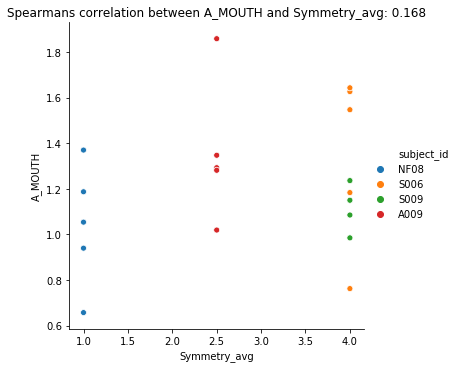

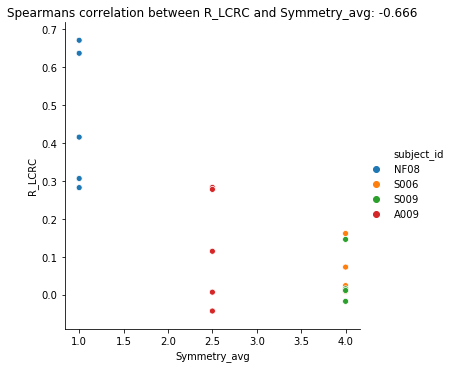

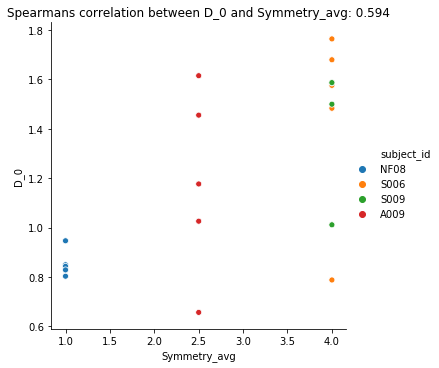

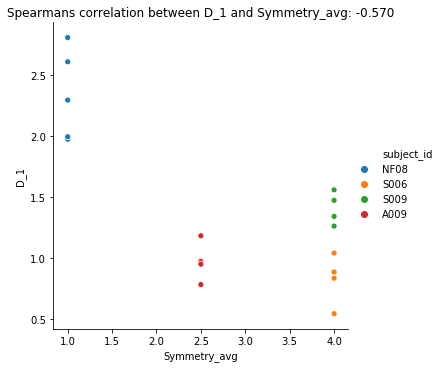

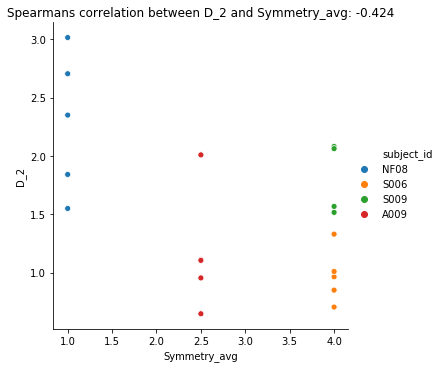

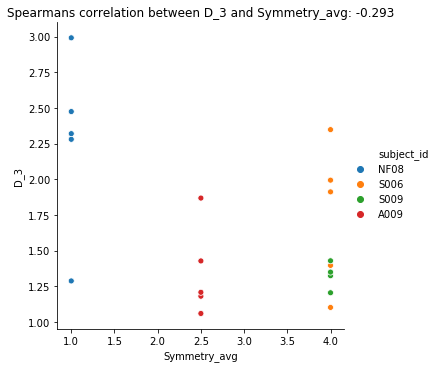

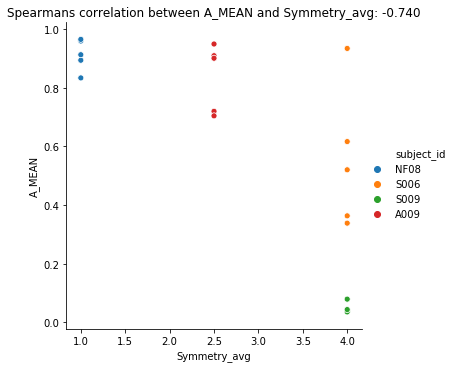

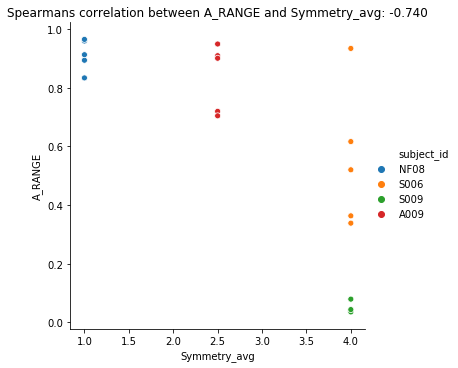

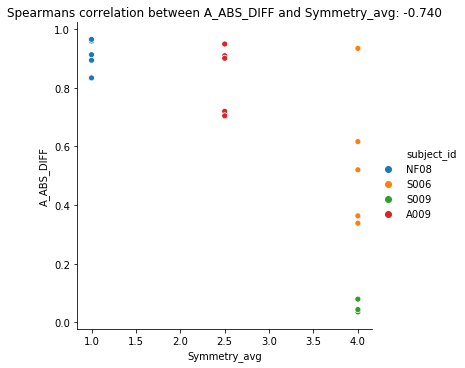

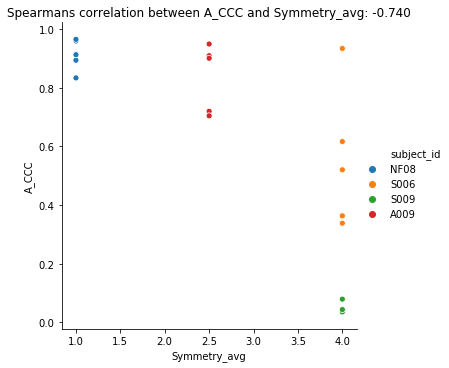

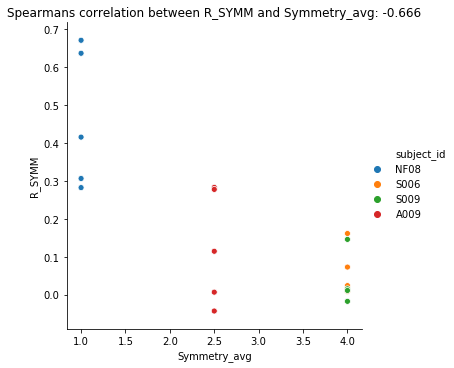

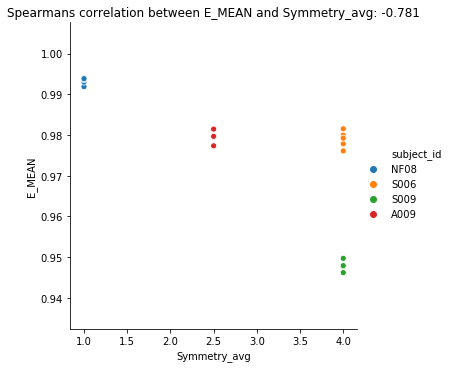

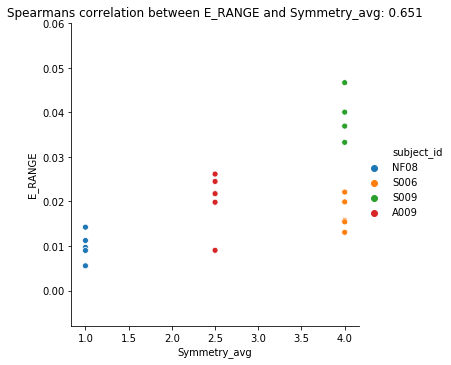

In [46]:

features_symmetry = ['A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2',
       'D_3', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF', 'A_CCC', 'R_SYMM', 'E_MEAN',
       'E_RANGE']

score = 'Symmetry_avg'

for f in features:

    g = sns.relplot(x=score, y=f, data=spread_sym, kind = 'scatter', hue = 'subject_id')
    #plt.title('The scatter plot between {} and {}'.format(f, score ))
    corr, _ = spearmanr(spread_sym[f], spread_sym[score])
    #print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.title('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.savefig('face_valid_sym_{}_{}'.format(score, f), bbox_inches='tight')
    

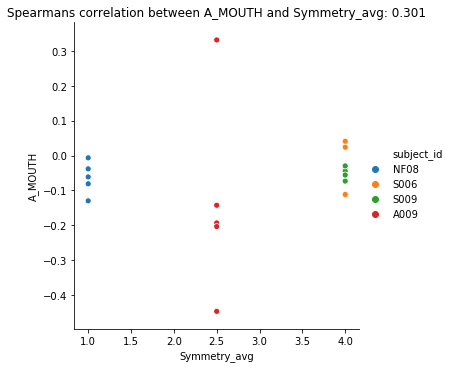

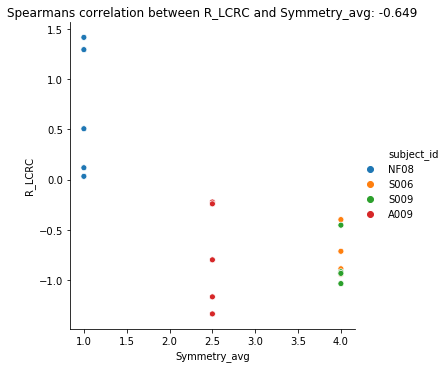

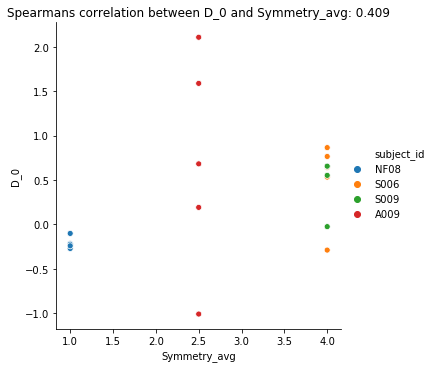

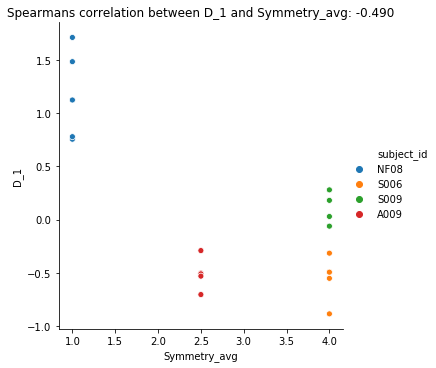

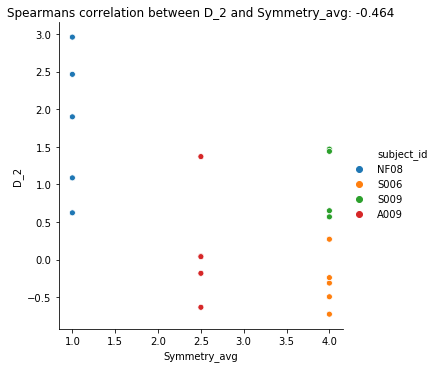

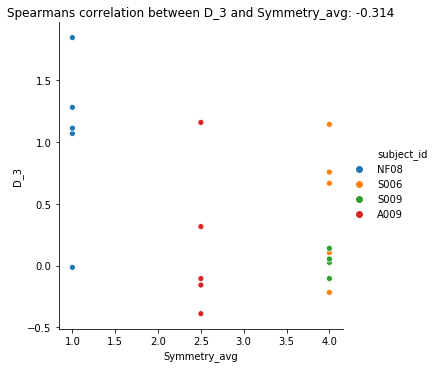

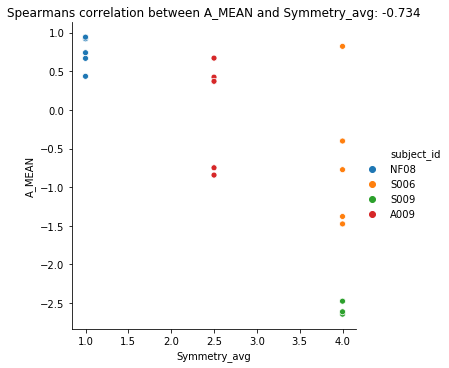

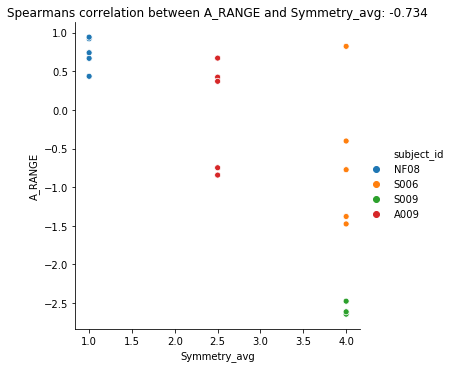

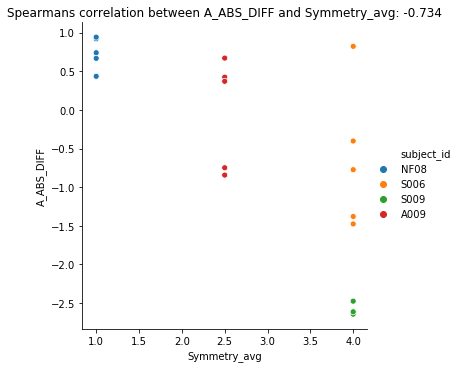

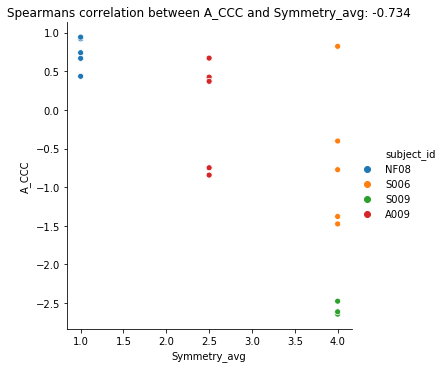

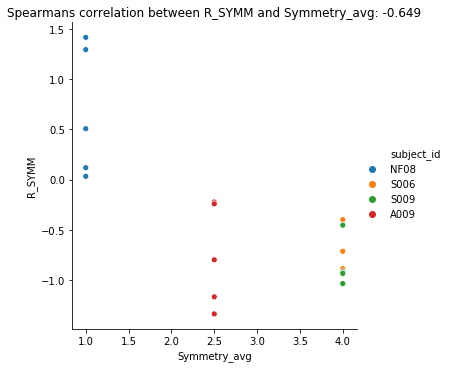

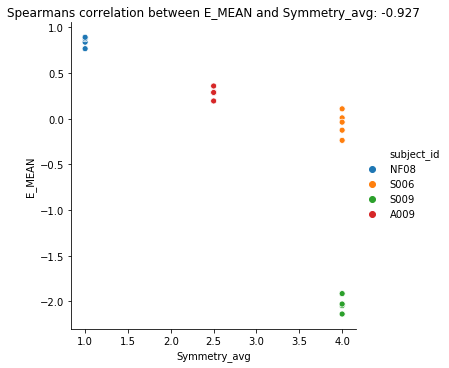

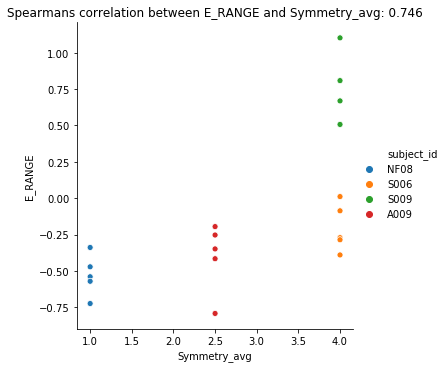

In [47]:
for f in features:

    g = sns.relplot(x=score, y=f, data=spread_sym_std, kind = 'scatter', hue = 'subject_id')
    #plt.title('The scatter plot between {} and {}'.format(f, score ))
    corr, _ = spearmanr(spread_sym_std[f], spread_sym_std[score])
    plt.title('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.savefig('face_valid_sym_std_{}_{}'.format(score, f), bbox_inches='tight')
    

In [13]:
spread_sym['A_ABS_DIFF'].loc[sub_neuro_df['subject_id'] == 'A009']

596    0.909481
597    0.900790
598    0.719820
599    0.949342
600    0.704470
Name: A_ABS_DIFF, dtype: float64

In [14]:
spread_sym['A_MEAN'].loc[sub_neuro_df['subject_id'] == 'A009']

596    0.909481
597    0.900790
598    0.719820
599    0.949342
600    0.704470
Name: A_MEAN, dtype: float64

The A_mean and A_bs_diff must be differnt quantities but are the same thing here!

### Speed Validation

In [35]:
features_speed = ['O_MAX_VEL', 'O_MIN_VEL','W_MAX_VEL', 'W_MIN_VEL', 
        'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN','HEIGHT_VEL_MAX', 'HEIGHT_VEL_MIN']


fv_speed = sub_neuro_df.loc[((sub_neuro_df['subject_id'] == 'NF08') | (sub_neuro_df['subject_id'] == 'A009')| 
                              (sub_neuro_df['subject_id'] == 'S002') ) & 
                             (sub_neuro_df['task'] == 'BBP_NORMAL') ]


fv_speed_std = sub_neuro_df_std.loc[((sub_neuro_df_std['subject_id'] == 'NF08') | (sub_neuro_df_std['subject_id'] == 'A009')| 
                              (sub_neuro_df_std['subject_id'] == 'S002') ) & 
                             (sub_neuro_df_std['task'] == 'BBP_NORMAL') ]


fv_speed = fv_speed.drop(['O_MAX', 'O_MIN', 'W_MAX', 'W_MIN', 'A_MOUTH', 'R_LCRC', 'D_0',
       'D_1', 'D_2', 'D_3', 'LL_PATH', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF',
       'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'HEIGHT_MAX', 'HEIGHT_MIN', 
       'R_SYMM', 'E_MEAN', 'E_RANGE'], axis=1)



fv_speed_std = fv_speed_std.drop(['O_MAX', 'O_MIN', 'W_MAX', 'W_MIN', 'A_MOUTH', 'R_LCRC', 'D_0',
       'D_1', 'D_2', 'D_3', 'LL_PATH', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF',
       'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'HEIGHT_MAX', 'HEIGHT_MIN', 
       'R_SYMM', 'E_MEAN', 'E_RANGE'], axis=1)


print(fv_speed.columns)
print(fv_speed.shape)

print(fv_speed_std.columns)
print(fv_speed_std.shape)
fv_speed

Index(['subject_id', 'task', 'rep', 'O_MAX_VEL', 'O_MIN_VEL', 'W_MAX_VEL',
       'W_MIN_VEL', 'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg',
       'Variability_avg', 'Fatigue_avg', 'population'],
      dtype='object')
(31, 18)
Index(['subject_id', 'task', 'rep', 'O_MAX_VEL', 'O_MIN_VEL', 'W_MAX_VEL',
       'W_MIN_VEL', 'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg',
       'Variability_avg', 'Fatigue_avg', 'population'],
      dtype='object')
(31, 18)


subject_id        task  rep  O_MAX_VEL  O_MIN_VEL  W_MAX_VEL  W_MIN_VEL  \
82        NF08  BBP_NORMAL    1   1.140972  -1.327729   0.139611  -0.160367   
83        NF08  BBP_NORMAL    2   0.853732  -0.990396   0.188243  -0.162739   
84        NF08  BBP_NORMAL    3   0.790555  -1.202111   0.170459  -0.165331   
85        NF08  BBP_NORMAL    4   0.970263  -1.108054   0.138904  -0.180661   
86        NF08  BBP_NORMAL    5   1.030041  -0.907173   0.163044  -0.136326   
87        NF08  BBP_NORMAL    6   0.776759  -1.097197   0.141165  -0.100922   
88        NF08  BBP_NORMAL    7   1.231056  -1.725802   0.124406  -0.171944   
89        NF08  BBP_NORMAL    8   0.870659  -1.066251   0.136099  -0.155800   
90        NF08  BBP_NORMAL    9   1.016818  -1.046036   0.138139  -0.072216   
91        NF08  BBP_NORMAL   10   0.685662  -0.710834   0.116489  -0.225831   
136       S002  BBP_NORMAL    1   1.069198  -0.901746   2.151146  -2.155383   
137       S002  BBP_NORMAL    2   1.194519  -0.904203   2.635529  -2.209430   
138       S002  BBP_NORMAL    3   0.742543  -1.163196   1.123371  -1.096853   
139       S002  BBP_NORMAL    4   0.677254  -0.953576   1.257846  -1.623205   
140       S002  BBP_NORMAL    5   0.888138  -1.184929   1.716904  -1.655546   
141       S002  BBP_NORMAL    6   0.716226  -1.138315   1.047860  -1.336169   
142       S002  BBP_NORMAL    7   0.716432  -0.972779   2.171861  -1.661476   
143       S002  BBP_NORMAL    8   1.244812  -0.853423   0.782143  -0.883958   
144       S002  BBP_NORMAL    9   0.545214  -1.316111   1.977229  -0.932544   
145       S002  BBP_NORMAL   10   0.736982  -0.865034   0.972981  -2.899230   
498       A009  BBP_NORMAL    1   0.681454  -0.611964   0.091948  -0.088072   
499       A009  BBP_NORMAL    2   0.787826  -0.552083   0.081125  -0.087138   
500       A009  BBP_NORMAL    3   0.836175  -0.655435   0.080621  -0.070388   
501       A009  BBP_NORMAL    4   0.684871  -0.551253   0.428342  -0.484048   
502       A009  BBP_NORMAL    5   1.095199  -0.504456   0.073136  -0.062819   
503       A009  BBP_NORMAL    6   0.512249  -0.747507   0.212845  -0.133500   
504       A009  BBP_NORMAL    7   0.655174  -0.555534   0.052155  -0.082737   
505       A009  BBP_NORMAL    8   0.729832  -0.637605   0.063654  -0.093830   
506       A009  BBP_NORMAL    9   0.565516  -0.551702   0.093151  -0.054039   
507       A009  BBP_NORMAL   10   0.607722  -0.860759   0.058591  -0.058029   
508       A009  BBP_NORMAL   11   0.697344  -0.518098   0.064559  -0.066506   

     WIDTH_VEL_MAX  WIDTH_VEL_MIN  HEIGHT_VEL_MAX  HEIGHT_VEL_MIN  Tot_avg  \
82        0.139611      -0.160367        1.140972       -1.327729      5.5   
83        0.188243      -0.162739        0.853732       -0.990396      5.5   
84        0.170459      -0.165331        0.790555       -1.202111      5.5   
85        0.138904      -0.180661        0.970263       -1.108054      5.5   
86        0.163044      -0.136326        1.030041       -0.907173      5.5   
87        0.141165      -0.100922        0.776759       -1.097197      5.5   
88        0.124406      -0.171944        1.231056       -1.725802      5.5   
89        0.136099      -0.155800        0.870659       -1.066251      5.5   
90        0.138139      -0.072216        1.016818       -1.046036      5.5   
91        0.116489      -0.225831        0.685662       -0.710834      5.5   
136       2.151146      -2.155383        1.069198       -0.901746     13.5   
137       2.635529      -2.209430        1.194519       -0.904203     13.5   
138       1.123371      -1.096853        0.742543       -1.163196     13.5   
139       1.257846      -1.623205        0.677254       -0.953576     13.5   
140       1.716904      -1.655546        0.888138       -1.184929     13.5   
141       1.047860      -1.336169        0.716226       -1.138315     13.5   
142       2.171861      -1.661476        0.716432       -0.972779     13.5   
143       0.782143      -0.883958        1.244812       -0.853423     1

In [36]:
spread_sym_std.head()

subject_id        task  type  rep   A_MOUTH    R_LCRC       D_0       D_1  \
384       NF08  NSM_SPREAD     0    1 -0.006650  0.506727 -0.217432  0.755158   
385       NF08  NSM_SPREAD     0    2 -0.061401  1.415125 -0.224808  1.123769   
386       NF08  NSM_SPREAD     0    3 -0.038334  0.118825 -0.102441  0.778886   
387       NF08  NSM_SPREAD     0    4 -0.081167  0.033243 -0.272071  1.484080   
388       NF08  NSM_SPREAD     0    5 -0.130108  1.293214 -0.241907  1.711949   

          D_2       D_3  ...  Variability (SLP2)  Fatigue (SLP2)  Tot (SLP2)  \
384  2.463436  1.068155  ...                   1               1           5   
385  1.086387  1.280250  ...                   1               1           5   
386  1.898072  1.111343  ...                   1               1           5   
387  0.621398  1.844233  ...                   1               1           5   
388  2.958273 -0.014868  ...                   1               1           5   

     Tot_avg  Symmetry_avg  ROM_avg  Speed_avg Variability_avg Fatigue_avg  \
384      5.0           1.0      1.0        1.0             1.0         1.0   
385      5.0           1.0      1.0        1.0             1.0         1.0   
386      5.0           1.0      1.0        1.0             1.0         1.0   
387      5.0           1.0      1.0        1.0             1.0         1.0   
388      5.0           1.0      1.0        1.0             1.0         1.0   

     population  
384          HC  
385          HC  
386          HC  
387          HC  
388          HC  

[5 rows x 38 columns]

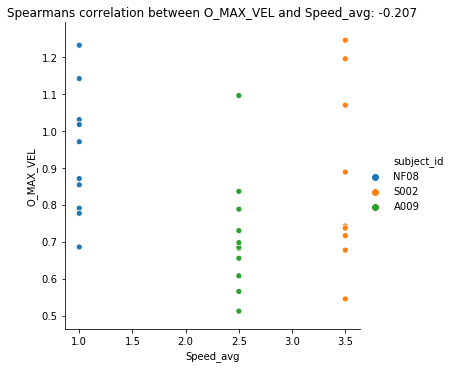

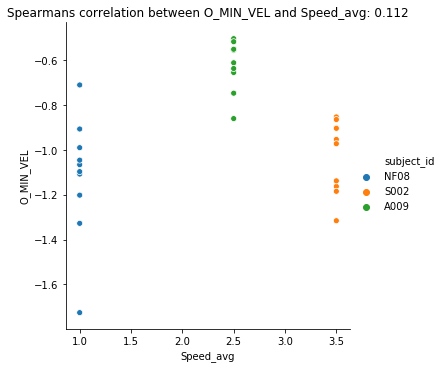

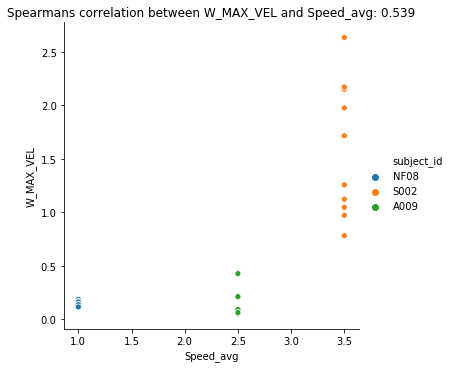

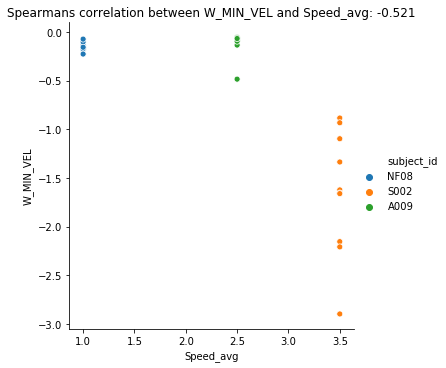

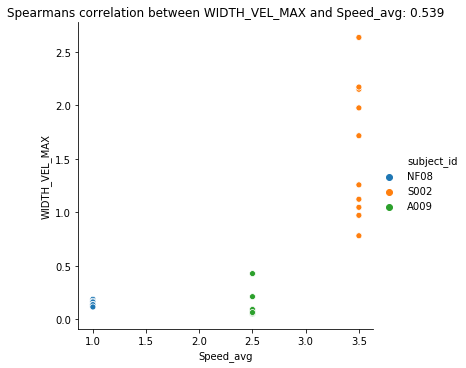

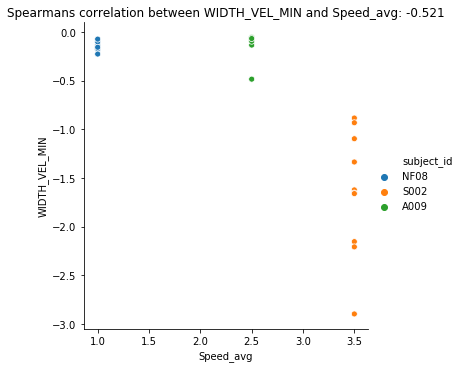

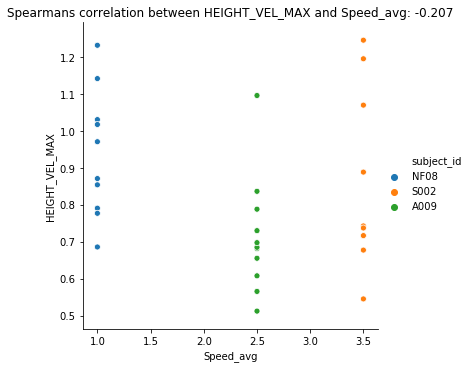

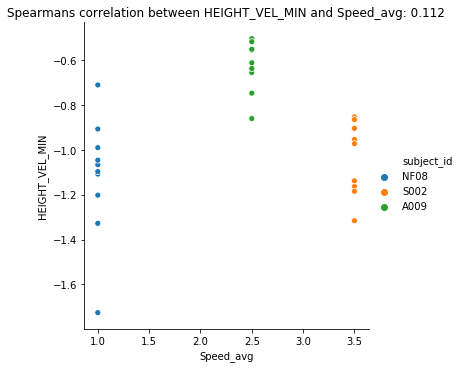

In [53]:
score = 'Speed_avg'

for f in features_speed:

    g = sns.relplot(x=score, y=f, data=fv_speed, kind = 'scatter', hue = 'subject_id')
    #plt.title('The scatter plot between {} and {}'.format(f, score ))
    corr, _ = spearmanr(fv_speed[f], fv_speed[score])
    #print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.title('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.savefig('face_valid_speed_{}_{}'.format(score, f), bbox_inches='tight')
    

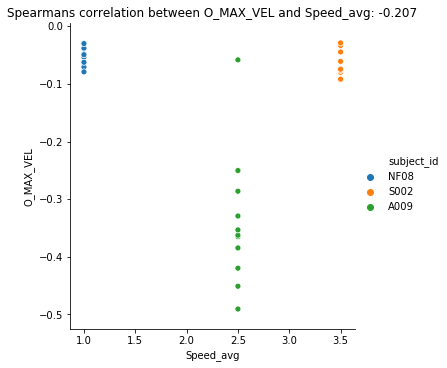

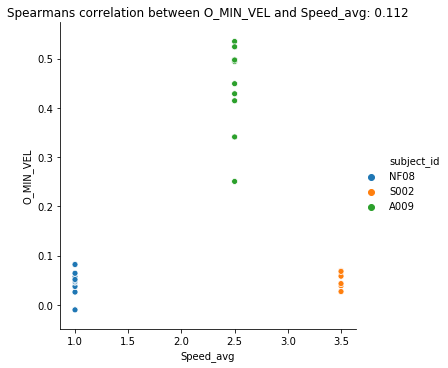

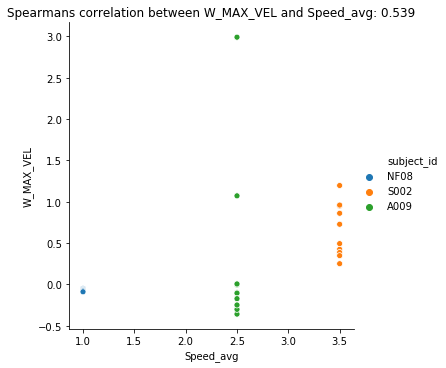

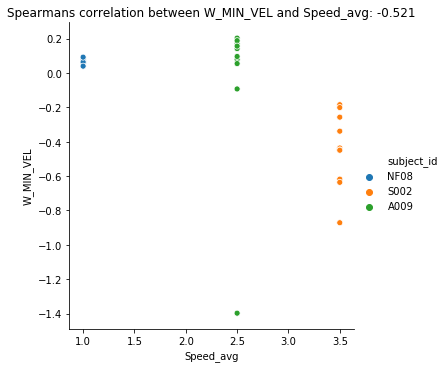

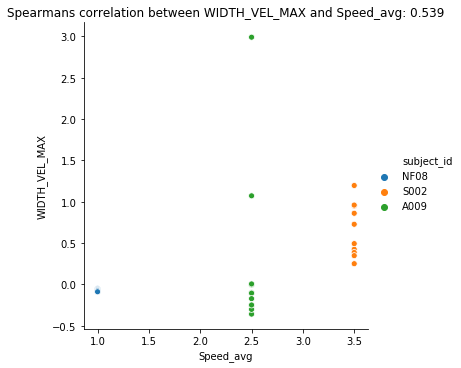

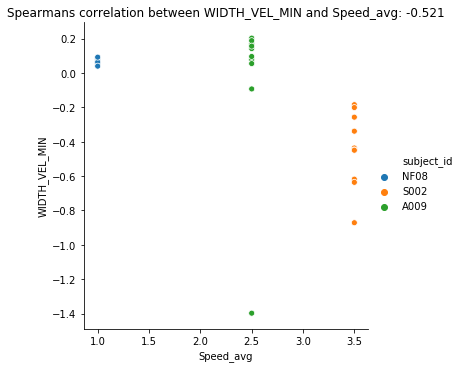

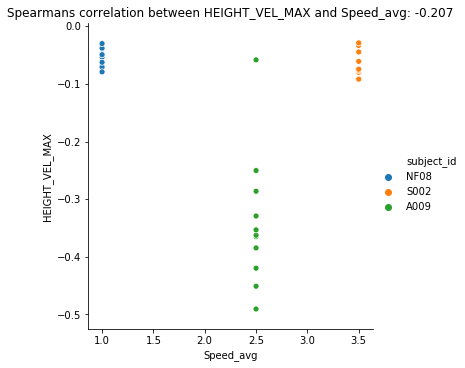

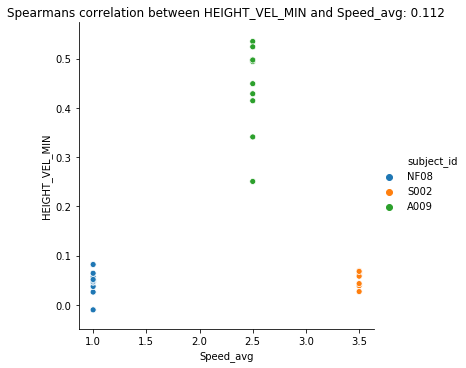

In [52]:
for f in features_speed:

    g = sns.relplot(x=score, y=f, data=fv_speed_std, kind = 'scatter', hue = 'subject_id')
    #plt.title('The scatter plot between {} and {}'.format(f, score ))
    corr, _ = spearmanr(fv_speed[f], fv_speed[score])
    #print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.title('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.savefig('face_valid_speed_std_{}_{}'.format(score, f), bbox_inches='tight')
    

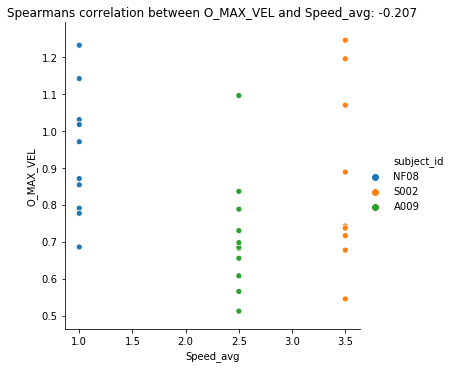

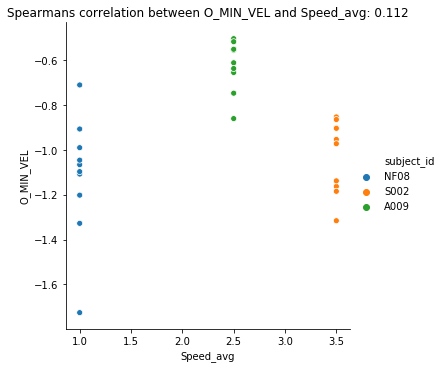

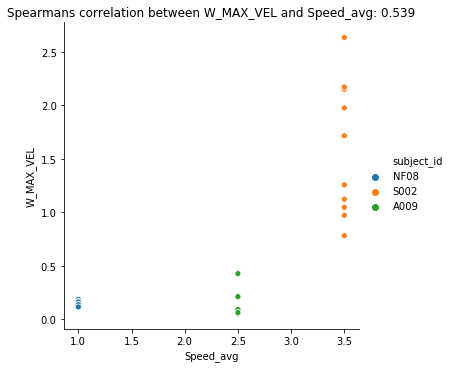

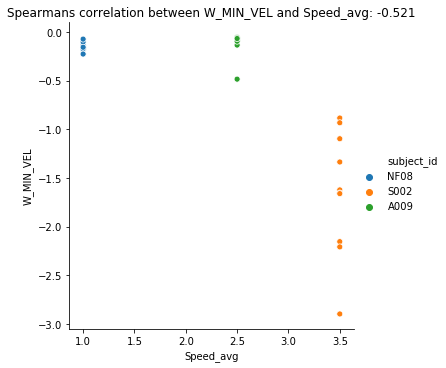

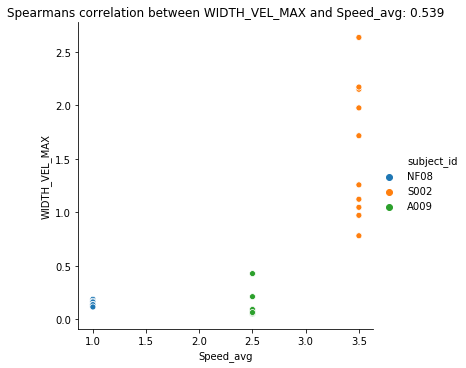

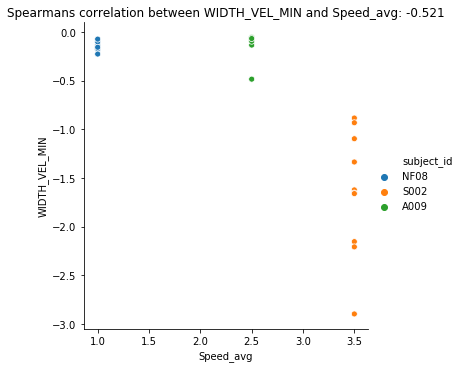

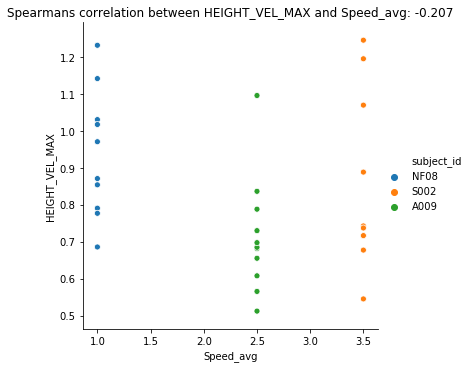

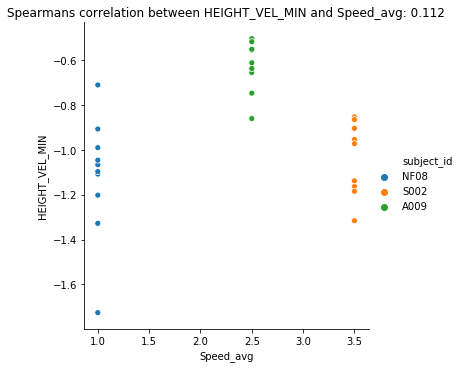

In [50]:
# filtering out the outliers 

z_scores = stats.zscore(fv_speed[features_speed])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
fv_speed_olr = fv_speed[filtered_entries]


for f in features_speed:

    g = sns.relplot(x=score, y=f, data=fv_speed_olr, kind = 'scatter', hue = 'subject_id')
    
    corr, _ = spearmanr(fv_speed_olr[f], fv_speed_olr[score])
    
    plt.title('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.savefig('face_valid_speed_olr_{}_{}'.format(score, f), bbox_inches='tight')
    

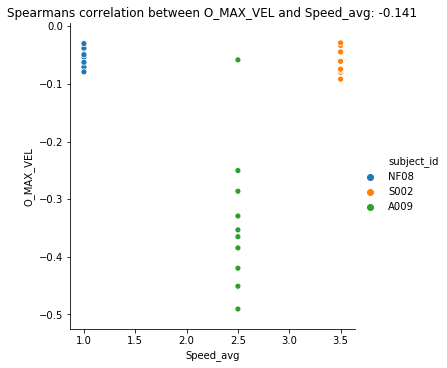

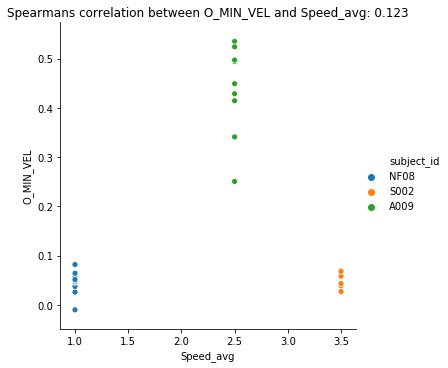

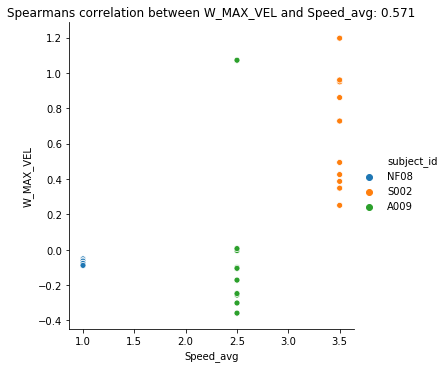

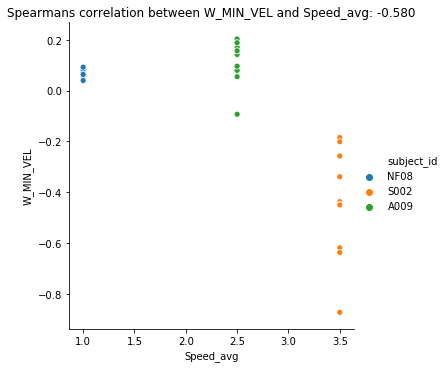

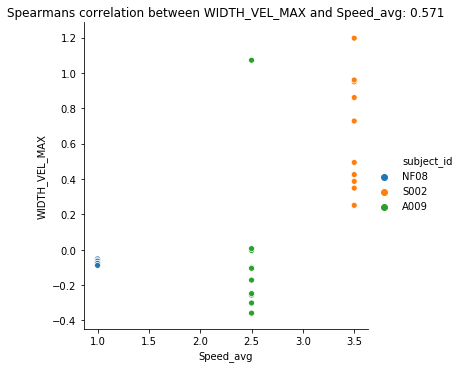

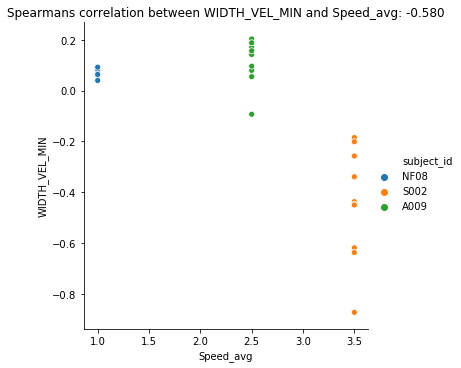

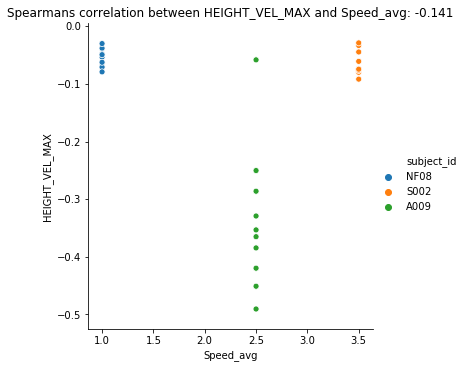

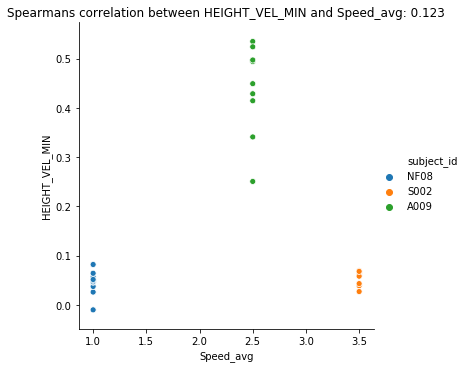

In [51]:
# filtering out the outliers 

z_scores = stats.zscore(fv_speed_std[features_speed])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
fv_speed_olr_std = fv_speed_std[filtered_entries]


for f in features_speed:

    g = sns.relplot(x=score, y=f, data=fv_speed_olr_std, kind = 'scatter', hue = 'subject_id')

    corr, _ = spearmanr(fv_speed_olr_std[f], fv_speed_olr_std[score])
 
    plt.title('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.savefig('face_valid_speed_olr_std_{}_{}'.format(score, f), bbox_inches='tight')
    

### ROM Validation 

In [56]:
features_rom = ['O_MAX', 'O_MIN', 'W_MAX', 'W_MIN', 
             'LL_PATH', 'A_MEAN', 'A_RANGE', 'WIDTH_MAX',
            'WIDTH_MEAN','HEIGHT_MAX', 'HEIGHT_MIN']


fv_rom = sub_neuro_df.loc[((sub_neuro_df['subject_id'] == 'NF08') & (sub_neuro_df['task'] == 'NSM_SPREAD'))
            |((sub_neuro_df['subject_id'] == 'NF11') & (sub_neuro_df['task'] == 'BBP_NORMAL'))
      | ((sub_neuro_df['subject_id'] == 'A009') & ((sub_neuro_df['task'] == 'BBP_NORMAL')|(sub_neuro_df['task'] == 'NSM_SPREAD'))) 
         | ((sub_neuro_df['subject_id'] == 'S005') & (sub_neuro_df['task'] == 'BBP_NORMAL')) 
        |    ((sub_neuro_df['subject_id'] == 'S006') & (sub_neuro_df['task'] == 'NSM_SPREAD')) ]


fv_rom_std = sub_neuro_df_std.loc[((sub_neuro_df_std['subject_id'] == 'NF08') & (sub_neuro_df_std['task'] == 'NSM_SPREAD'))
            |((sub_neuro_df_std['subject_id'] == 'NF11') & (sub_neuro_df_std['task'] == 'BBP_NORMAL'))
      | ((sub_neuro_df_std['subject_id'] == 'A009') & ((sub_neuro_df_std['task'] == 'BBP_NORMAL')|(sub_neuro_df_std['task'] == 'NSM_SPREAD'))) 
         | ((sub_neuro_df_std['subject_id'] == 'S005') & (sub_neuro_df_std['task'] == 'BBP_NORMAL')) 
        |    ((sub_neuro_df_std['subject_id'] == 'S006') & (sub_neuro_df_std['task'] == 'NSM_SPREAD')) ]


 

fv_rom = fv_rom.drop(['O_MAX_VEL', 'O_MIN_VEL', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
                      'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3',  
    'A_ABS_DIFF', 'A_CCC',  'WIDTH_VEL_MAX','WIDTH_VEL_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE'], axis=1)



fv_rom_std = fv_rom_std.drop(['O_MAX_VEL', 'O_MIN_VEL', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
                      'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3',  
    'A_ABS_DIFF', 'A_CCC',  'WIDTH_VEL_MAX','WIDTH_VEL_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE'], axis=1)


print(fv_rom.columns)
print(fv_rom.shape)

print(fv_rom_std.columns)
print(fv_rom_std.shape)
#fv_rom

Index(['subject_id', 'task', 'rep', 'O_MAX', 'O_MIN', 'W_MAX', 'W_MIN',
       'LL_PATH', 'A_MEAN', 'A_RANGE', 'WIDTH_MAX', 'WIDTH_MEAN', 'HEIGHT_MAX',
       'HEIGHT_MIN', 'Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg',
       'Variability_avg', 'Fatigue_avg', 'population'],
      dtype='object')
(47, 21)
Index(['subject_id', 'task', 'rep', 'O_MAX', 'O_MIN', 'W_MAX', 'W_MIN',
       'LL_PATH', 'A_MEAN', 'A_RANGE', 'WIDTH_MAX', 'WIDTH_MEAN', 'HEIGHT_MAX',
       'HEIGHT_MIN', 'Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg',
       'Variability_avg', 'Fatigue_avg', 'population'],
      dtype='object')
(47, 21)


Spearmans correlation between O_MAX and ROM_avg: -0.142
Spearmans correlation between O_MIN and ROM_avg: -0.329
Spearmans correlation between W_MAX and ROM_avg: -0.094
Spearmans correlation between W_MIN and ROM_avg: 0.110
Spearmans correlation between LL_PATH and ROM_avg: 0.294
Spearmans correlation between A_MEAN and ROM_avg: -0.363
Spearmans correlation between A_RANGE and ROM_avg: -0.363
Spearmans correlation between WIDTH_MAX and ROM_avg: -0.094
Spearmans correlation between WIDTH_MEAN and ROM_avg: 0.110
Spearmans correlation between HEIGHT_MAX and ROM_avg: -0.142
Spearmans correlation between HEIGHT_MIN and ROM_avg: -0.329


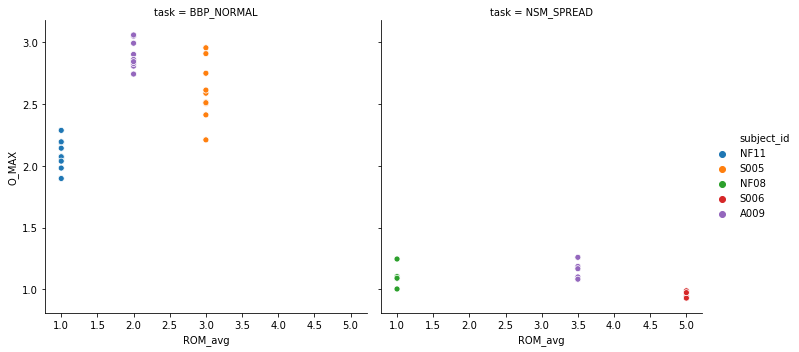

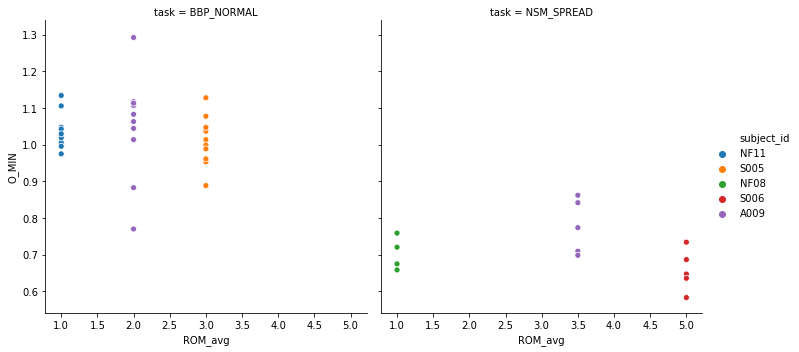

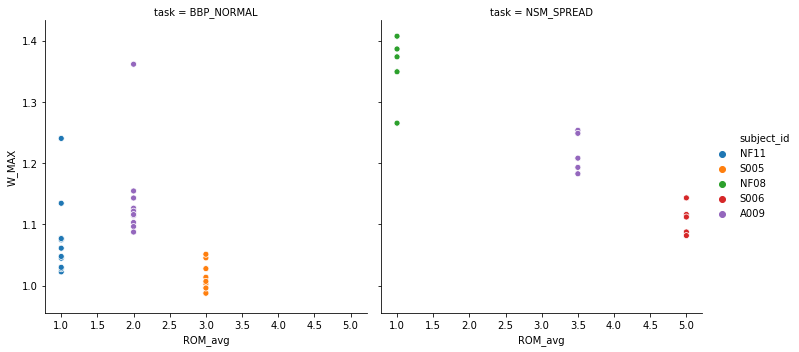

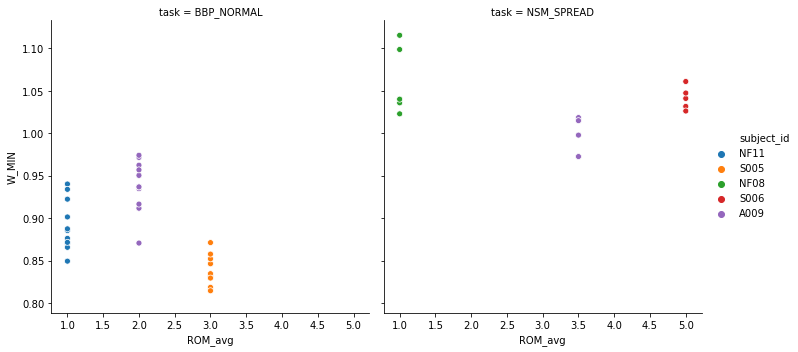

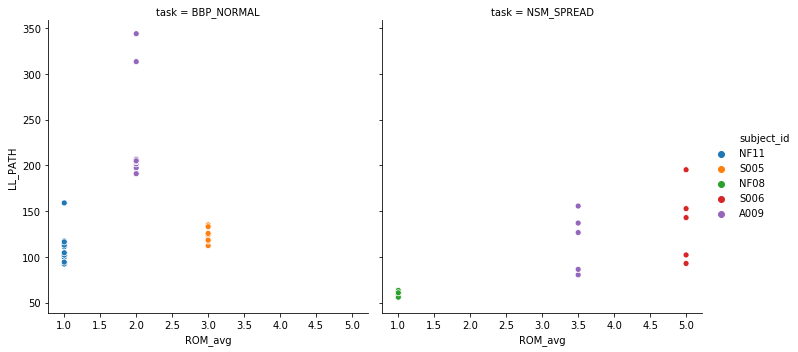

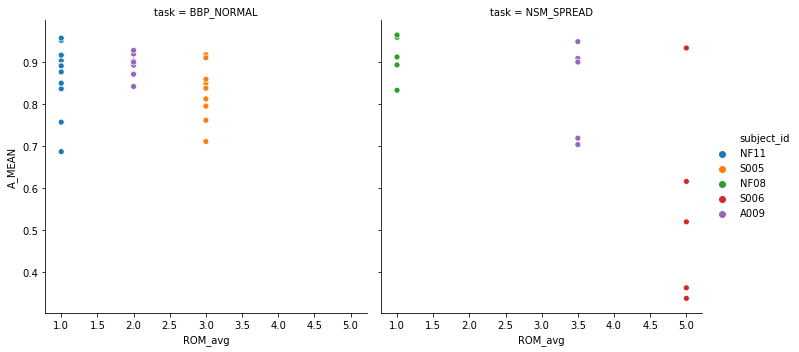

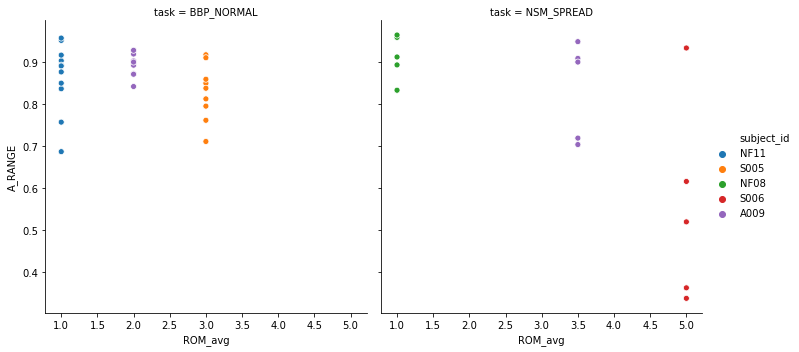

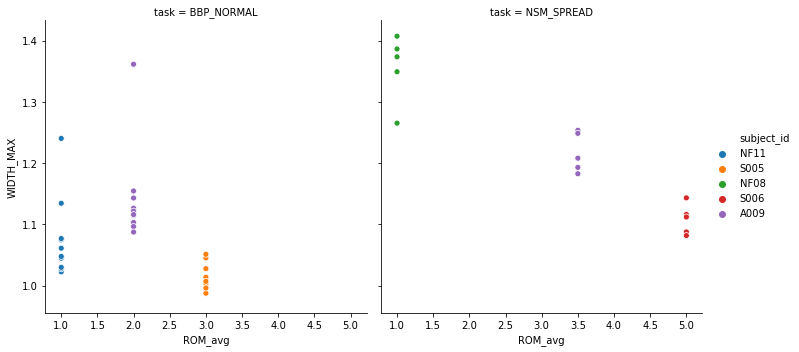

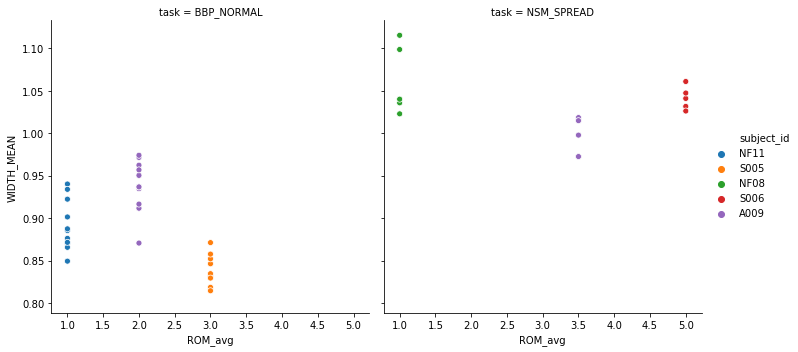

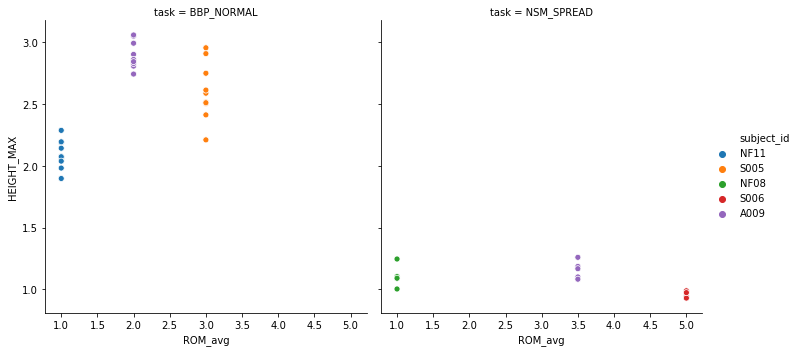

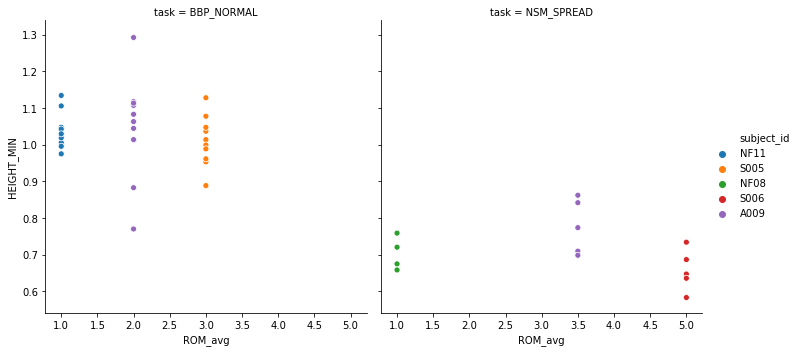

In [58]:
score = 'ROM_avg'

for f in features_rom:

    g = sns.relplot(x=score, y=f, data=fv_rom, kind = 'scatter',  col ='task', hue = 'subject_id')
    #plt.title('The scatter plot between {} and {}'.format(f, score ))
    corr, _ = spearmanr(fv_rom[f], fv_rom[score])
    print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    #plt.title('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.savefig('face_valid_ROM_{}_{}'.format(score, f), bbox_inches='tight')

Spearmans correlation between O_MAX and ROM_avg: -0.142
Spearmans correlation between O_MIN and ROM_avg: -0.329
Spearmans correlation between W_MAX and ROM_avg: -0.094
Spearmans correlation between W_MIN and ROM_avg: 0.110
Spearmans correlation between LL_PATH and ROM_avg: 0.294
Spearmans correlation between A_MEAN and ROM_avg: -0.363
Spearmans correlation between A_RANGE and ROM_avg: -0.363
Spearmans correlation between WIDTH_MAX and ROM_avg: -0.094
Spearmans correlation between WIDTH_MEAN and ROM_avg: 0.110
Spearmans correlation between HEIGHT_MAX and ROM_avg: -0.142
Spearmans correlation between HEIGHT_MIN and ROM_avg: -0.329


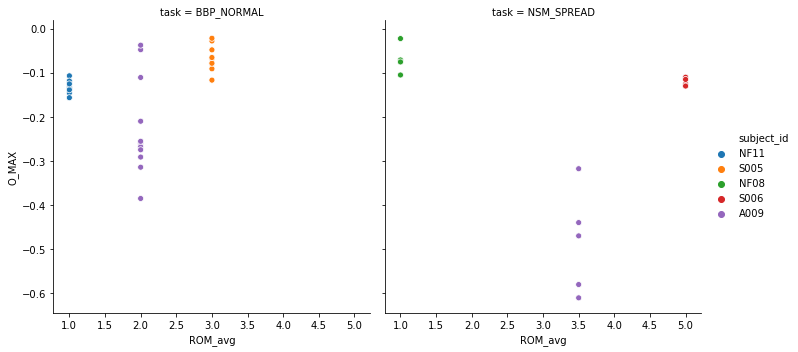

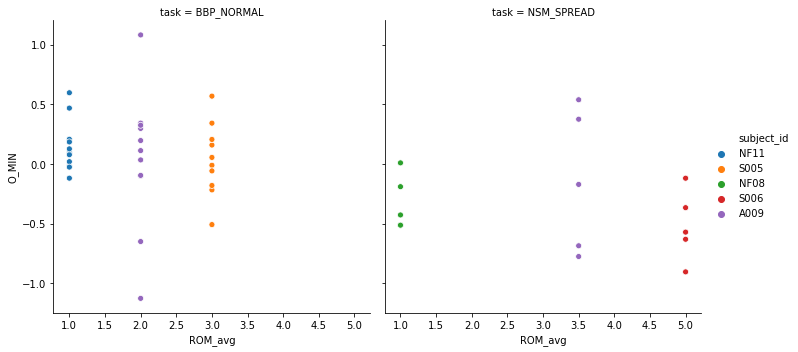

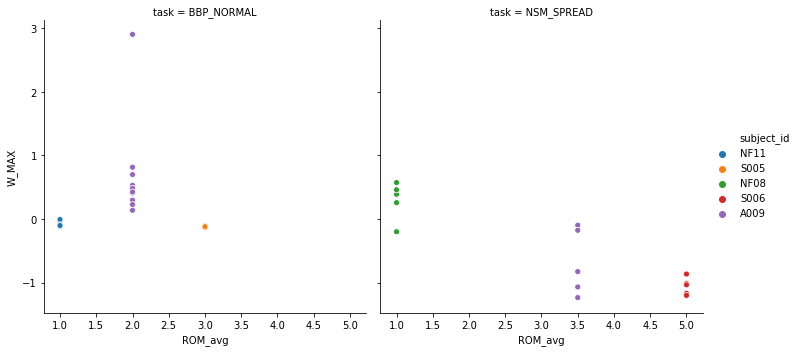

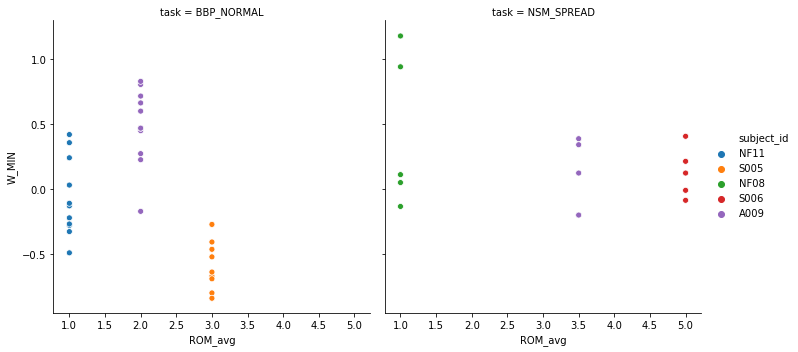

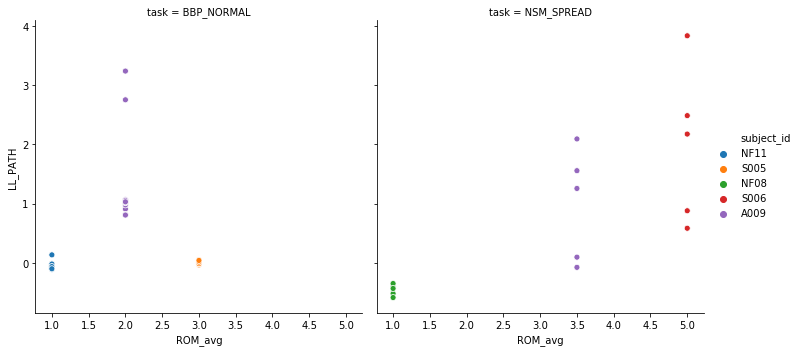

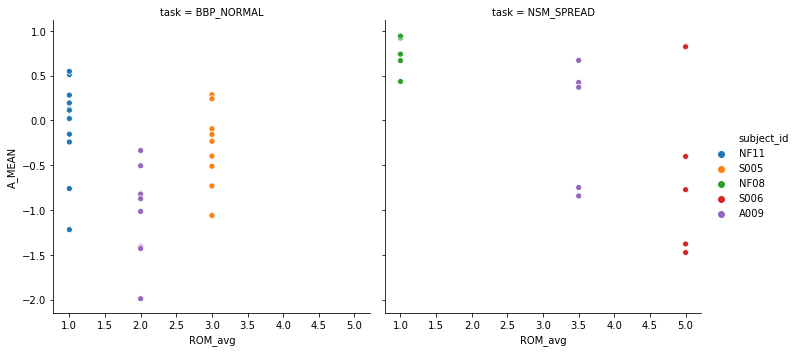

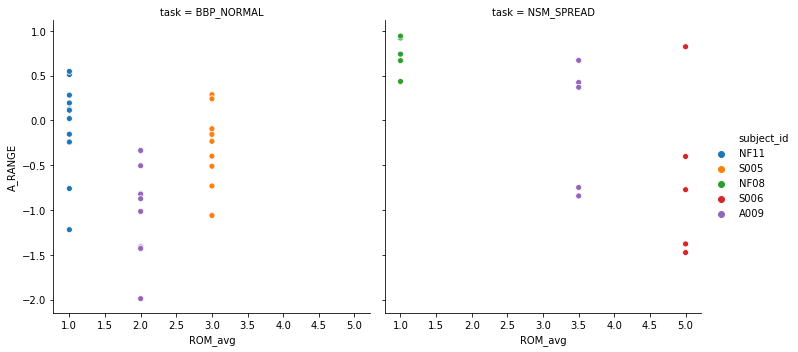

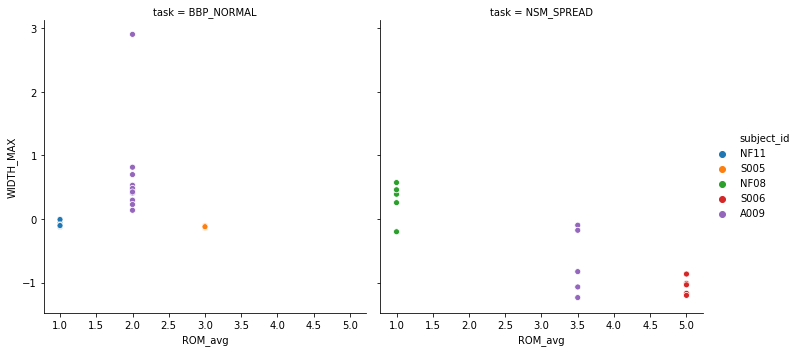

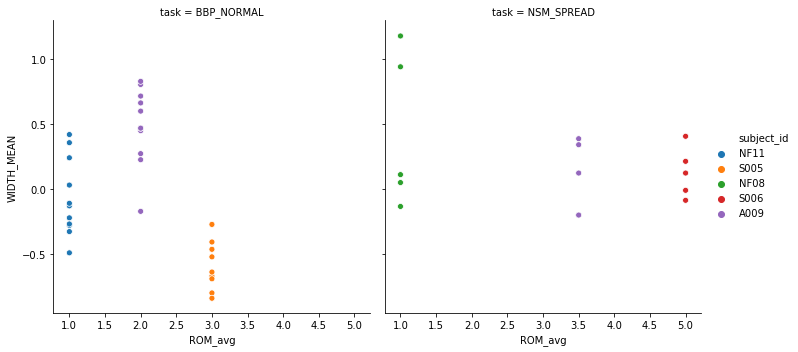

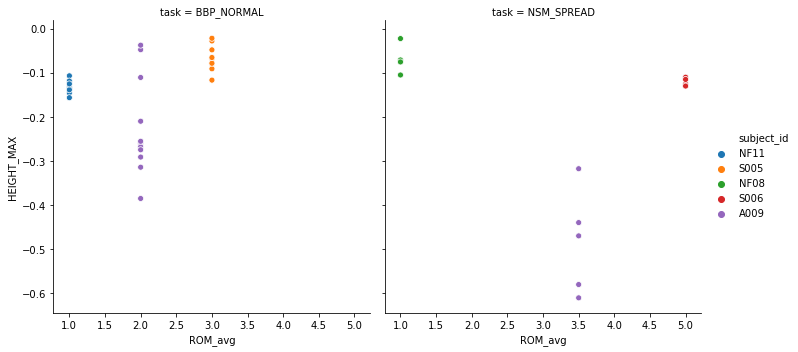

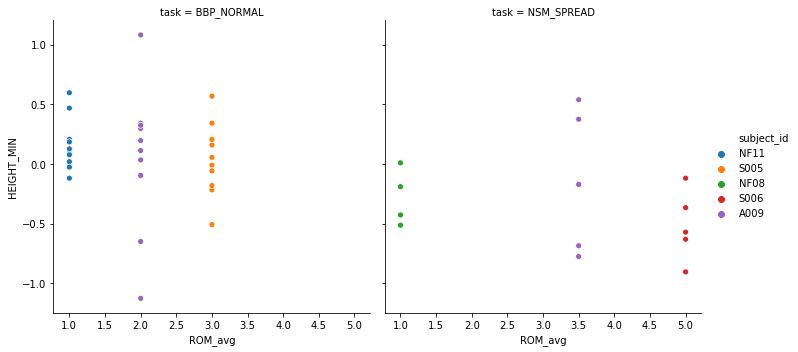

In [59]:
for f in features_rom:

    g = sns.relplot(x=score, y=f, data=fv_rom_std, kind = 'scatter', col ='task', hue = 'subject_id')
    #plt.title('The scatter plot between {} and {}'.format(f, score ))
    corr, _ = spearmanr(fv_rom[f], fv_rom[score])
    print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    #plt.title('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.savefig('face_valid_ROM_std_{}_{}'.format(score, f), bbox_inches='tight')
    

In [ ]:
 col ='task'

### THE END OF FACE VALIDITY 

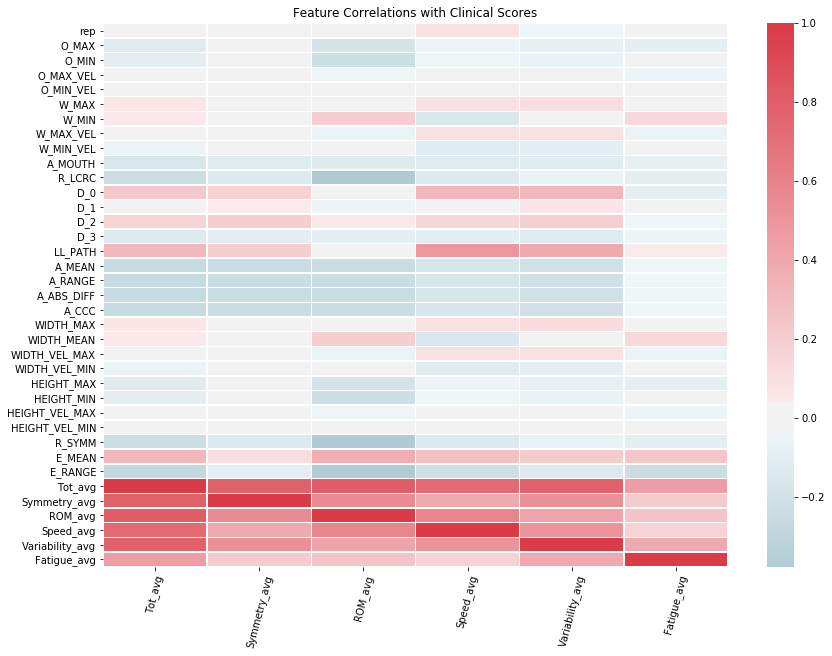

In [15]:

# run features vs scores corrolation analysis and scatter plots 
corr = sub_neuro_df.corr()
ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), 
               cmap=sns.diverging_palette(220, 10, as_cmap=True),center=0.00, linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.title('Feature Correlations with Clinical Scores')
plt.show()



Spearmans correlation between A_MOUTH and Tot_avg: -0.102
Spearmans correlation between R_LCRC and Tot_avg: -0.199
Spearmans correlation between D_0 and Tot_avg: 0.072
Spearmans correlation between D_1 and Tot_avg: 0.075
Spearmans correlation between D_2 and Tot_avg: 0.230
Spearmans correlation between D_3 and Tot_avg: -0.006
Spearmans correlation between A_MEAN and Tot_avg: -0.172
Spearmans correlation between A_RANGE and Tot_avg: -0.172
Spearmans correlation between A_ABS_DIFF and Tot_avg: -0.172
Spearmans correlation between A_CCC and Tot_avg: -0.172
Spearmans correlation between R_SYMM and Tot_avg: -0.199
Spearmans correlation between E_MEAN and Tot_avg: 0.295
Spearmans correlation between E_RANGE and Tot_avg: -0.275
Spearmans correlation between A_MOUTH and Symmetry_avg: 0.031
Spearmans correlation between R_LCRC and Symmetry_avg: -0.081
Spearmans correlation between D_0 and Symmetry_avg: 0.055
Spearmans correlation between D_1 and Symmetry_avg: 0.098
Spearmans correlation between

//anaconda3/envs/csc2541/lib/python3.8/site-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Spearmans correlation between A_RANGE and Symmetry_avg: -0.113
Spearmans correlation between A_ABS_DIFF and Symmetry_avg: -0.113
Spearmans correlation between A_CCC and Symmetry_avg: -0.113
Spearmans correlation between R_SYMM and Symmetry_avg: -0.081
Spearmans correlation between E_MEAN and Symmetry_avg: 0.063
Spearmans correlation between E_RANGE and Symmetry_avg: -0.049
Spearmans correlation between A_MOUTH and ROM_avg: -0.218
Spearmans correlation between R_LCRC and ROM_avg: -0.347
Spearmans correlation between D_0 and ROM_avg: 0.022
Spearmans correlation between D_1 and ROM_avg: -0.081
Spearmans correlation between D_2 and ROM_avg: 0.204
Spearmans correlation between D_3 and ROM_avg: -0.060
Spearmans correlation between A_MEAN and ROM_avg: -0.233
Spearmans correlation between A_RANGE and ROM_avg: -0.233
Spearmans correlation between A_ABS_DIFF and ROM_avg: -0.233
Spearmans correlation between A_CCC and ROM_avg: -0.233
Spearmans correlation between R_SYMM and ROM_avg: -0.347
Spearm

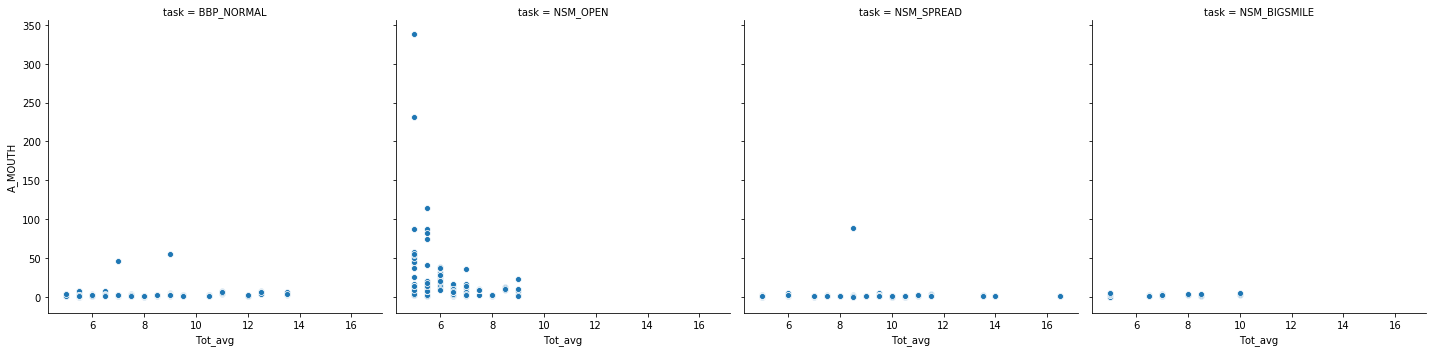

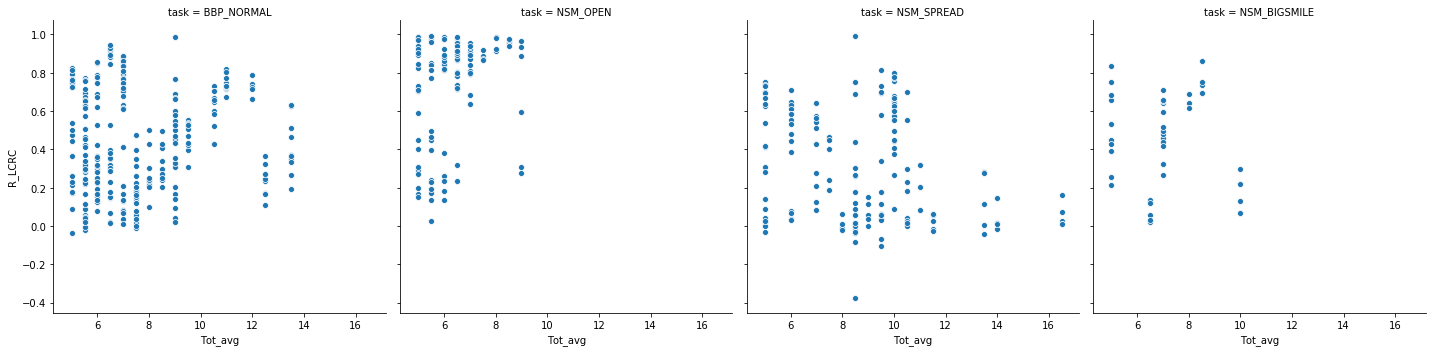

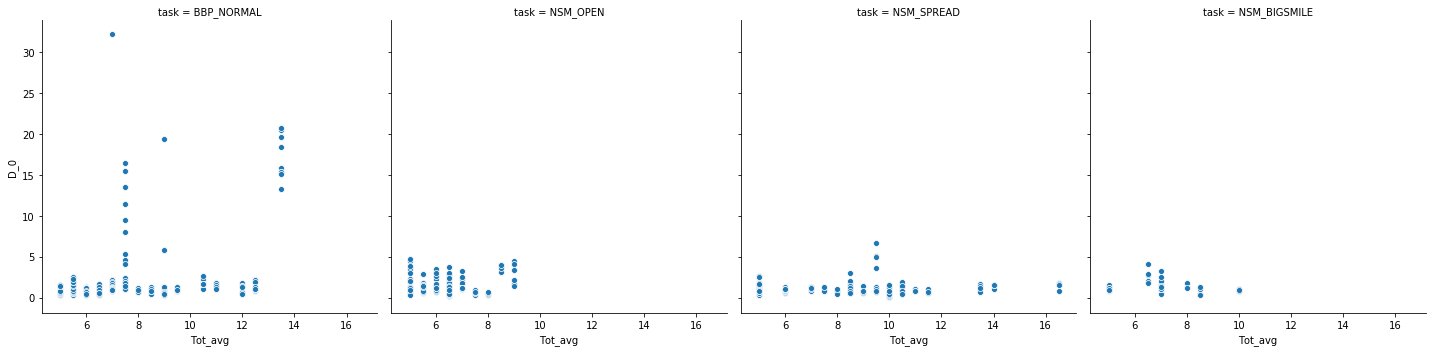

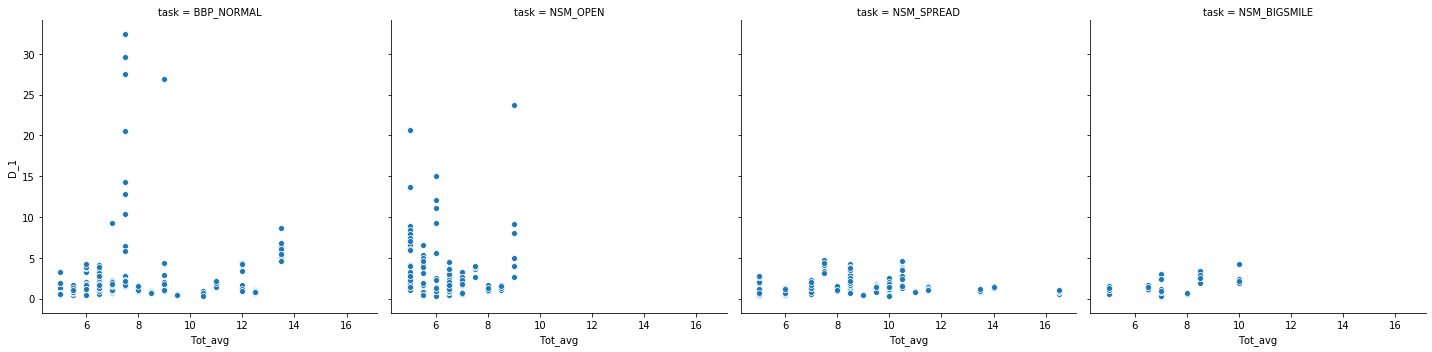

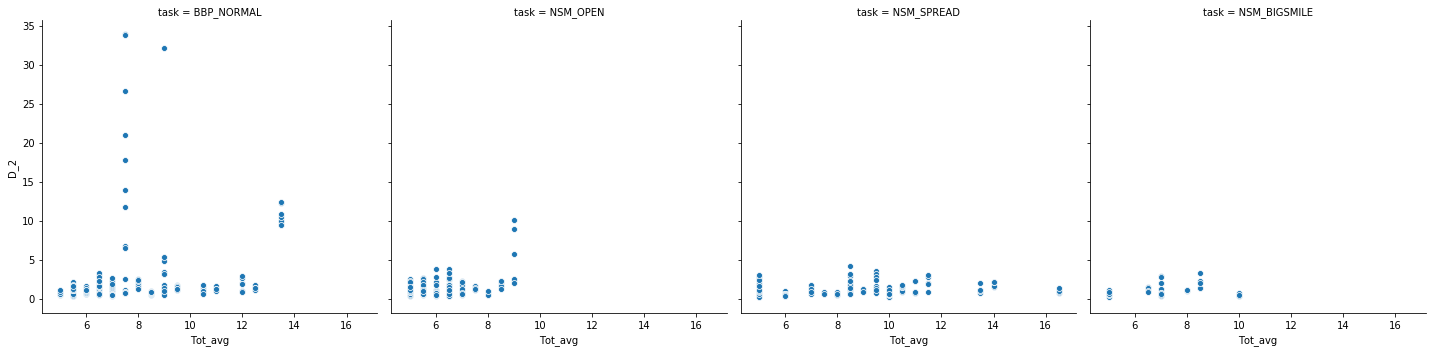

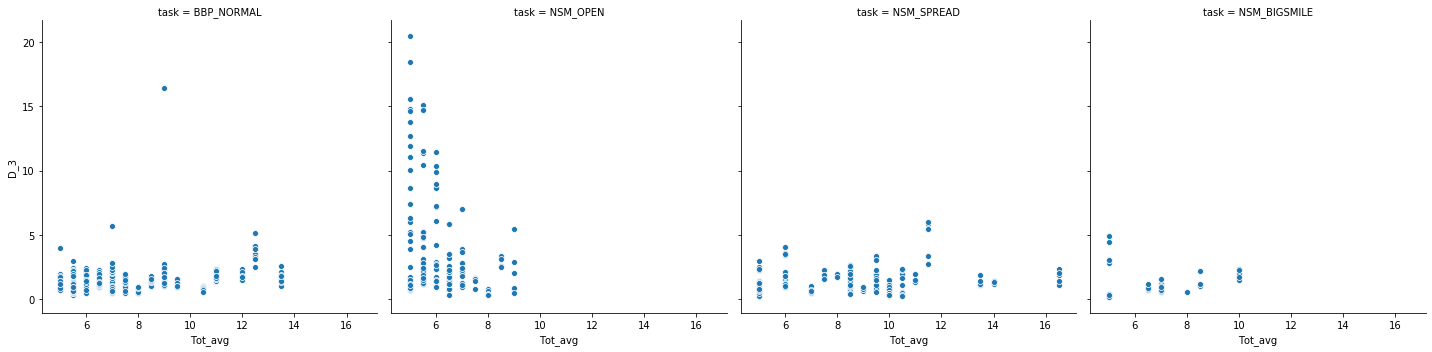

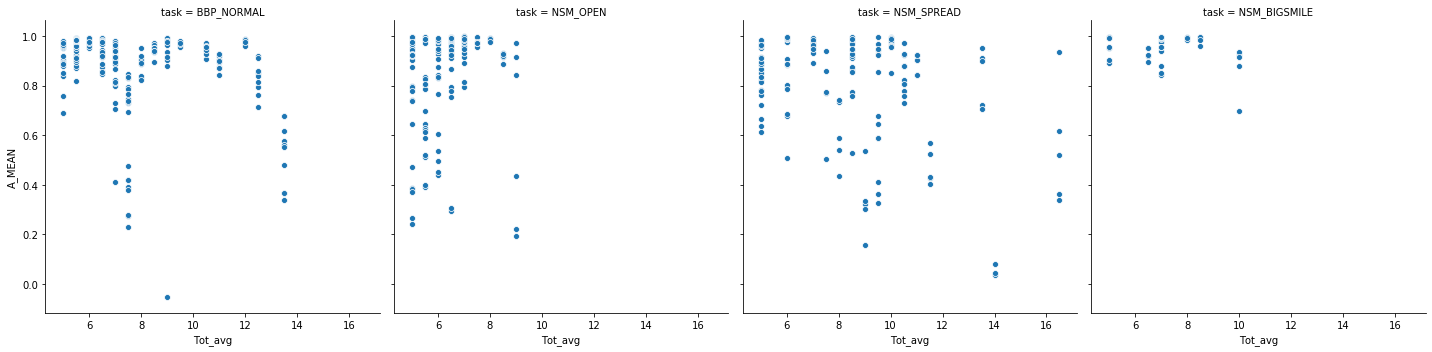

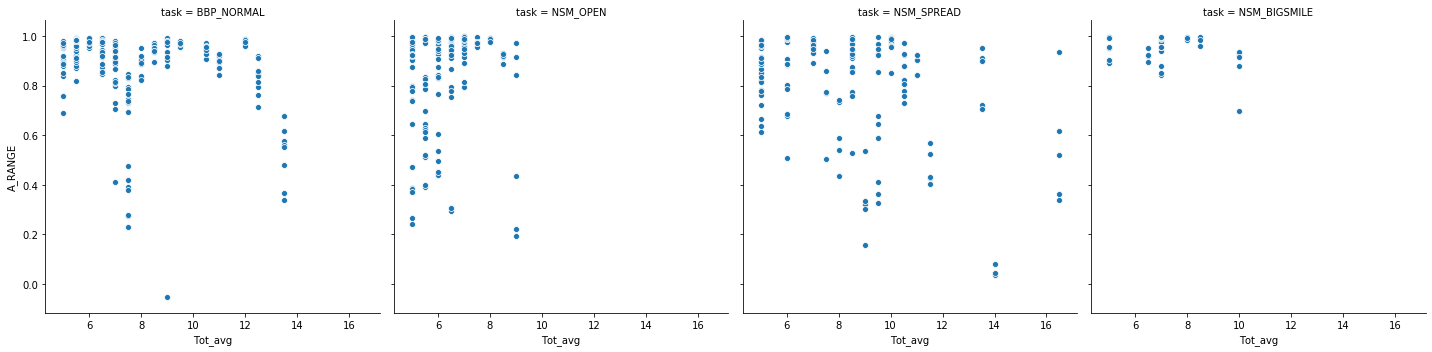

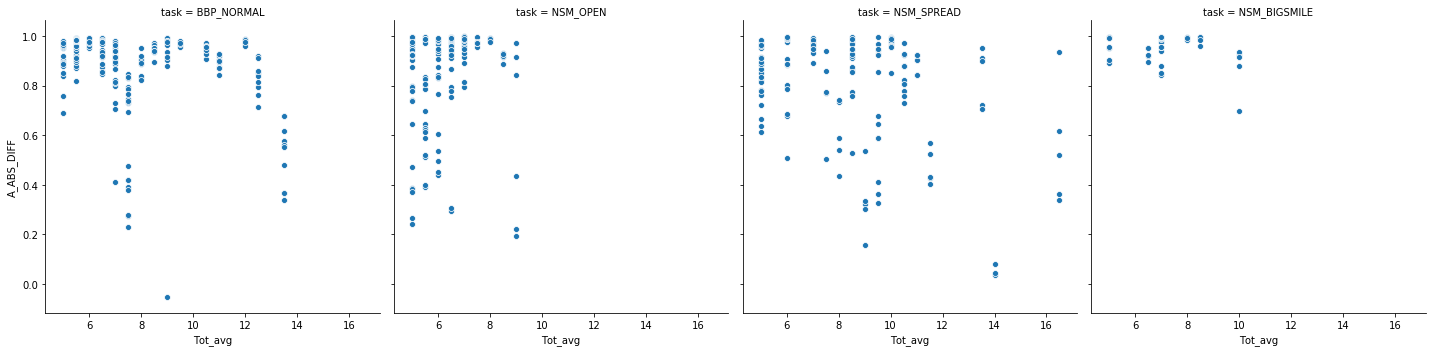

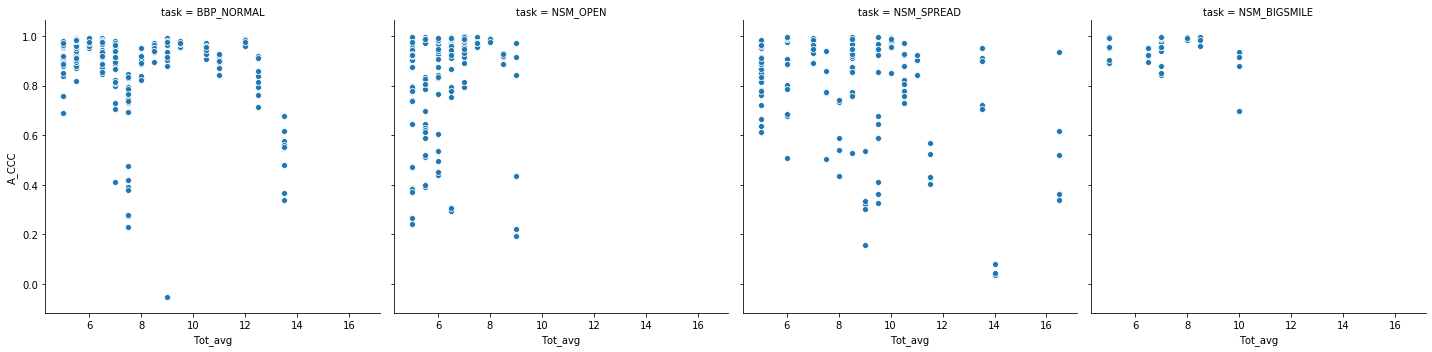

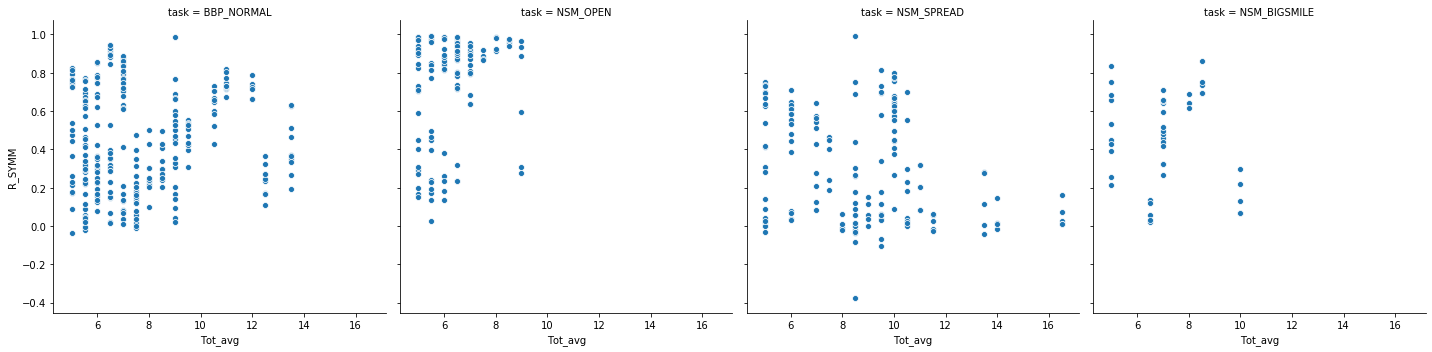

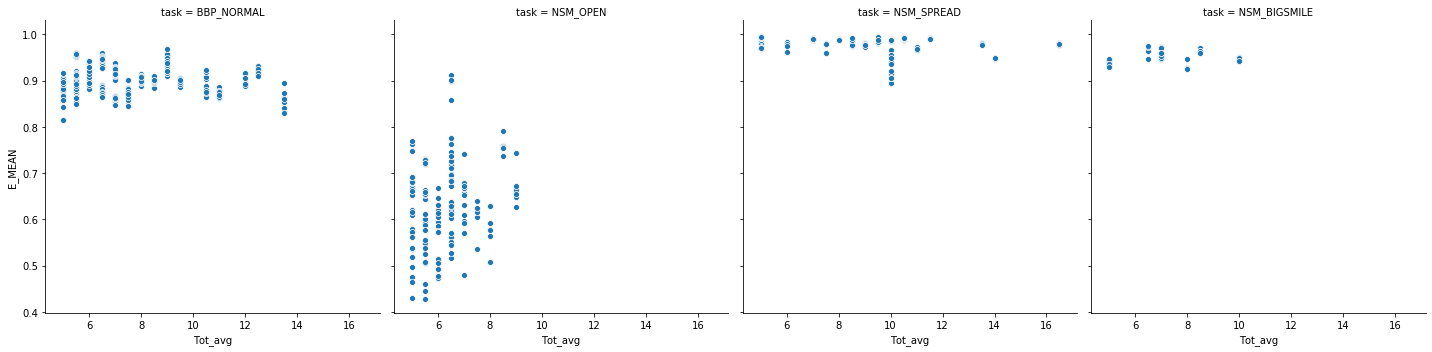

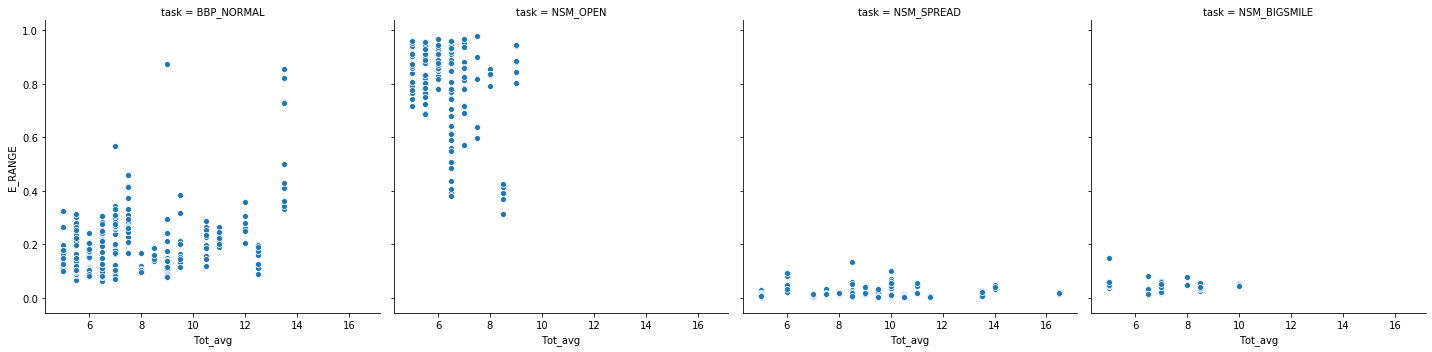

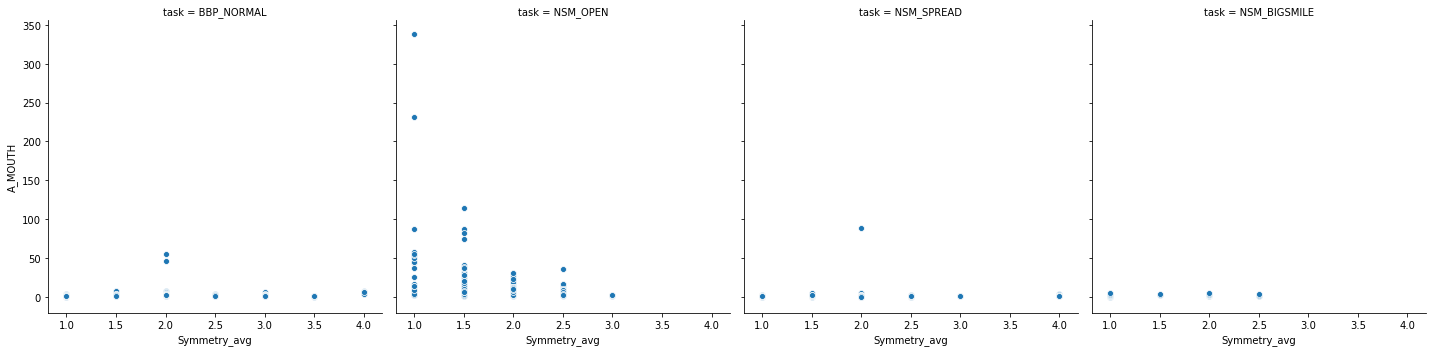

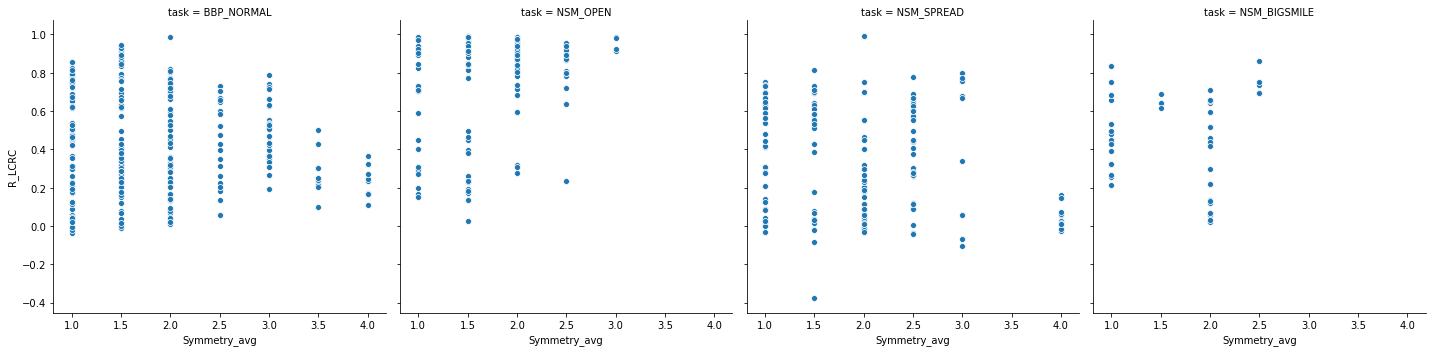

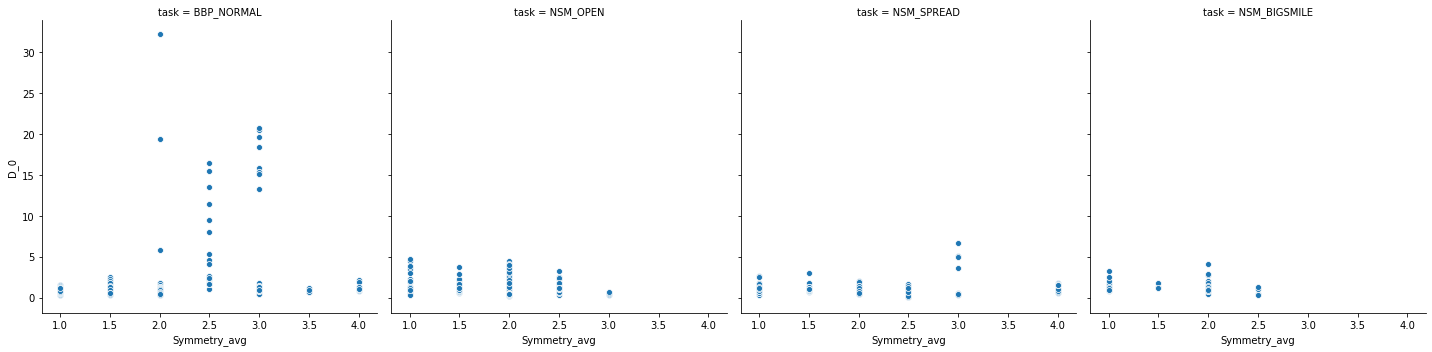

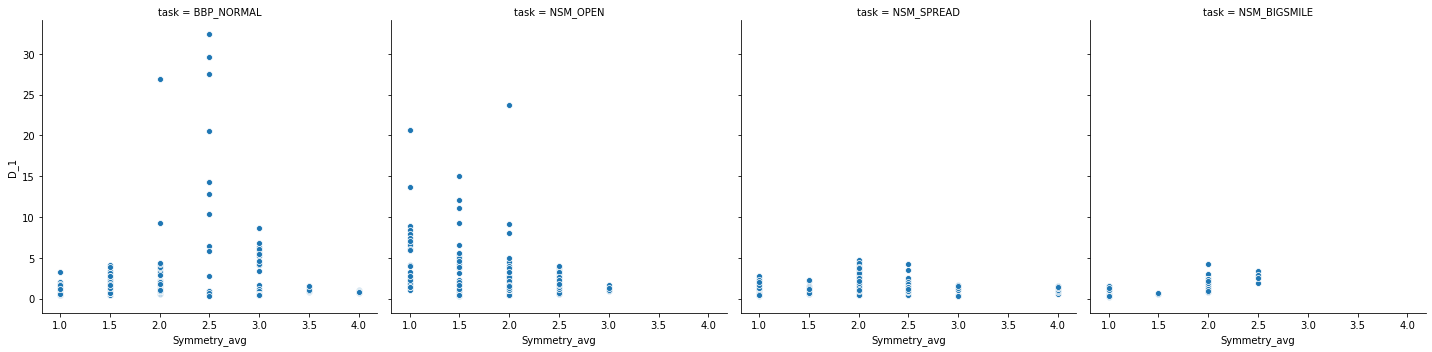

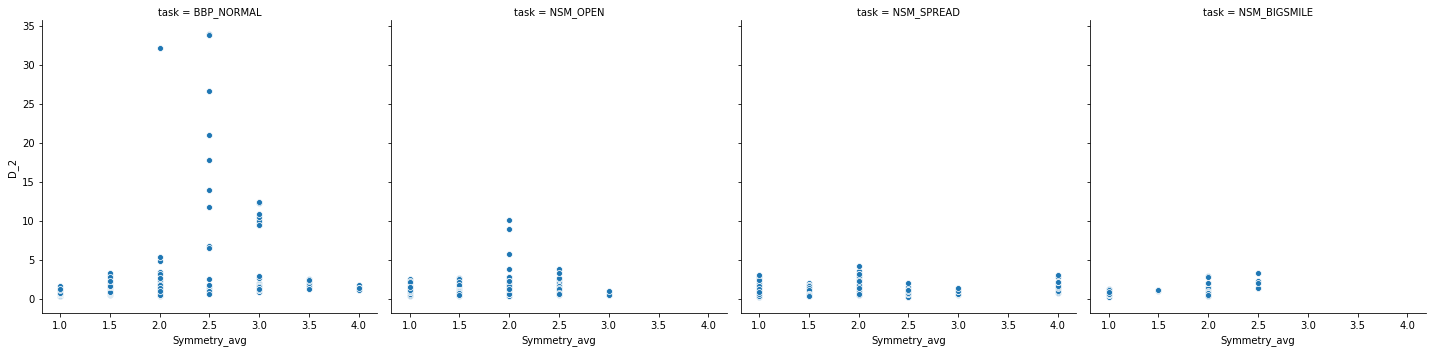

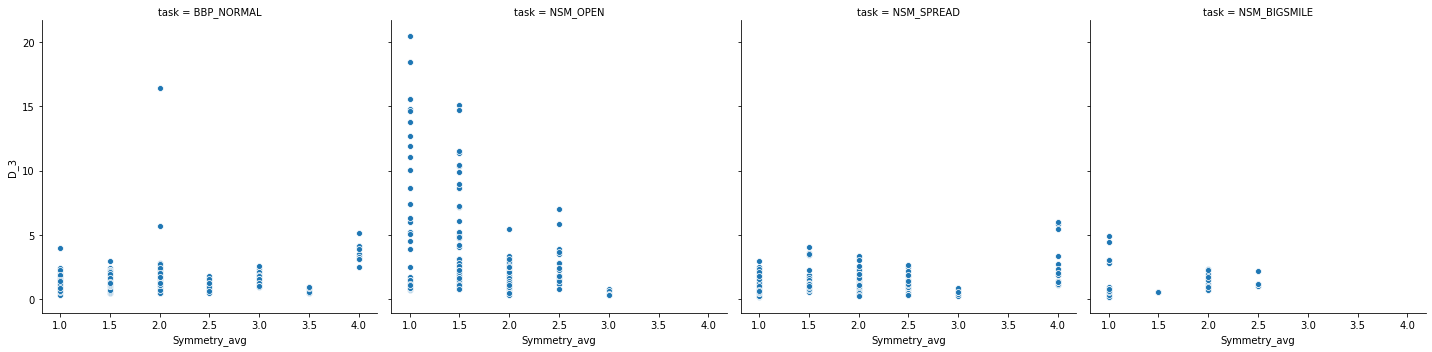

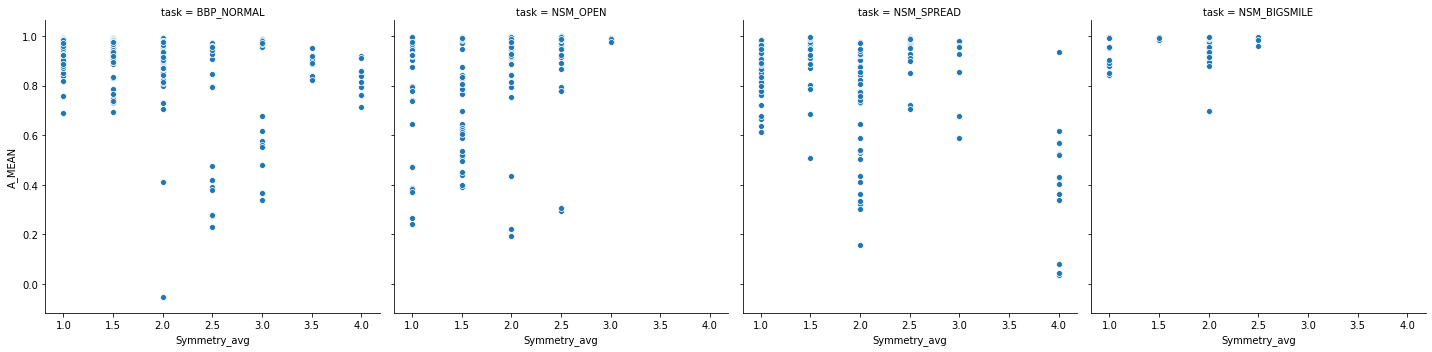

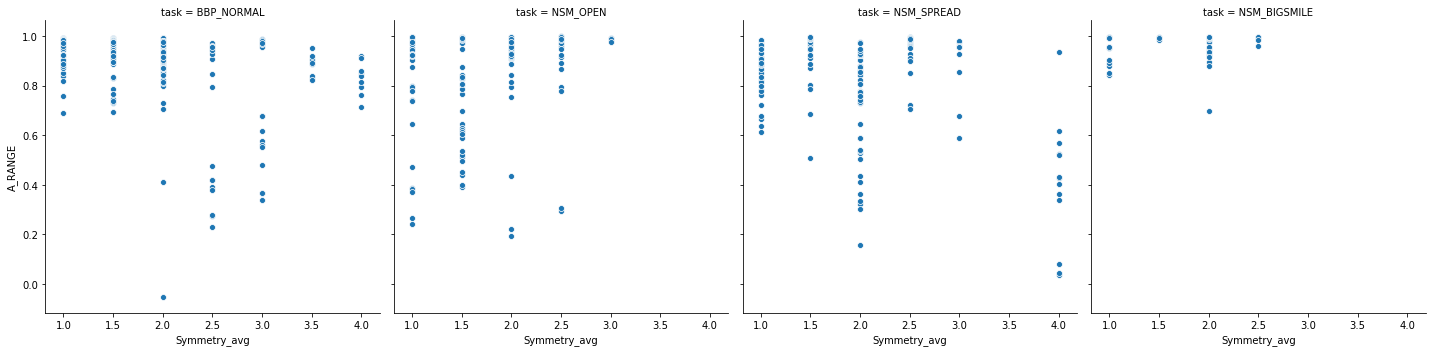

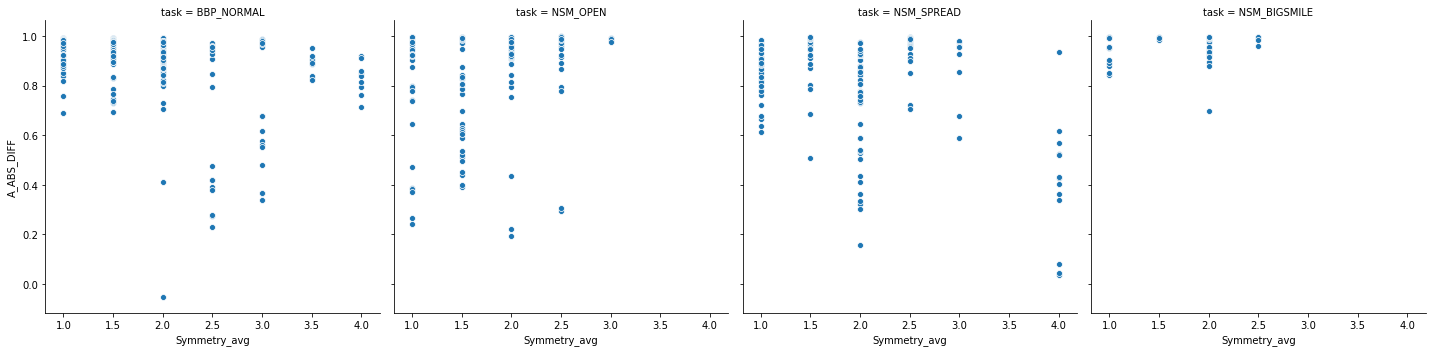

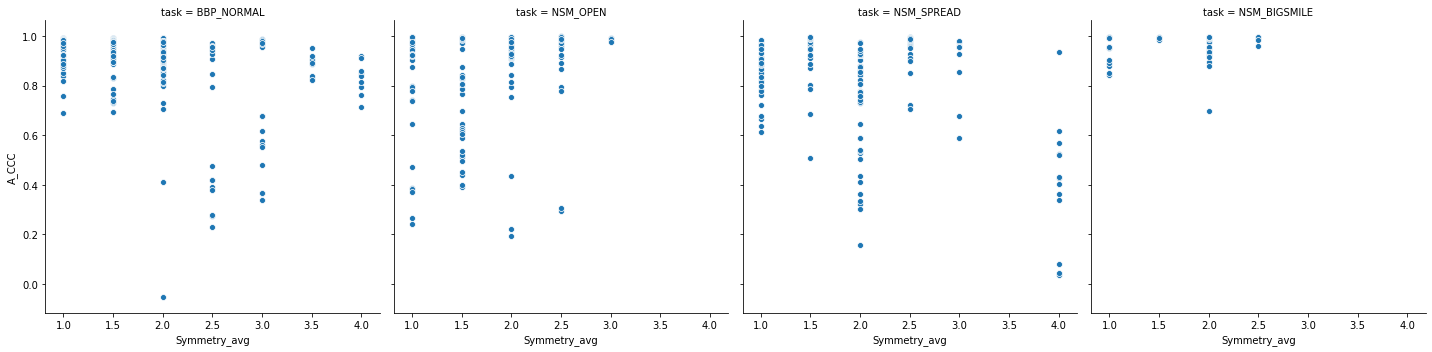

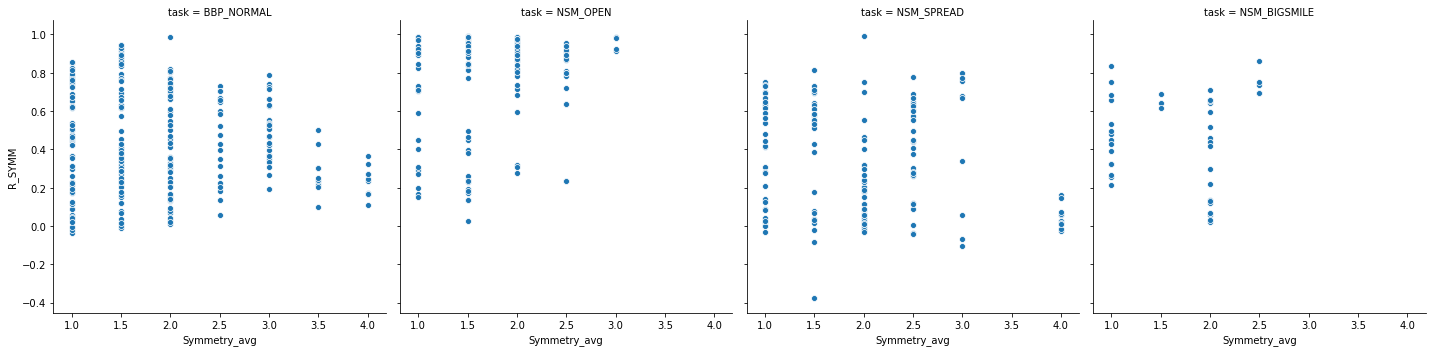

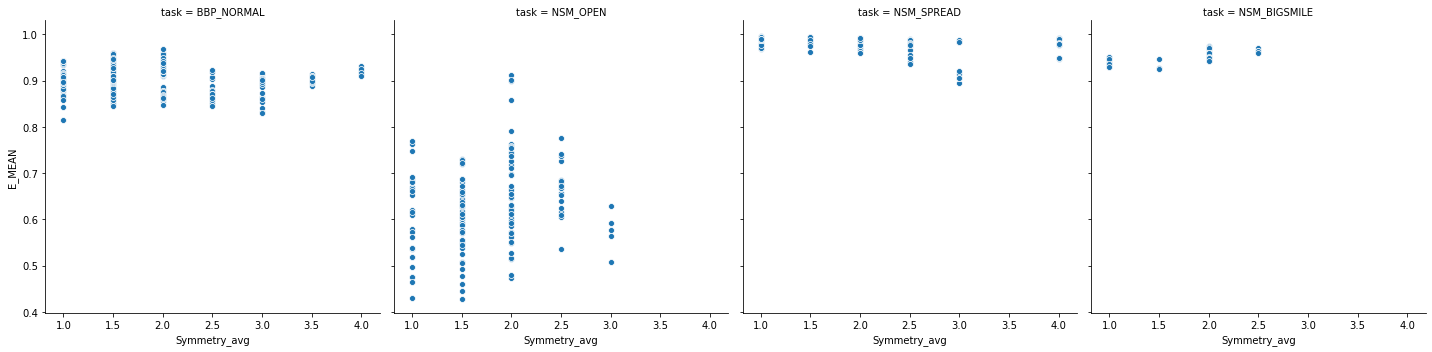

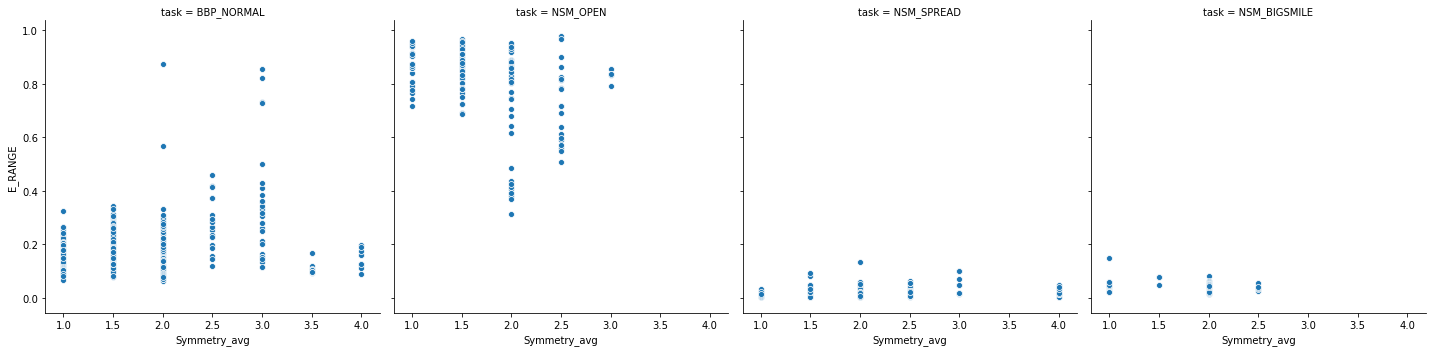

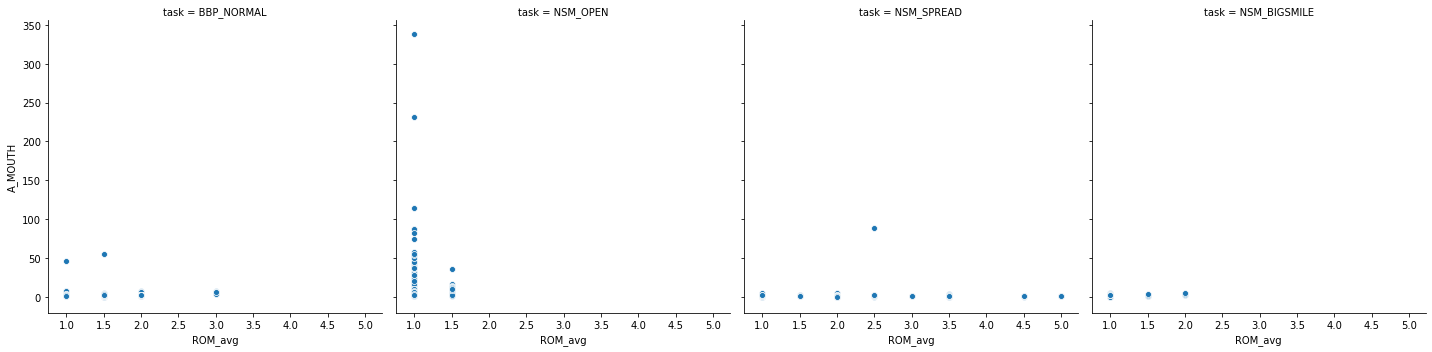

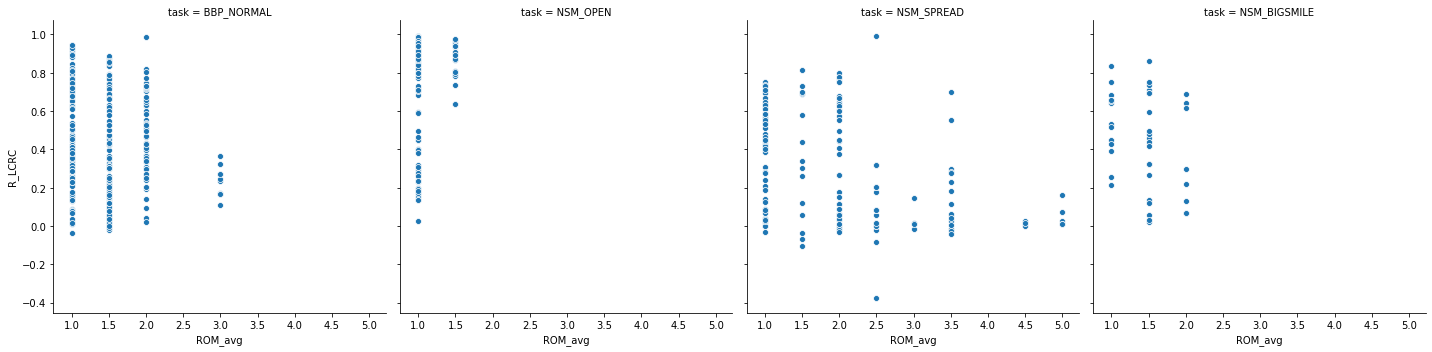

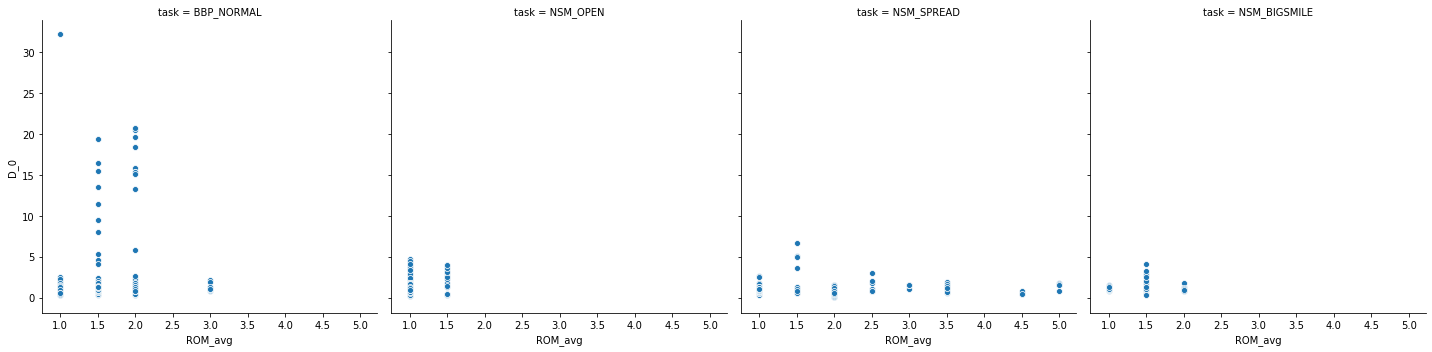

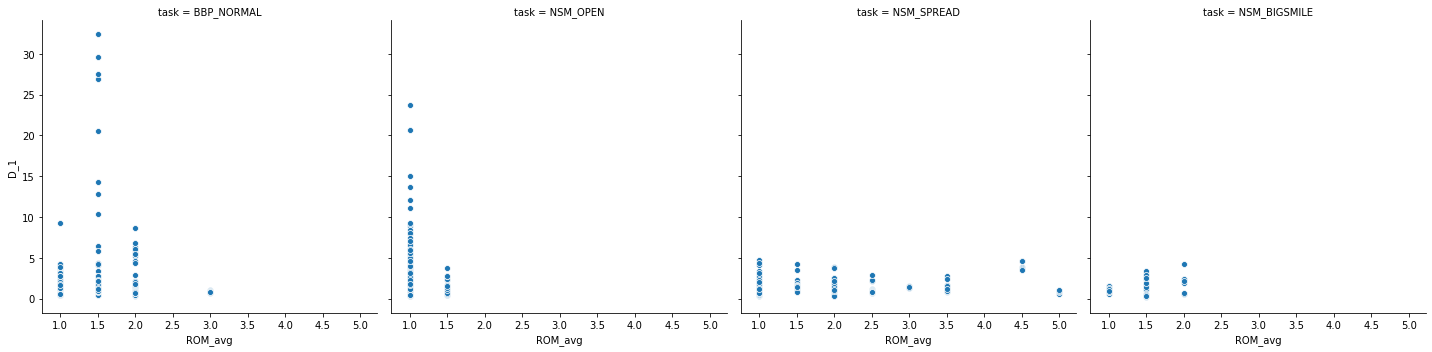

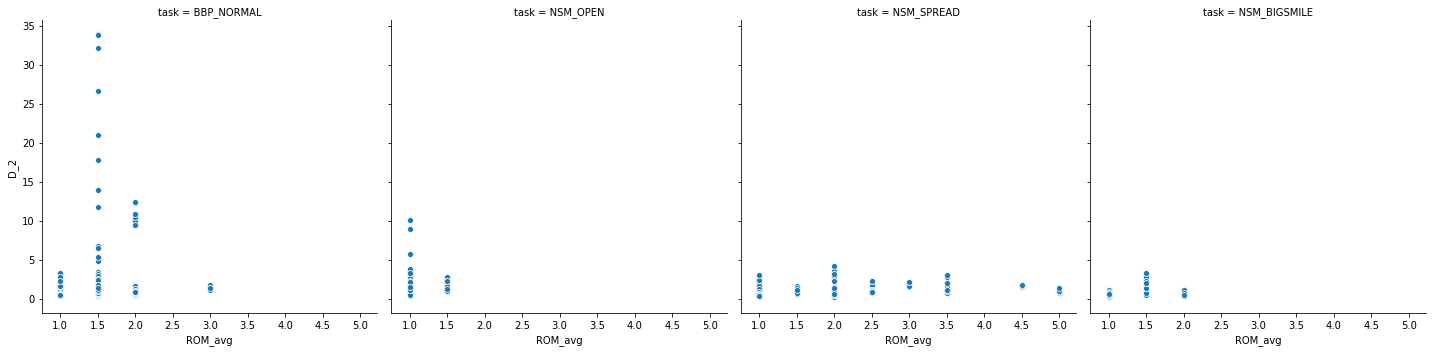

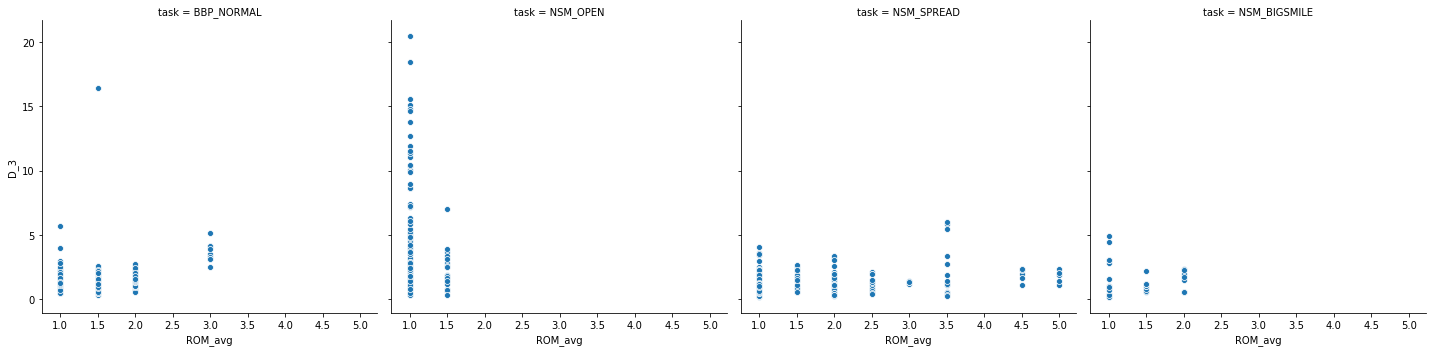

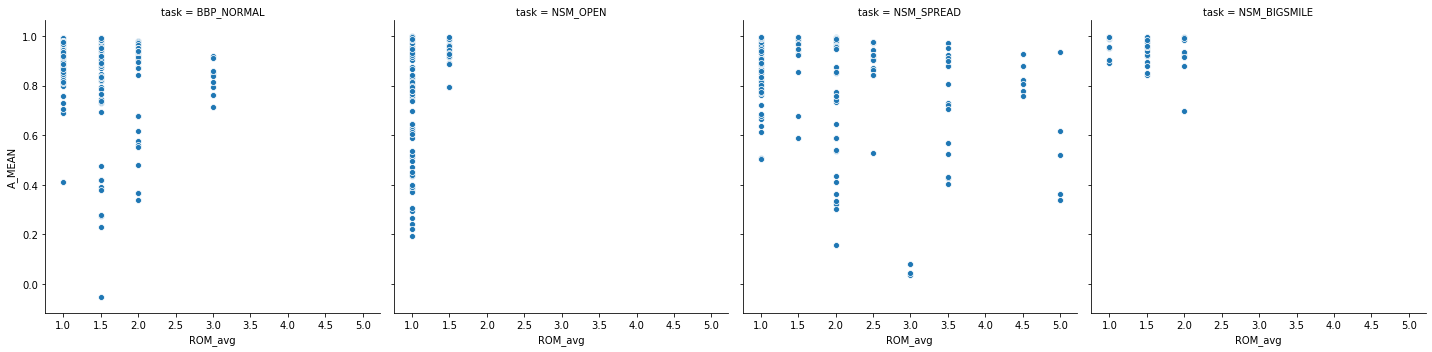

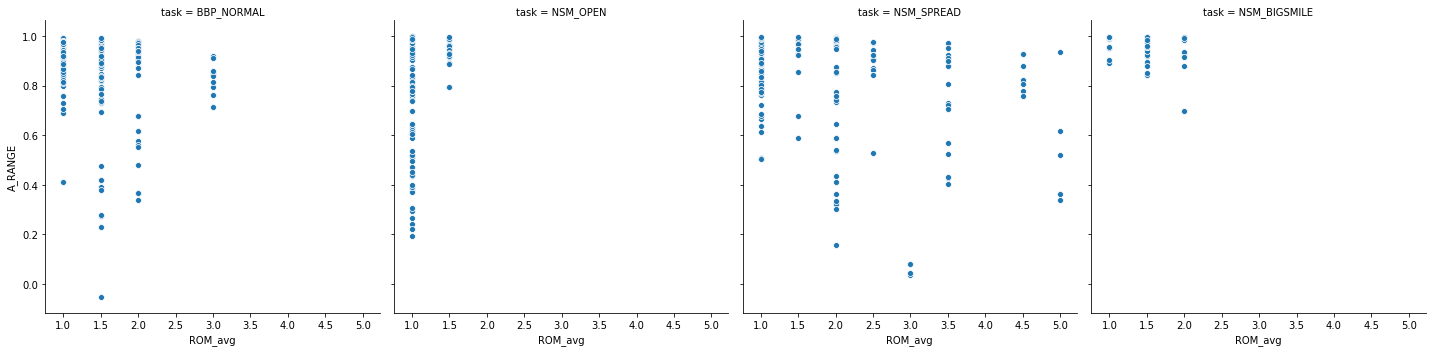

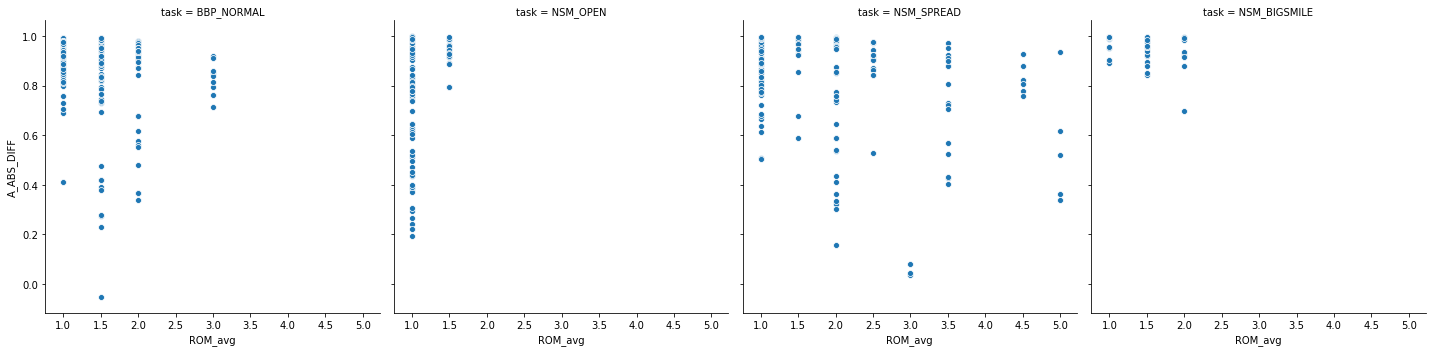

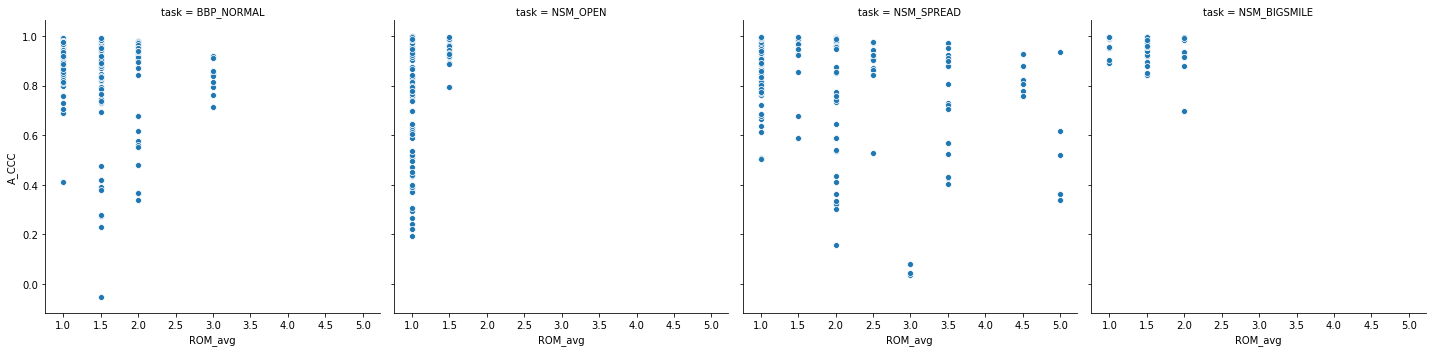

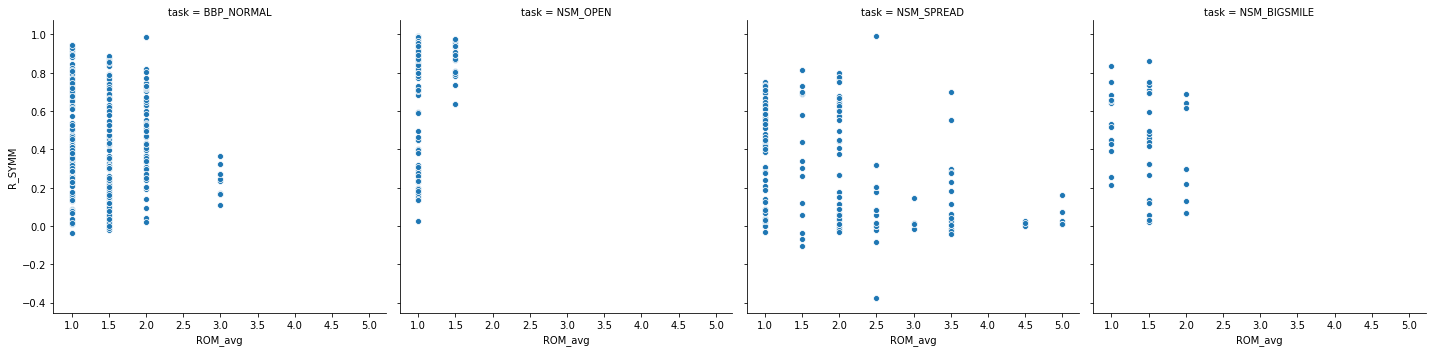

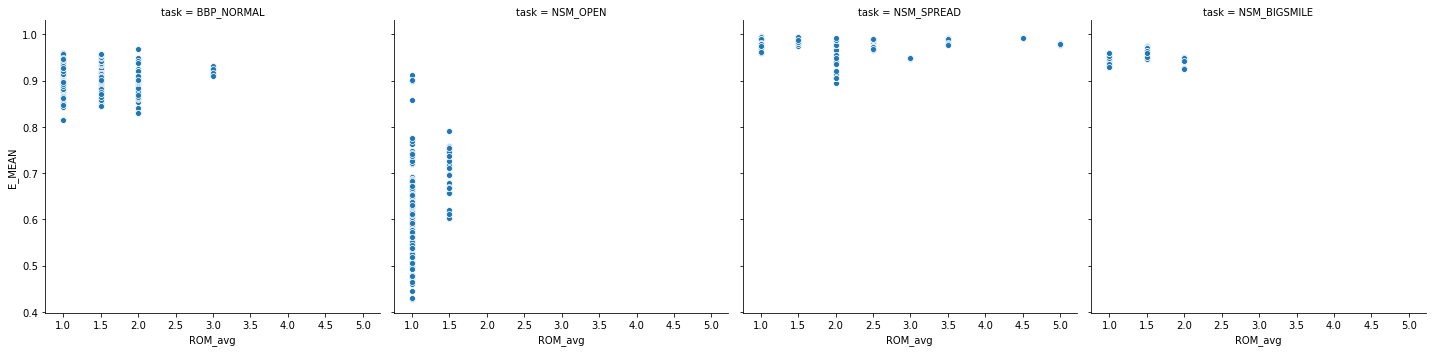

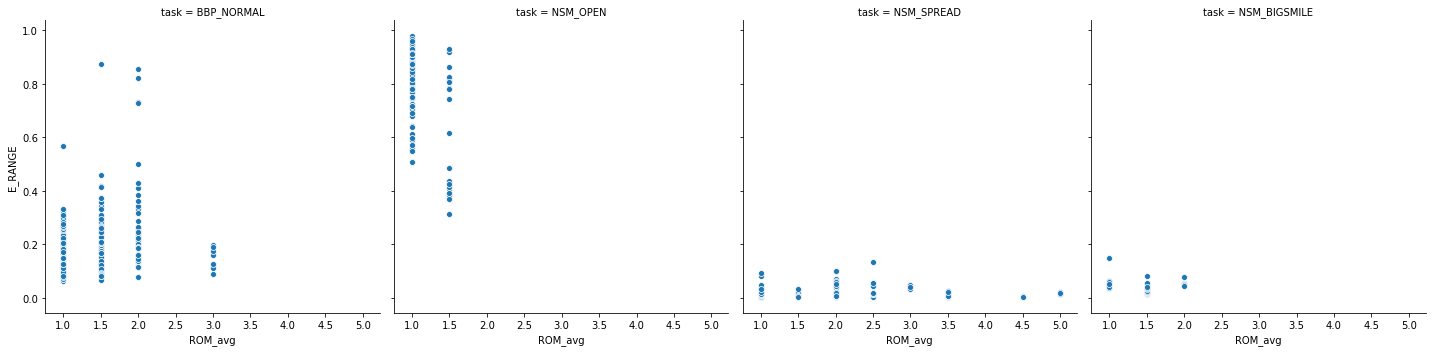

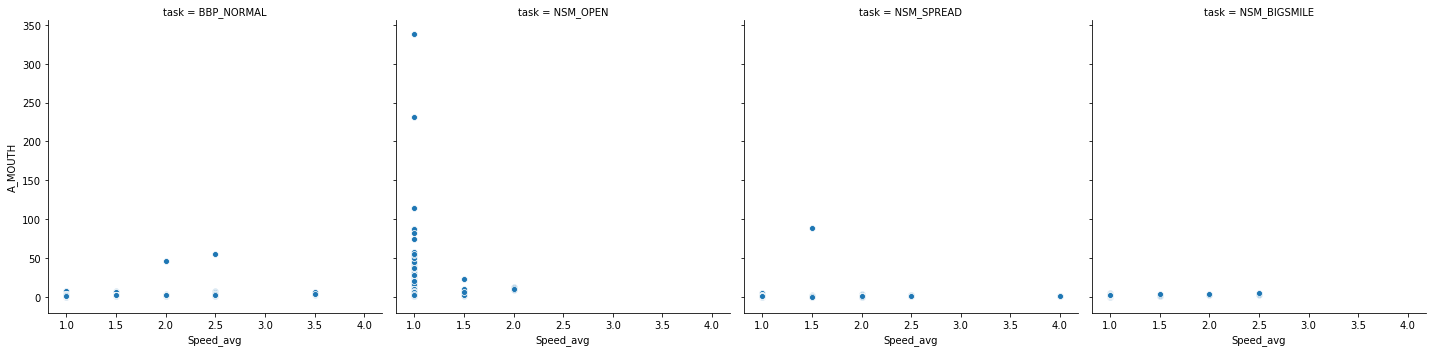

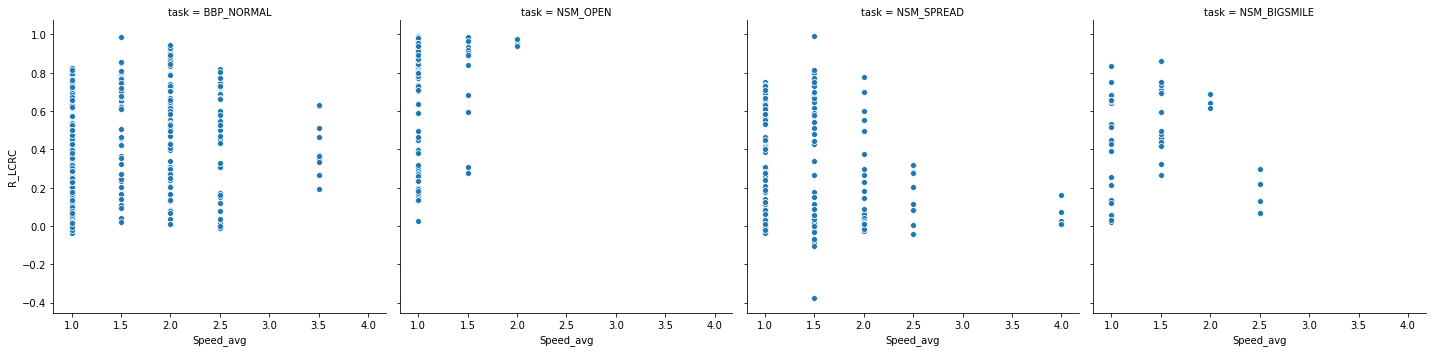

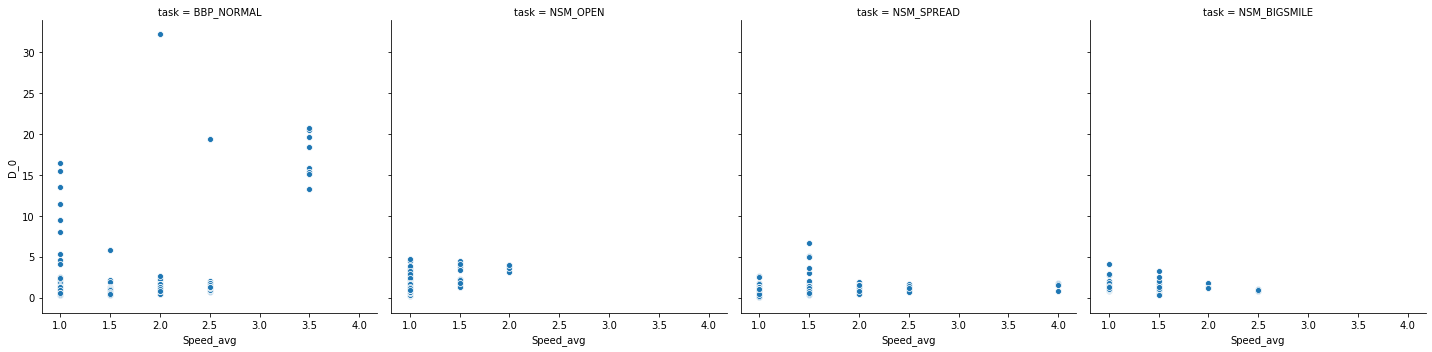

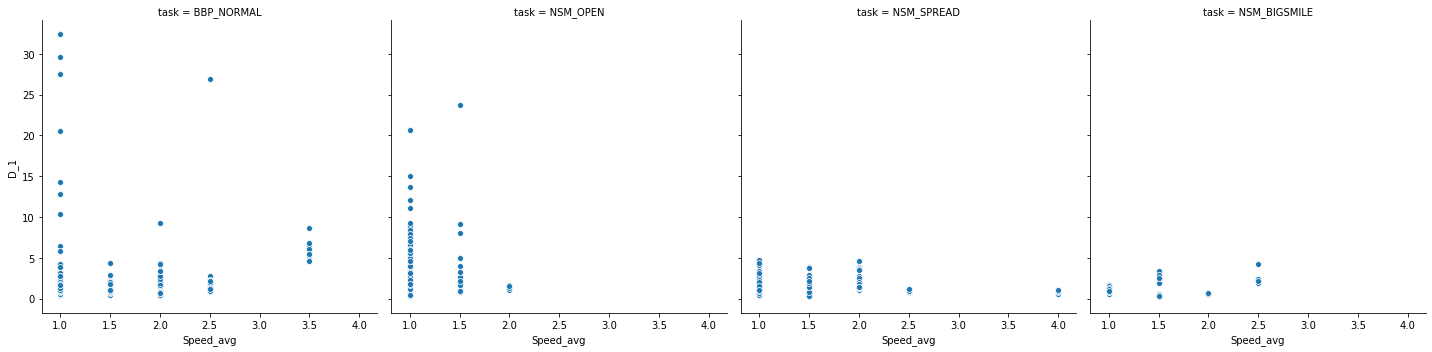

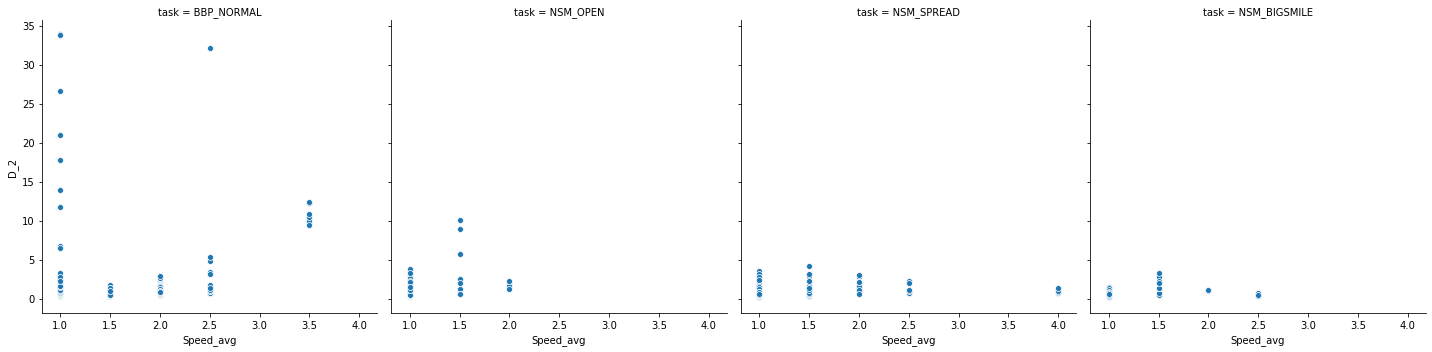

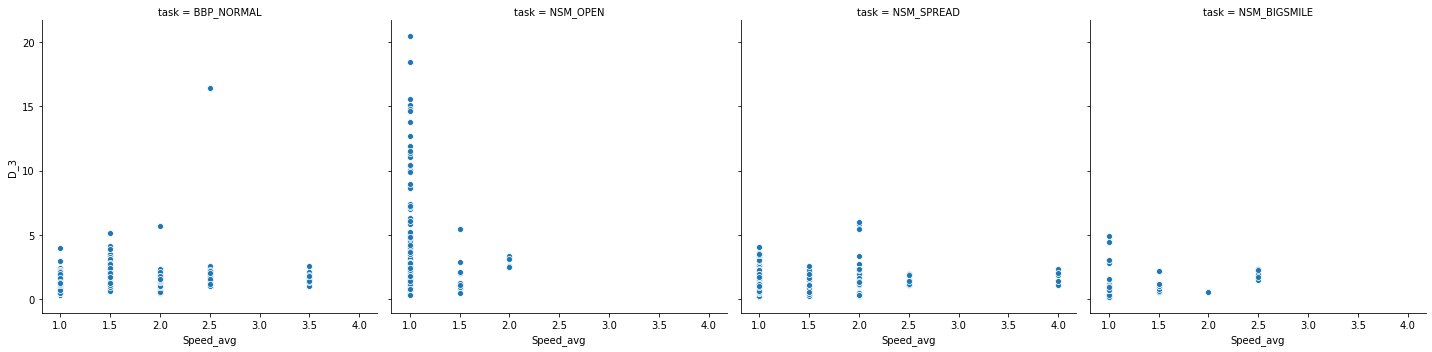

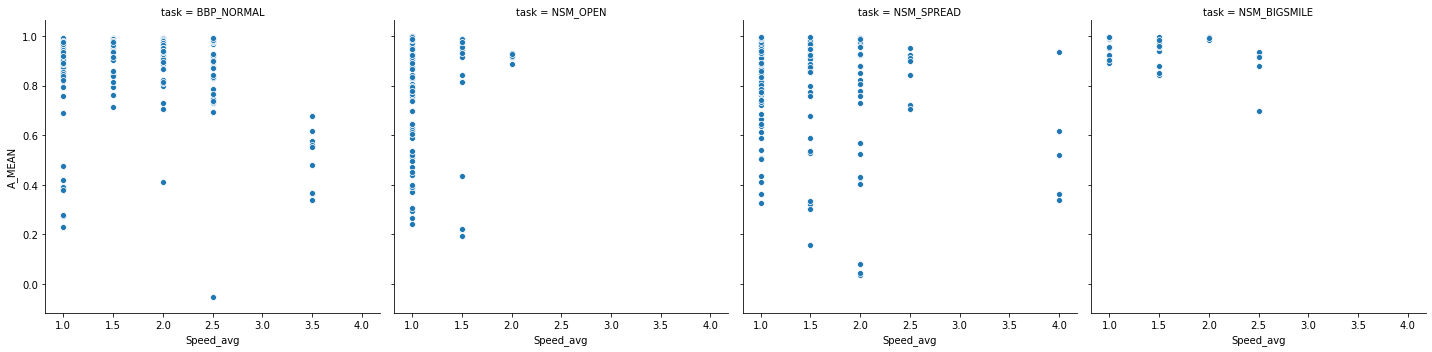

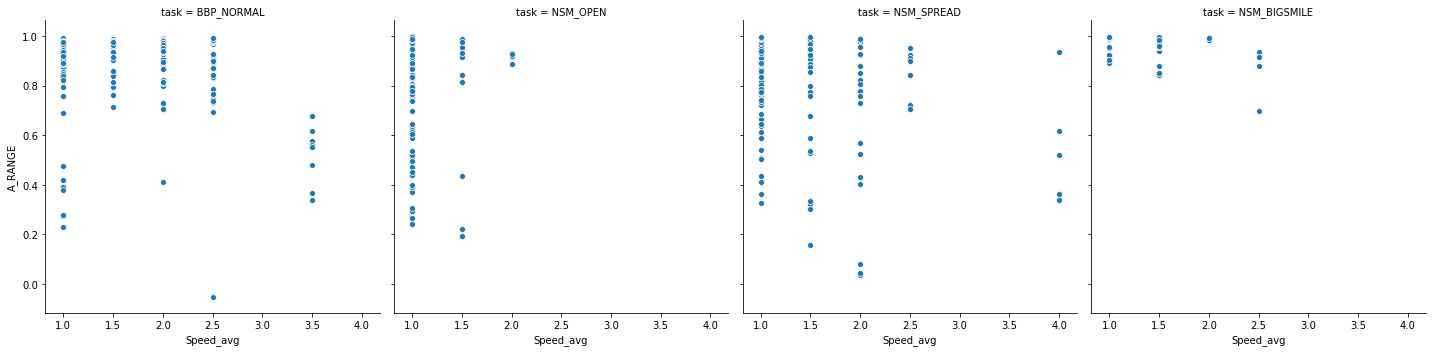

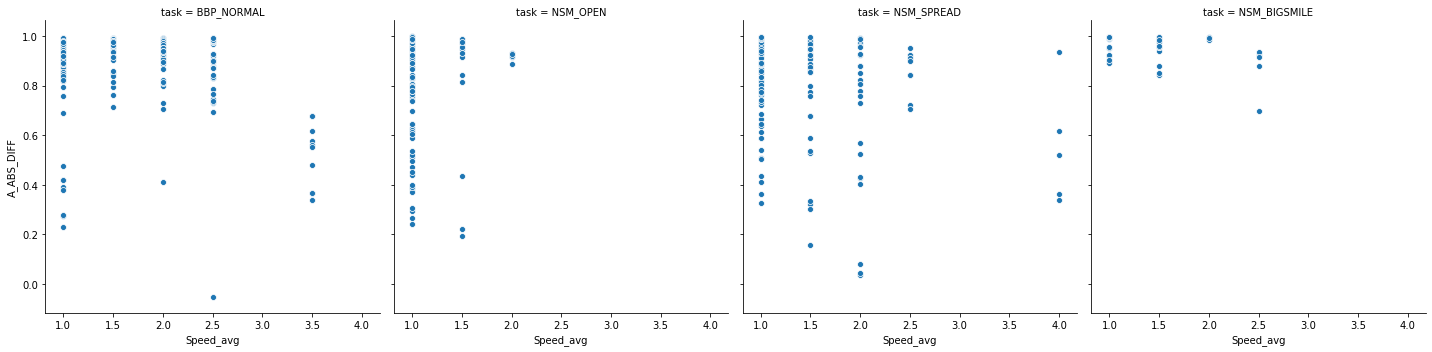

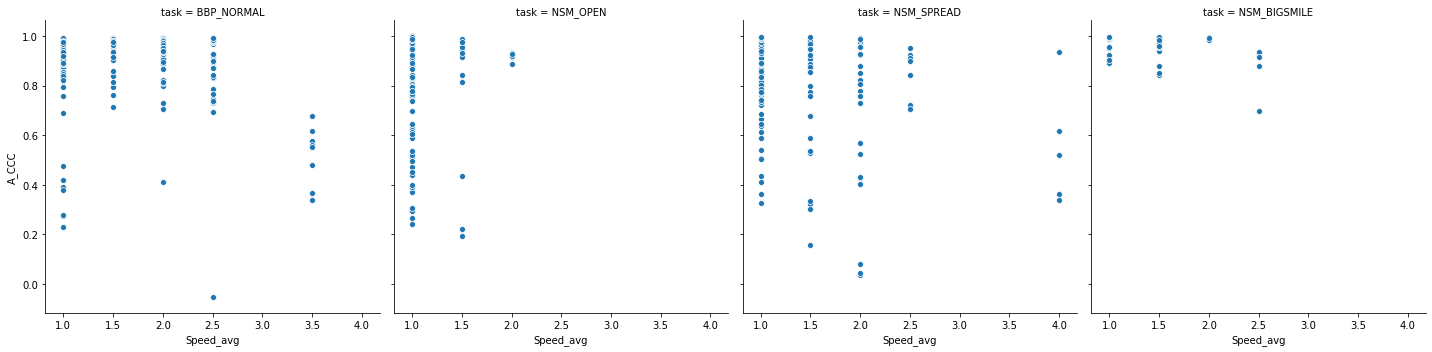

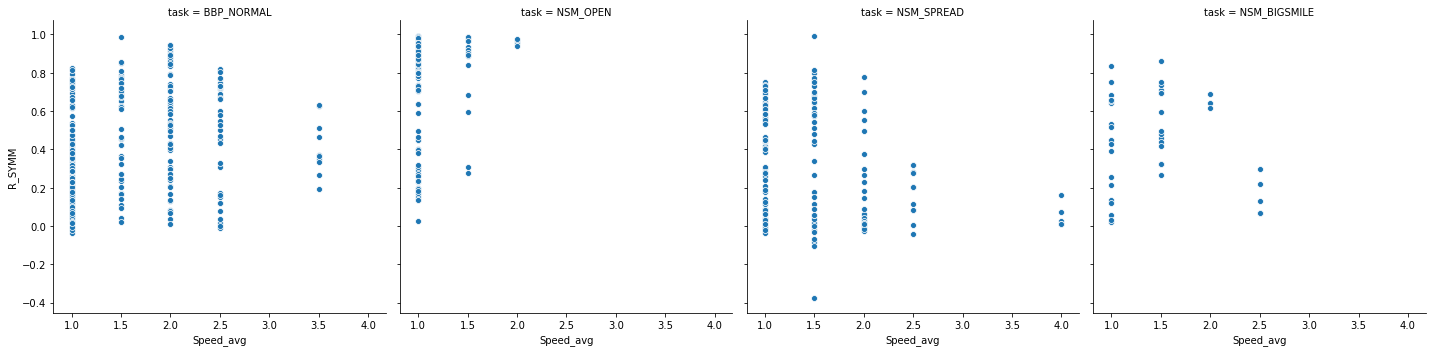

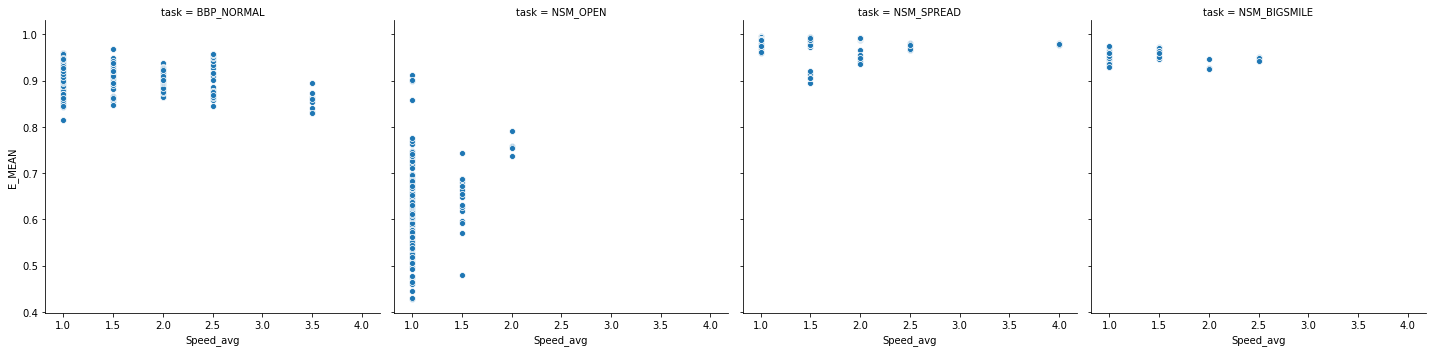

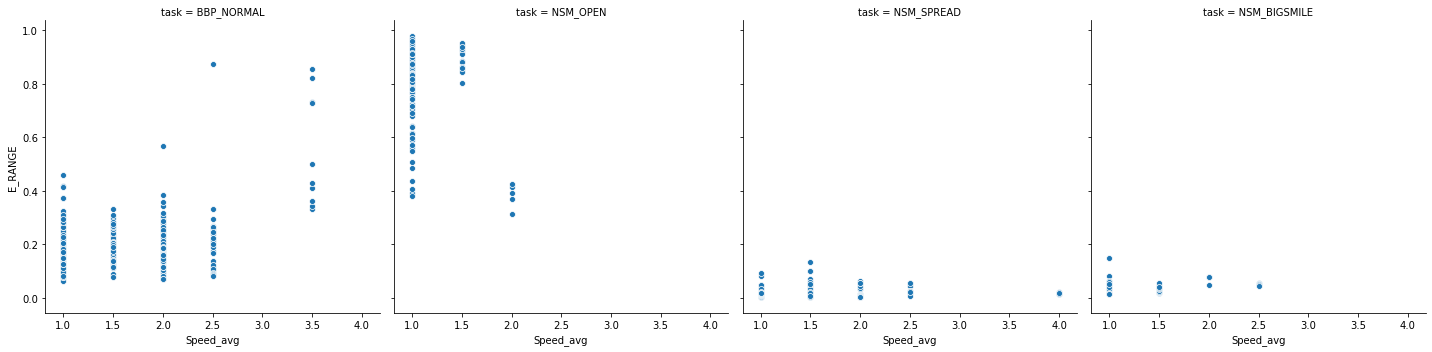

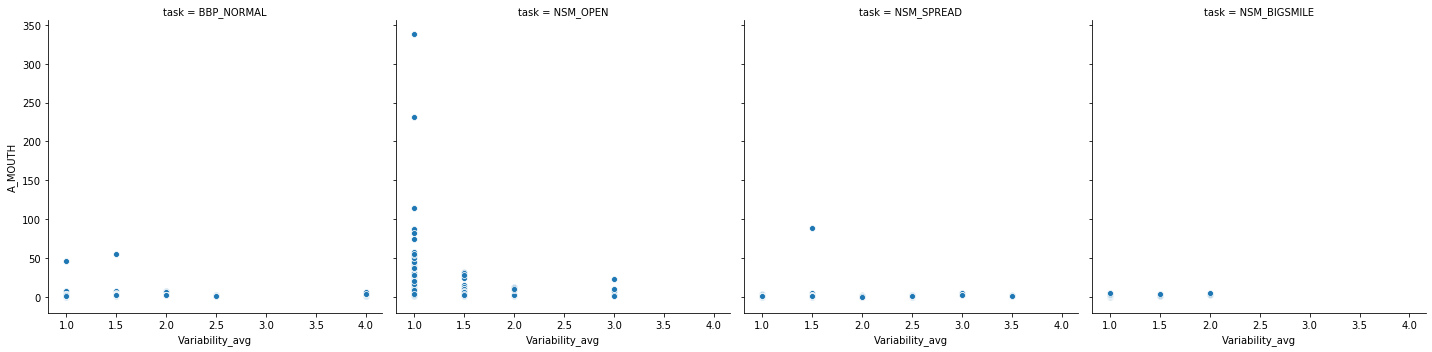

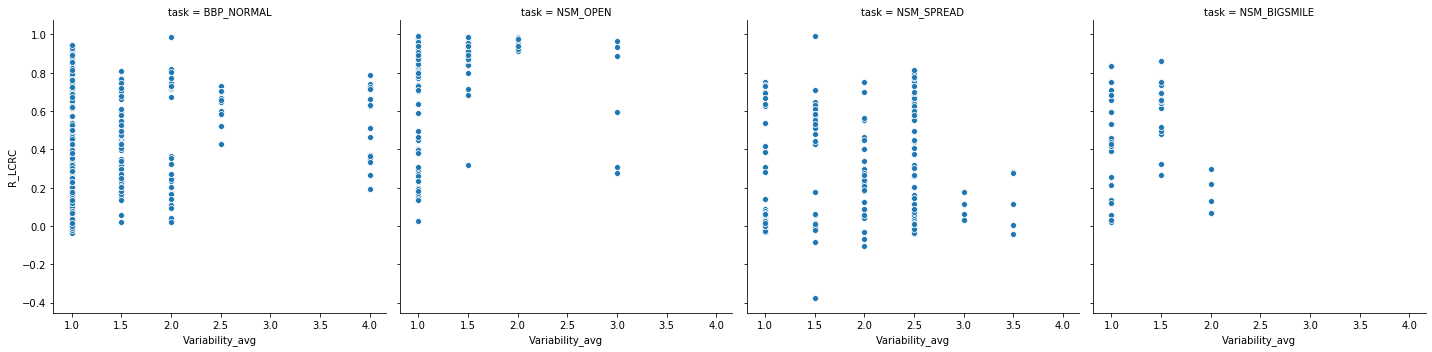

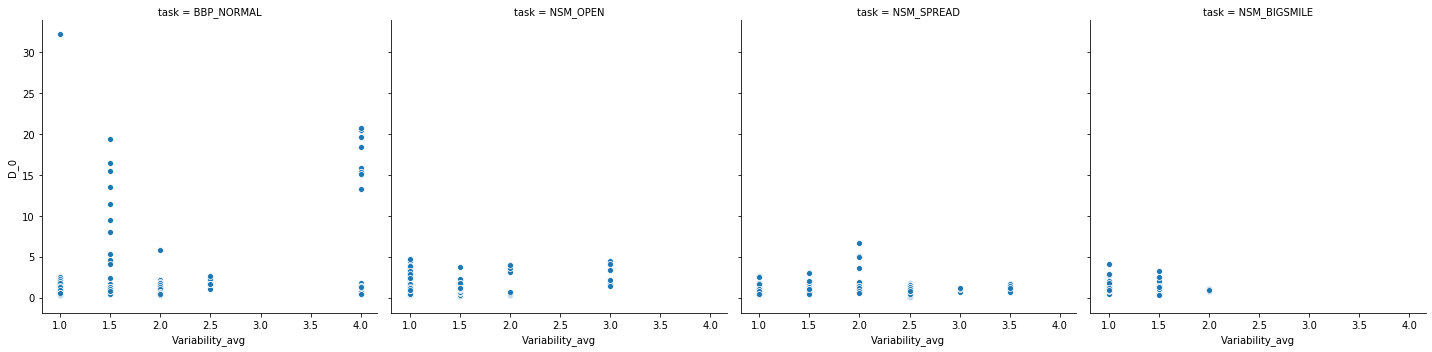

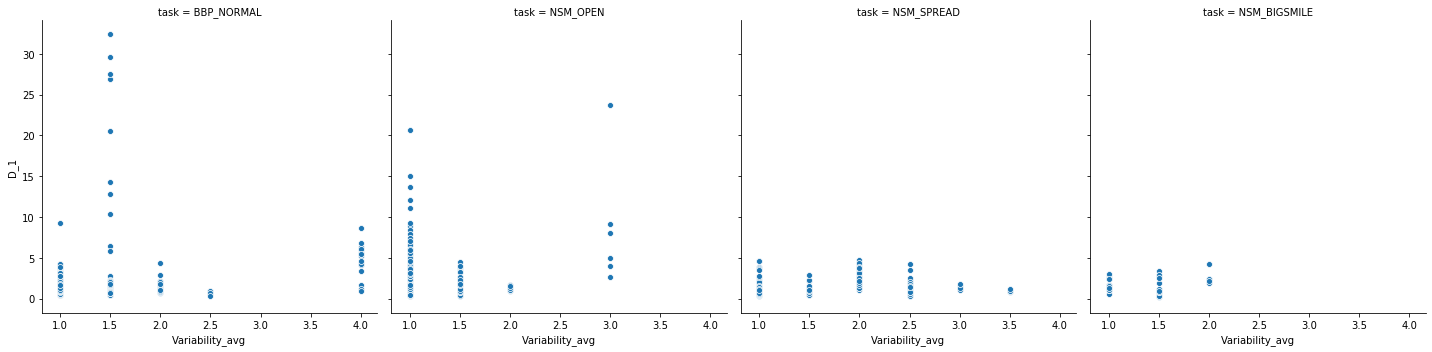

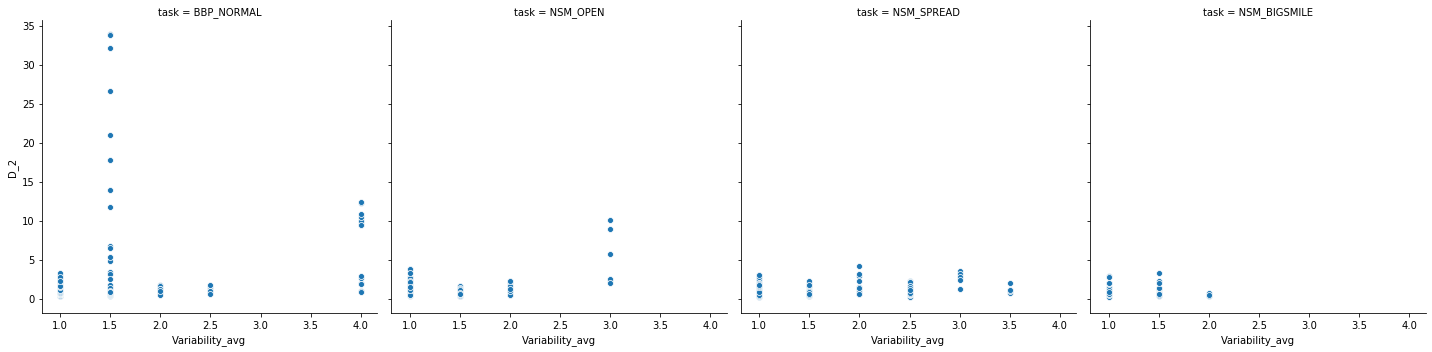

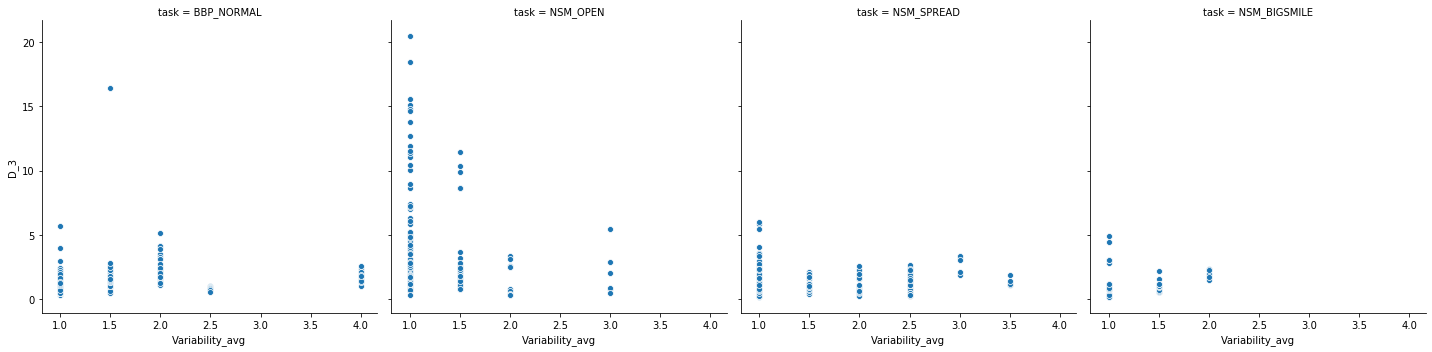

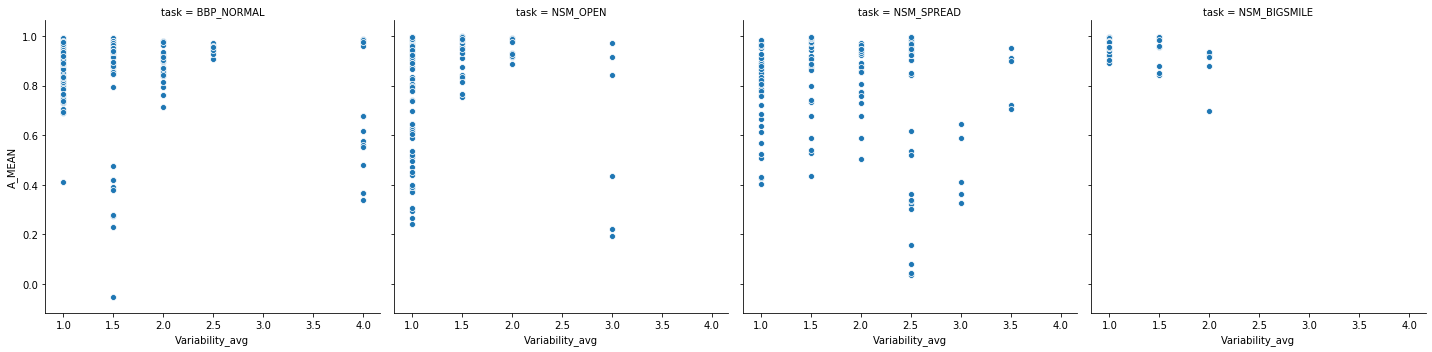

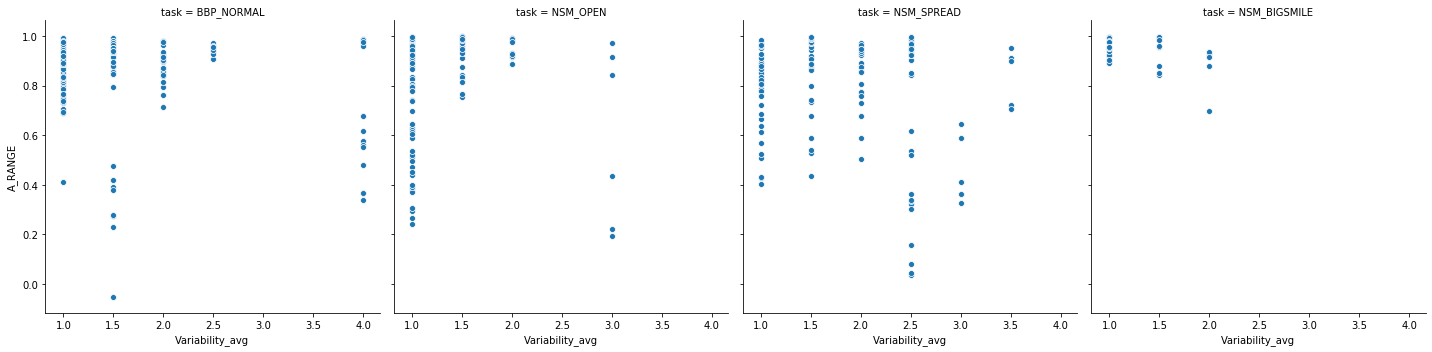

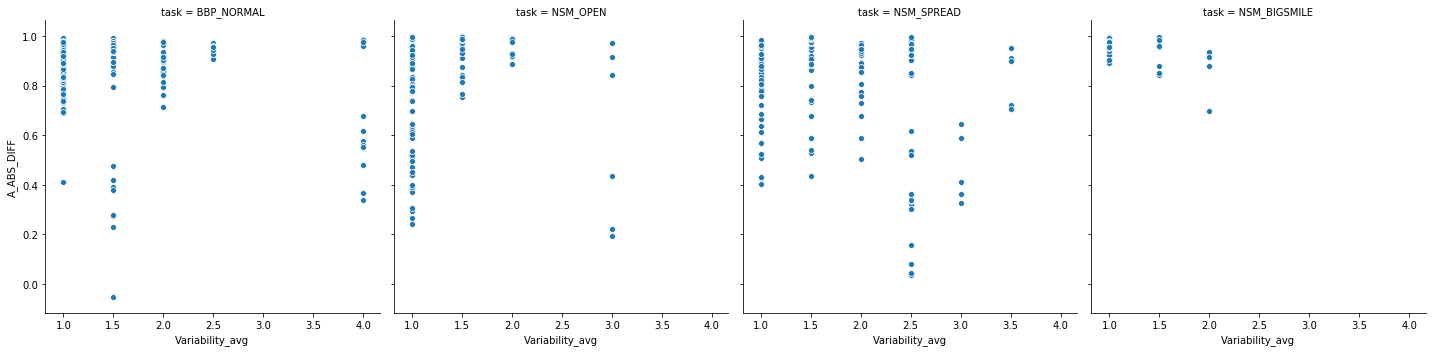

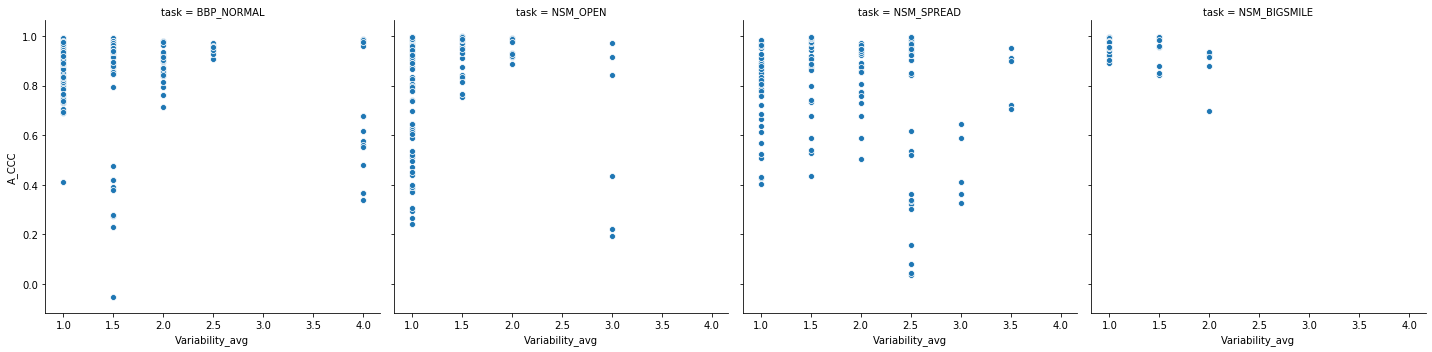

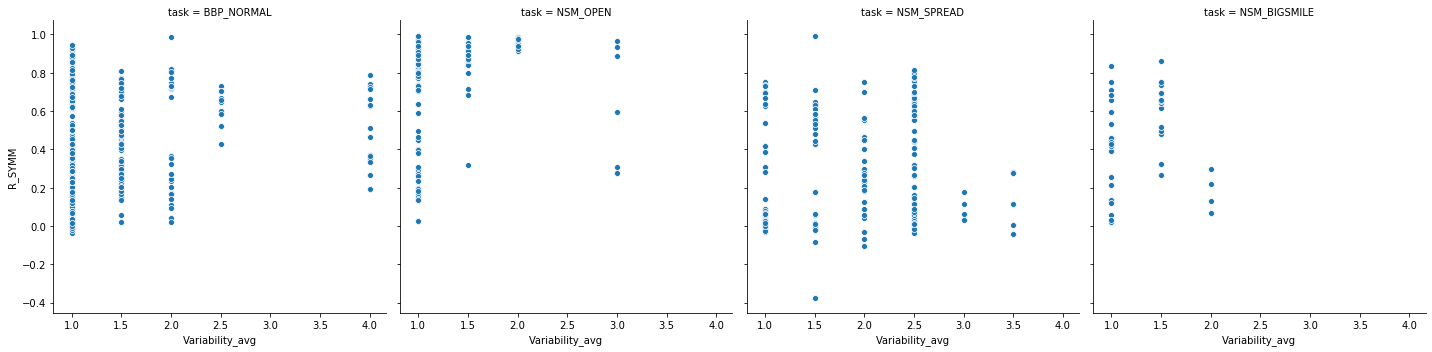

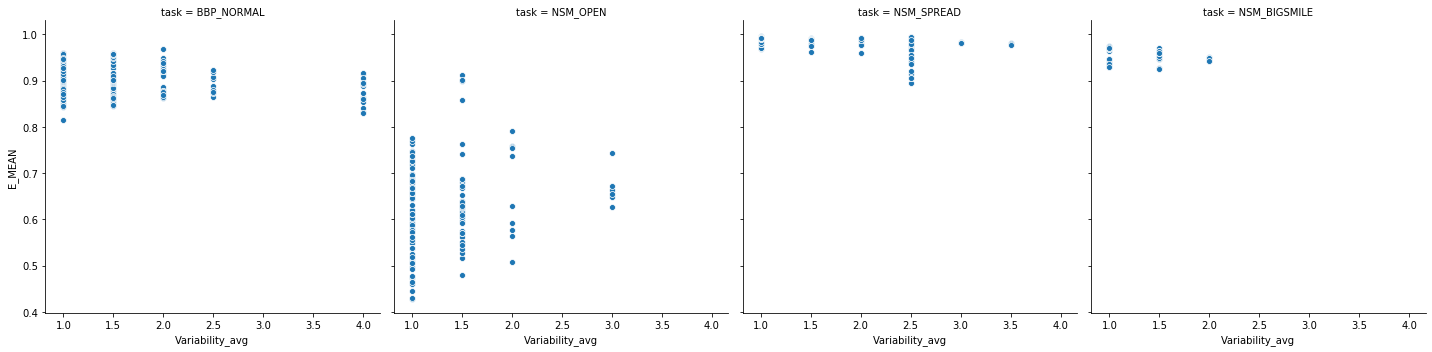

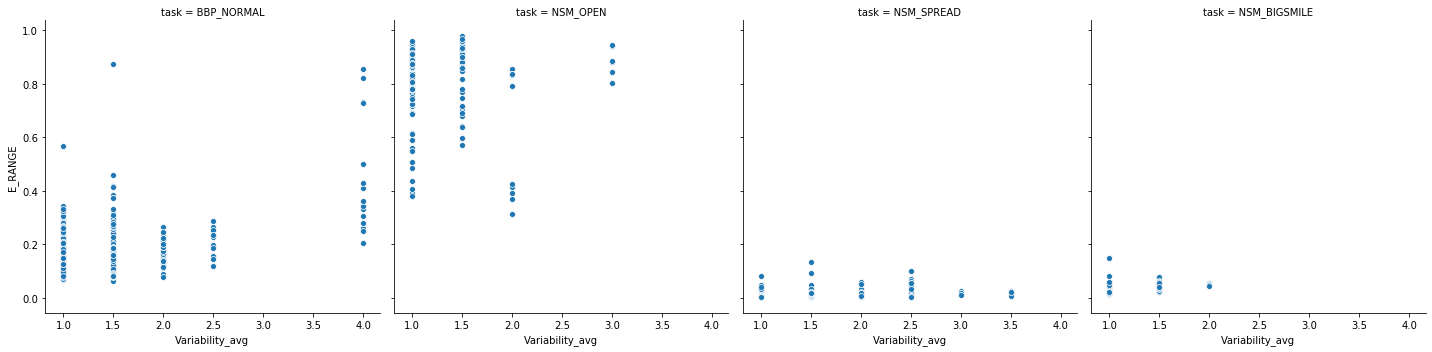

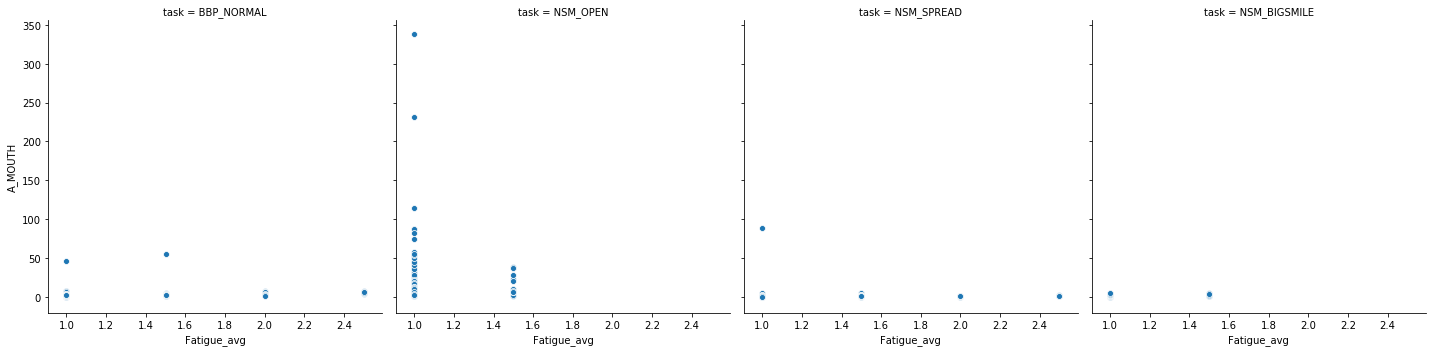

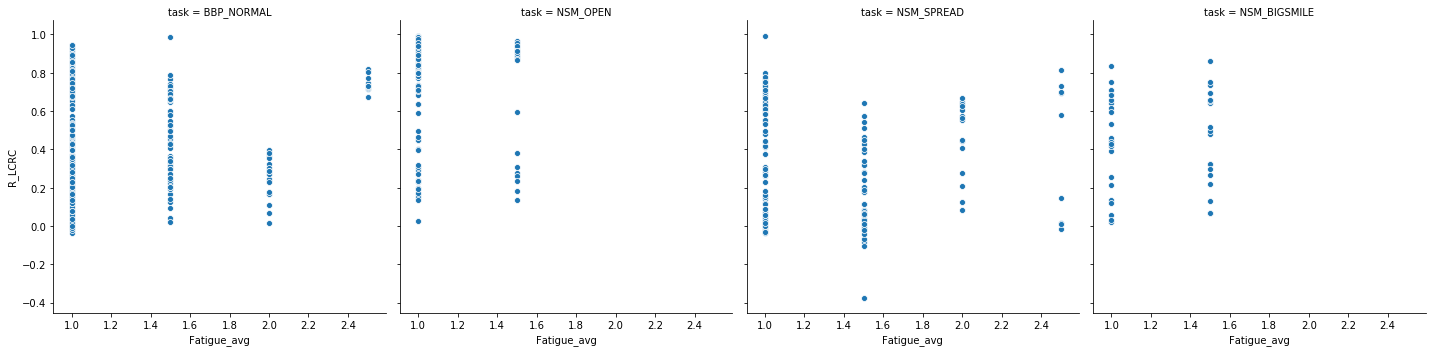

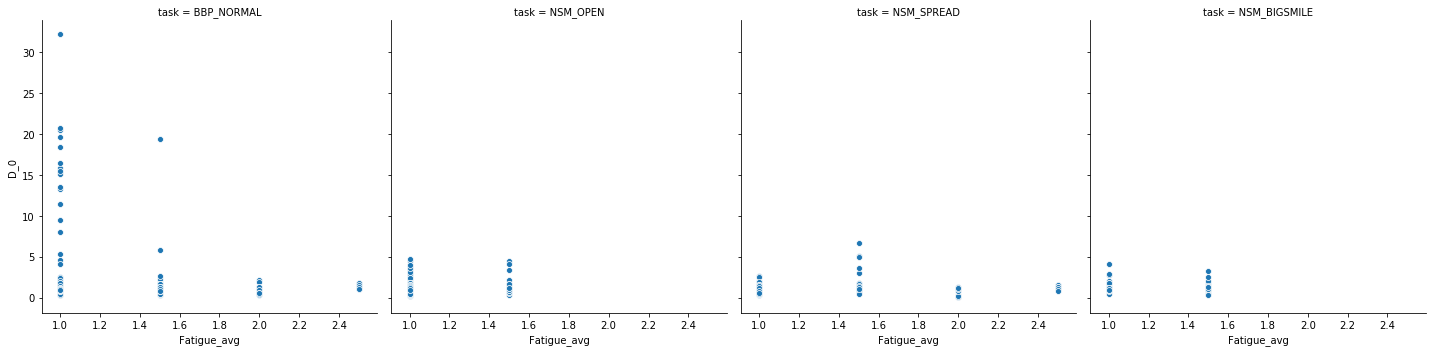

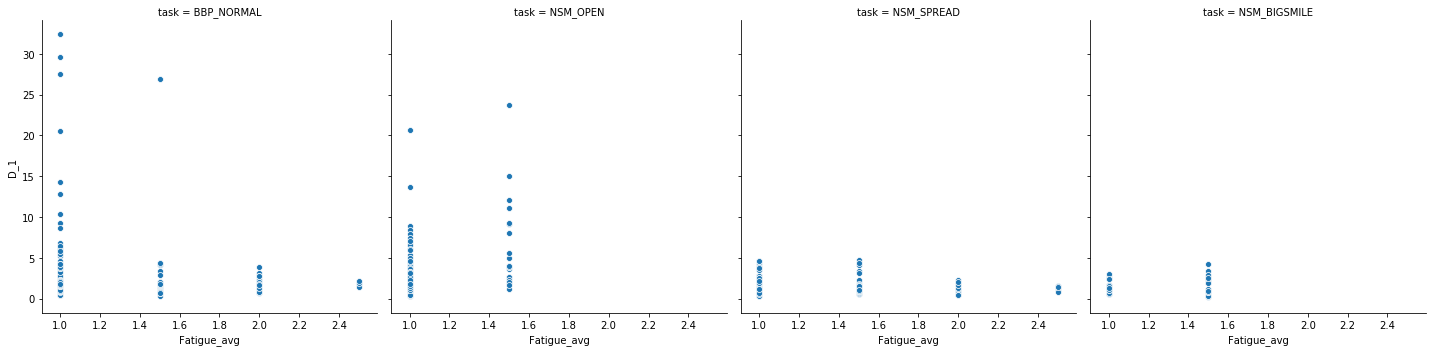

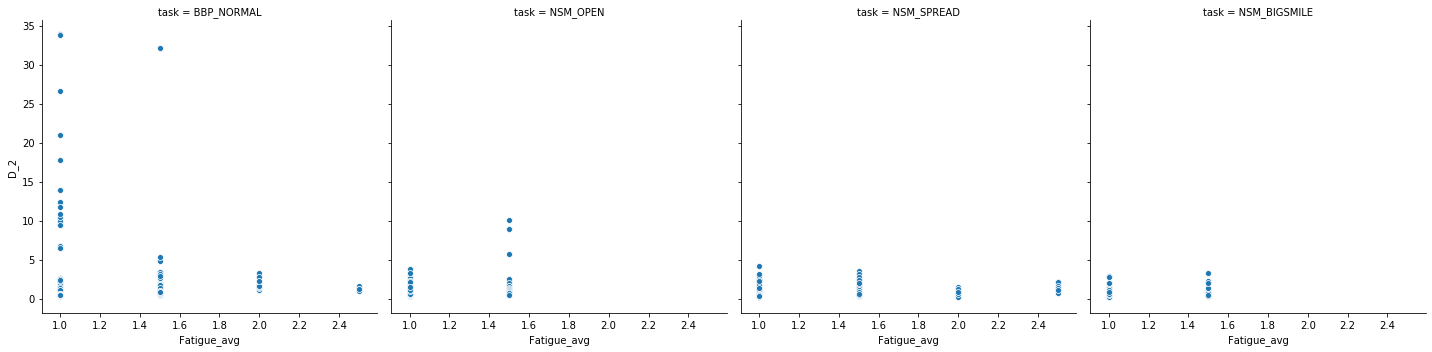

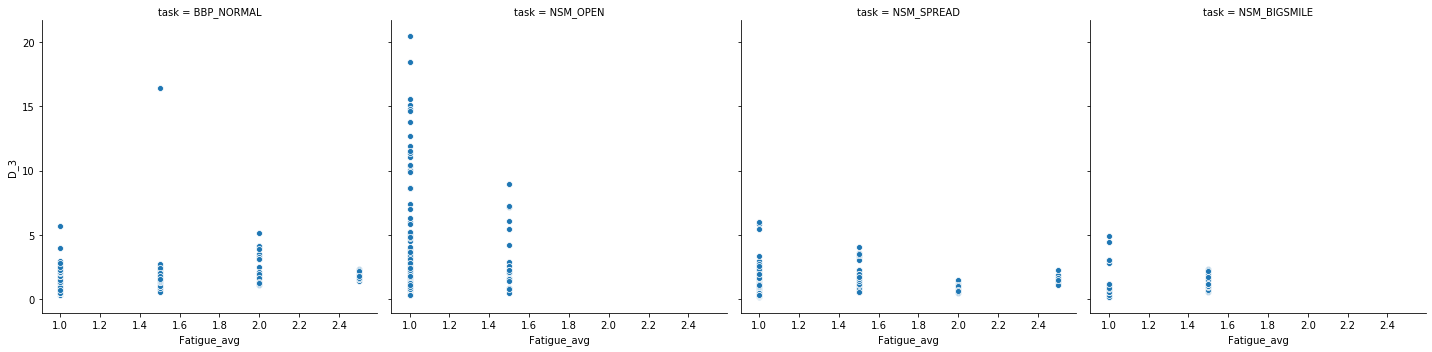

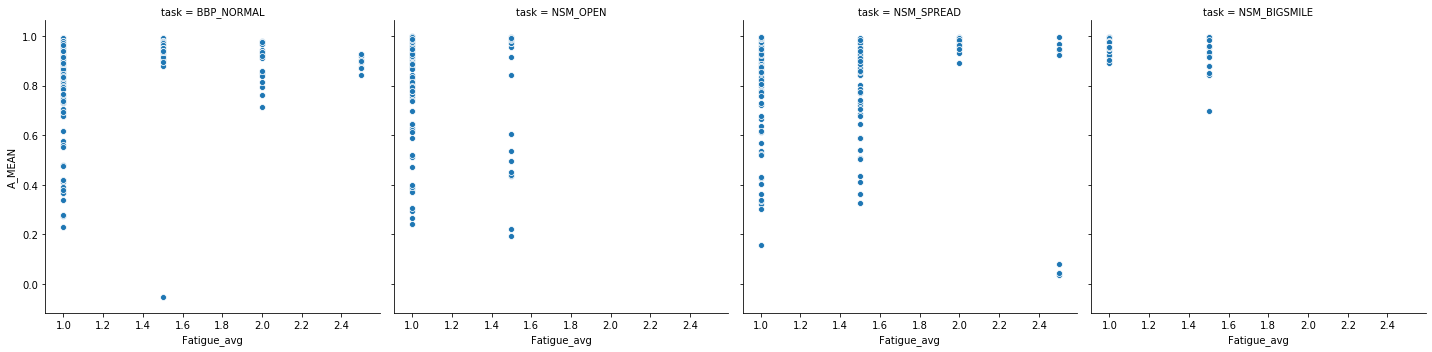

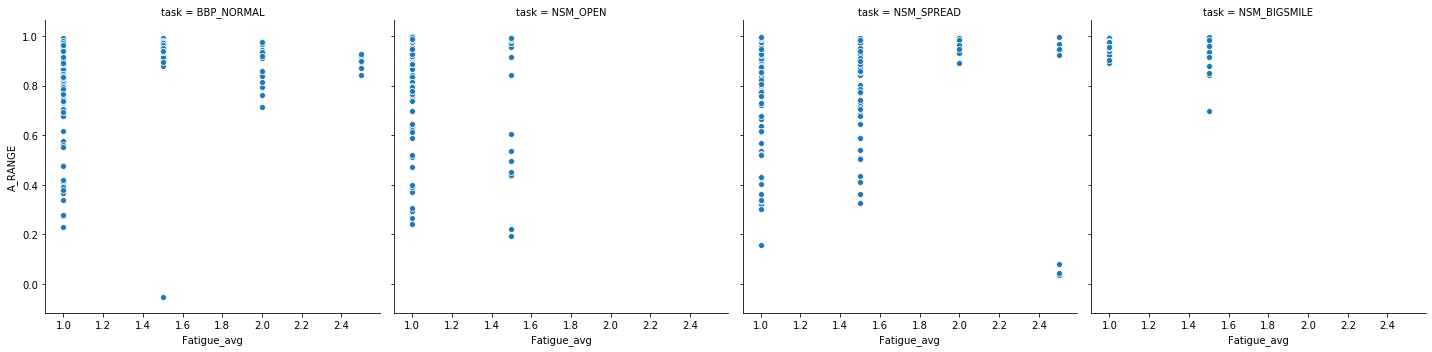

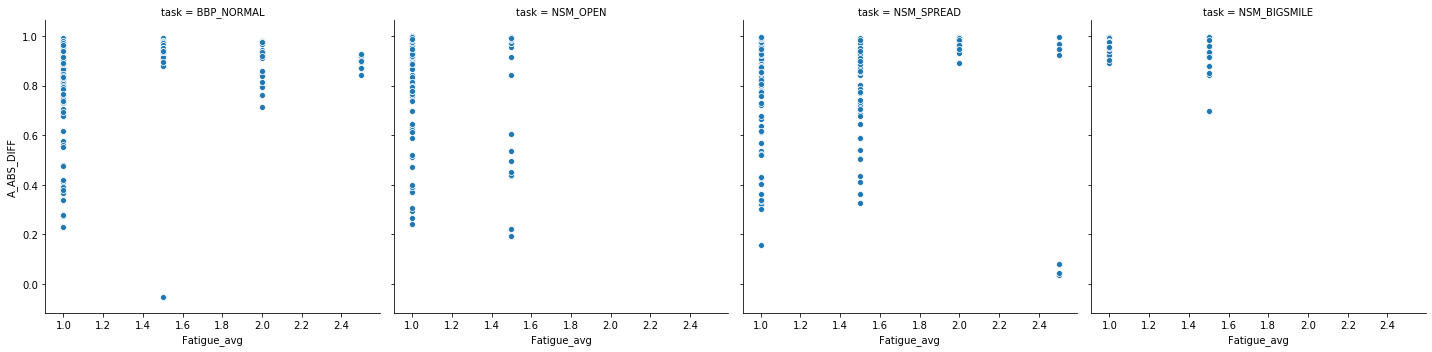

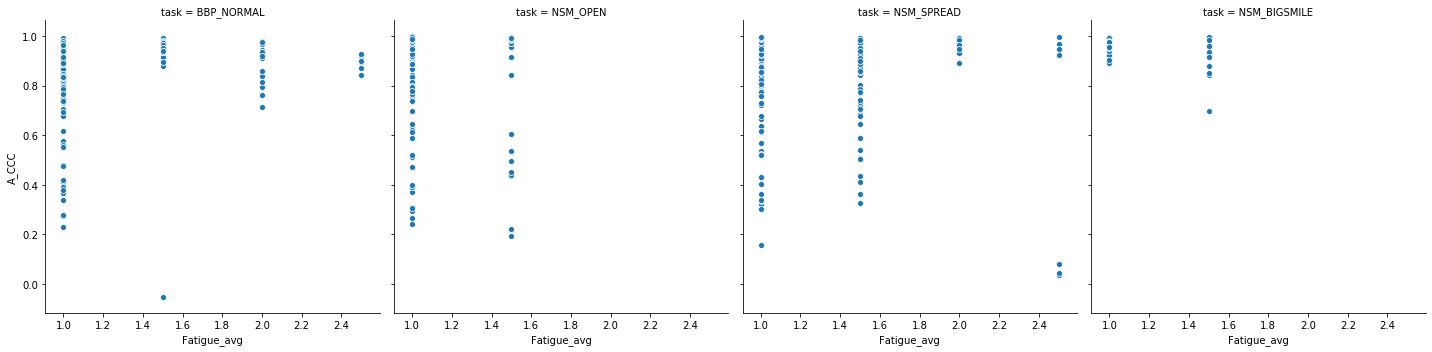

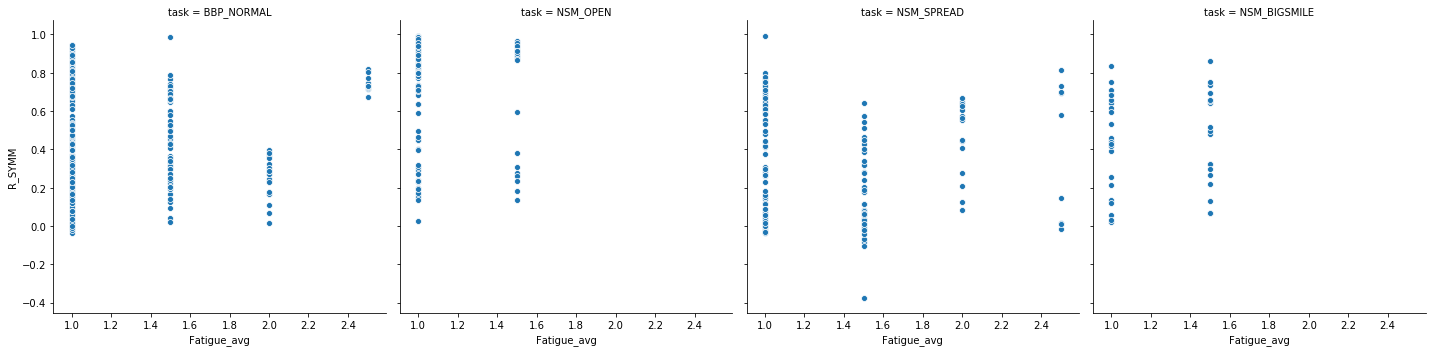

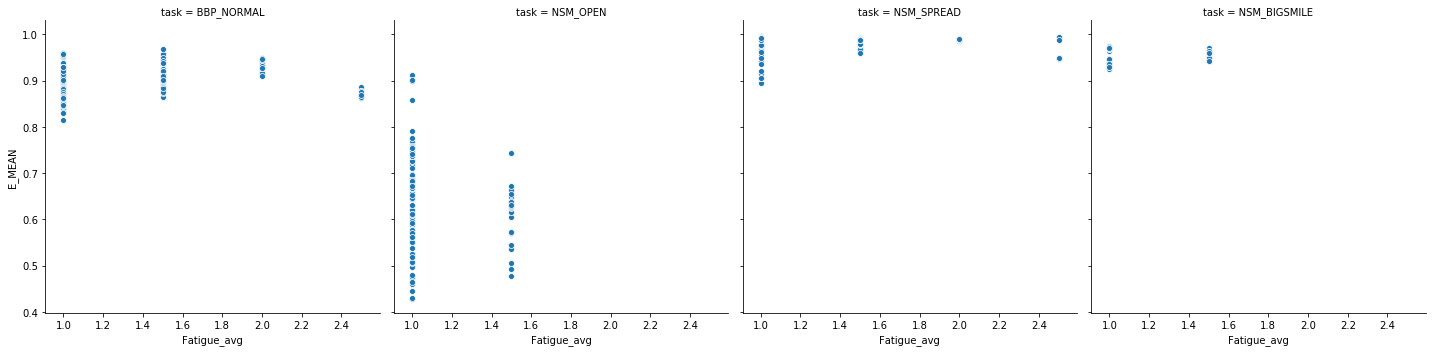

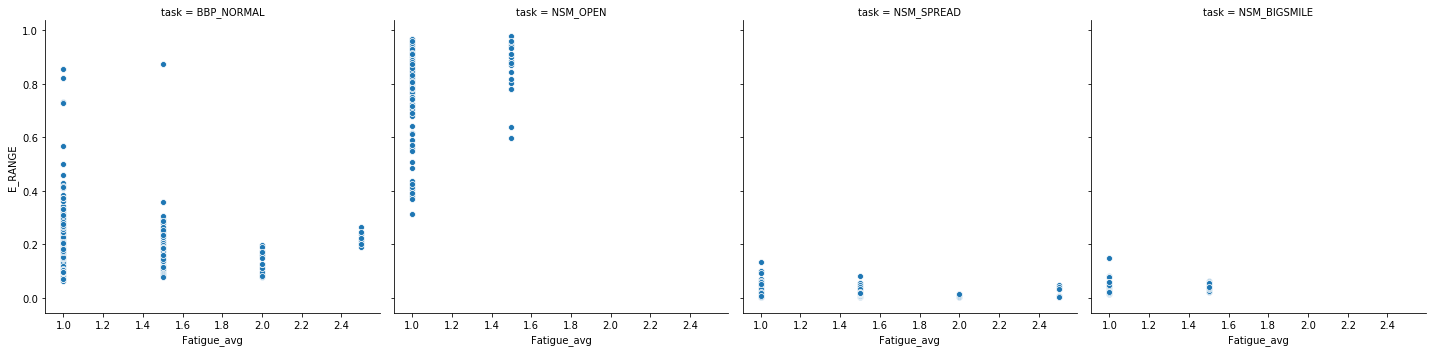

In [16]:
scores = ['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']


for score in scores:

    for f in features:
        
        g = sns.relplot(x=score, y=f, data=sub_neuro_df, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('STROKE_4corPlots_{}_{}'.format(score, f))
        corr, _ = spearmanr(sub_neuro_df[f], sub_neuro_df[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

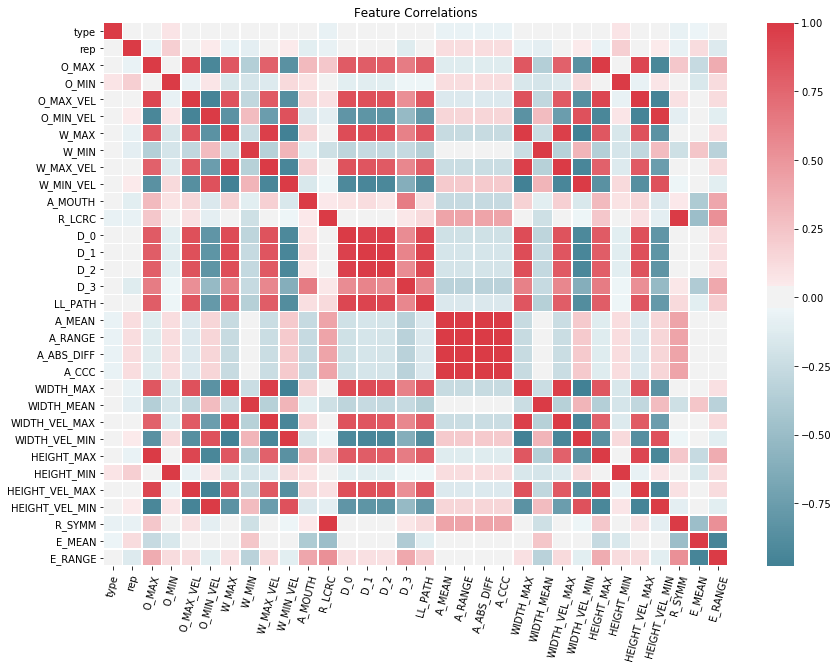

In [17]:
corr = feature_df.corr()
ax, figure = plt.subplots(figsize=(14,10))
g =sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
               center=0.00,cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.title('Feature Correlations')
plt.show()

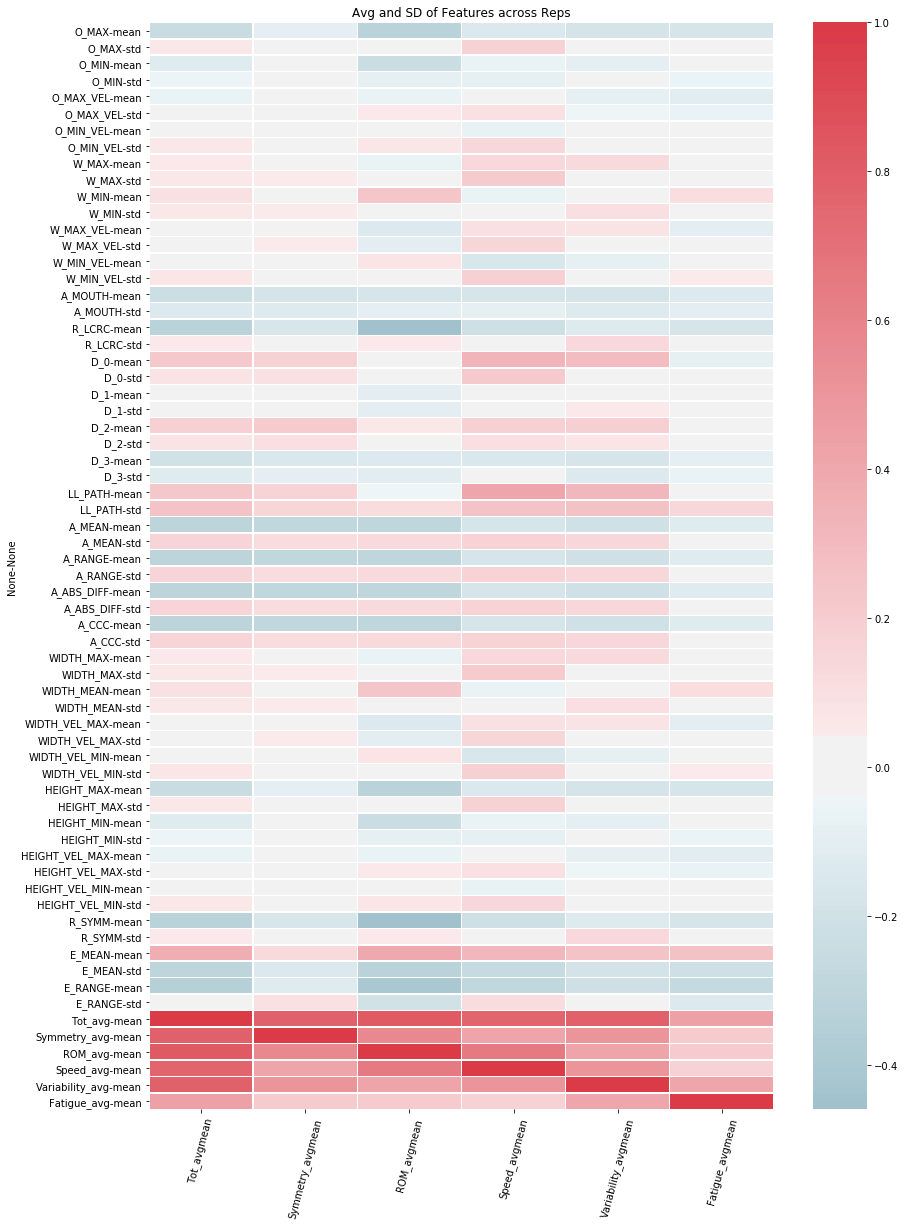

In [18]:
# run the avg and std
### Taking the average and std of the features over all the repetitions per task per participant 
task_avg_st = sub_neuro_df.groupby(['subject_id','task'])[['O_MAX', 'O_MIN', 'O_MAX_VEL', 'O_MIN_VEL',
       'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH', 'R_LCRC', 'D_0',
       'D_1', 'D_2', 'D_3', 'LL_PATH', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF',
       'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN',
       'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX', 'HEIGHT_VEL_MIN',
       'R_SYMM', 'E_MEAN', 'E_RANGE', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg']].agg([np.mean, np.std])

#print(task_avg_st.shape)
#print(task_avg_st.columns)

corr = task_avg_st.corr()
corr.columns = [''.join(col) for col in corr.columns]
corr = corr.dropna(axis = 1, how='all')
corr = corr.dropna(axis = 0, how='all')

ax, figure = plt.subplots(figsize=(14,20))
sub_corr = corr[['Tot_avgmean', 'Symmetry_avgmean', 'ROM_avgmean','Speed_avgmean', 'Variability_avgmean', 'Fatigue_avgmean']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), 
               cmap=sns.diverging_palette(220, 10, as_cmap=True),center=0.00, linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.title('Avg and SD of Features across Reps')
plt.show()

In [19]:
task_avg_st.head()

O_MAX               O_MIN           O_MAX_VEL  \
                           mean       std      mean       std      mean   
subject_id task                                                           
A008       BBP_NORMAL  3.526509  0.134706  1.274706  0.101894  1.115015   
           NSM_OPEN    6.995105  0.175914  0.936087  0.045227  1.580404   
           NSM_SPREAD  1.307276  0.087902  0.883239  0.074472  0.389948   
A009       BBP_NORMAL  2.889557  0.101372  1.045055  0.134415  0.713942   
           NSM_OPEN    3.804295  0.237031  0.832823  0.063218  0.595997   

                                O_MIN_VEL               W_MAX            ...  \
                            std      mean       std      mean       std  ...   
subject_id task                                                          ...   
A008       BBP_NORMAL  0.193309 -1.213893  0.385251  1.089566  0.014278  ...   
           NSM_OPEN    0.890085 -1.343512  0.322566  1.151766  0.049609  ...   
           NSM_SPREAD  0.095662 -0.423715  0.116110  1.352902  0.010409  ...   
A009       BBP_NORMAL  0.156726 -0.613309  0.108284  1.140563  0.075779  ...   
           NSM_OPEN    0.309288 -0.506677  0.175591  1.142713  0.030851  ...   

                      Symmetry_avg      ROM_avg      Speed_avg       \
                              mean  std    mean  std      mean  std   
subject_id task                                                       
A008       BBP_NORMAL          2.0  0.0     1.0  0.0       1.0  0.0   
           NSM_OPEN            2.5  0.0     1.0  0.0       1.0  0.0   
           NSM_SPREAD          1.0  0.0     1.0  0.0       1.0  0.0   
A009       BBP_NORMAL          2.0  0.0     2.0  0.0       2.5  0.0   
           NSM_OPEN            2.0  0.0     1.5  0.0       2.0  0.0   

                      Variability_avg      Fatigue_avg       
                                 mean  std        mean  std  
subject_id task                                              
A008       BBP_NORMAL             1.0  0.0         1.0  0.0  
           NSM_OPEN               1.5  0.0         1.5  0.0  
           NSM_SPREAD             2.0  0.0         2.0  0.0  
A009       BBP_NORMAL             2.0  0.0         2.5  0.0  
           NSM_OPEN               2.0  0.0         1.0  0.0  

[5 rows x 72 columns]

In [20]:
scores_2 = ['Tot_avgmean', 'Symmetry_avgmean', 'ROM_avgmean','Speed_avgmean', 'Variability_avgmean', 'Fatigue_avgmean']

for score in scores_2:

    for f in features:
        
        g = sns.relplot(x=score, y=f, data=task_avg_st, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('All_AcrossReps_4corPlots_{}_{}'.format(score, f))
        corr, _ = spearmanr(task_avg_st[f], task_avg_st[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

ValueError: Could not interpret input 'Tot_avgmean'

In [ ]:
# trend corrolation analysis and scatter plots 

In [ ]:
# Calculating the trend fro fatigue 

first_rep = sub_neuro_df.loc[sub_neuro_df.groupby(['subject_id','task'])['rep'].idxmin()]

last_rep = sub_neuro_df.loc[sub_neuro_df.groupby(['subject_id','task'])['rep'].idxmax()]

trend_df = pd.DataFrame()
trend_df[features] = first_rep[features] - last_rep[features].values


#.apply(lambda x: x.rep.max() - x.rep.min())

print(trend_df.shape)
trend_df

In [ ]:
trend_df = pd.merge(trend_df, sub_neuro_df[['task','Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg','Variability_avg',
                                            'Fatigue_avg']], left_index = True, right_index=True)

In [ ]:
corr = trend_df.corr()
ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool),
               cmap=sns.diverging_palette(220, 10, as_cmap=True), center=0.00,linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

# Fine-Tuned Diego's Results 

In [ ]:
def print_prop(df, file):
    print(file)
    print('Shape: ',df.shape)
    print()
    print(df.columns)
    print()
    print('Total Number of Subjects in Df are: ', len(df.subject_id.unique()))
    print("Subjects IDs are: ",df.subject_id.unique())

    print()



### Diego Stroke DATA 

In [ ]:
### STROKE DATA

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0# 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE

stroke_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_"+tasks[task]+".csv"
stroke_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
stroke_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
stroke_file_4 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"


bbp_s_df_1 = pd.read_csv(stroke_file_1)
bbp_s_df_1 = bbp_s_df_1.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_1, stroke_file_1)



bbp_s_df_2 = pd.read_csv(stroke_file_2)
bbp_s_df_2 = bbp_s_df_2.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_2, stroke_file_2)



bbp_s_df_3 = pd.read_csv(stroke_file_3)
bbp_s_df_3 = bbp_s_df_3.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_3, stroke_file_3)



bbp_s_df_4 = pd.read_csv(stroke_file_4)
bbp_s_df_4 = bbp_s_df_4.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_4, stroke_file_4)

In [ ]:
bbp_s_df_1.head()

In [ ]:
print('1 includes 2: ', set(bbp_s_df_2.subject_id.unique()).issubset(bbp_s_df_1.subject_id.unique()))
print('1 includes 3: ', set(bbp_s_df_3.subject_id.unique()).issubset(bbp_s_df_1.subject_id.unique()))
print('1 includes 4: ', set(bbp_s_df_4.subject_id.unique()).issubset(bbp_s_df_1.subject_id.unique()))

In [ ]:
for task in range(len(tasks)):
    
    stroke_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_"+tasks[task]+".csv"
    stroke_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
    stroke_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
    stroke_file_4 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"


    print(tasks[task])
    try: 
        df_1 = pd.read_csv(stroke_file_1)
        #df_1 = df_1.drop('Unnamed: 0', axis=1)
        print("df1 shape: ", df_1.shape)
        df_2 = pd.read_csv(stroke_file_2)
        #df_2 = df_2.drop('Unnamed: 0', axis=1)
        print("df2 shape: ", df_2.shape)
        df_3 = pd.read_csv(stroke_file_3)
        #df_3 = df_3.drop('Unnamed: 0', axis=1)
        print("df3 shape: ", df_3.shape)
        df_4 = pd.read_csv(stroke_file_4)
        print("df4 shape: ", df_4.shape)
        #df_4 = df_4.drop('Unnamed: 0', axis=1)
        
    except: 
        pass

    print('1 includes 2: ', set(df_2.subject_id.unique()).issubset(df_1.subject_id.unique()))
    print('1 includes 3: ', set(df_3.subject_id.unique()).issubset(df_1.subject_id.unique()))
    print('1 includes 4: ', set(df_4.subject_id.unique()).issubset(df_1.subject_id.unique()))


In [ ]:
stroke_df = pd.DataFrame()

for task in range(len(tasks)):
    
    stroke_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_"+tasks[task]+".csv"
    
    df = pd.read_csv(stroke_file)
    df = df.drop('Unnamed: 0', axis=1)
    stroke_df = pd.concat([stroke_df, df], ignore_index=True)

    
    
print(stroke_df.shape)



In [ ]:
stroke_df['population'] = [pop_labeler(x) for x in stroke_df['subject_id']]
stroke_df.head()

In [ ]:

print('len: ' , len(stroke_df))
print(len(stroke_df.columns))
print(stroke_df.columns)
print(stroke_df.groupby(['population']).subject_id.unique())
print(stroke_df.task.unique())

with np.printoptions(threshold=np.inf):
    print(stroke_df.groupby(['population']).subject_id.unique())
    print(len(stroke_df.subject_id.unique()))
    
print(np.intersect1d(stroke_df.subject_id.unique(),neuroface_subjects))
print(len(np.intersect1d(stroke_df.subject_id.unique(),neuroface_subjects)))

In [ ]:
len(stroke_df.groupby(['population']).subject_id.unique()['Stroke'])

In [ ]:
stroke_df.groupby(['population','task']).count()

In [ ]:
# TASKS 
ax, figure = plt.subplots(figsize=(10,7))
g = sns.countplot(x='task',data=stroke_df,hue='population')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# set axes labels and title
plt.ylabel('# of reps')
plt.title('Total Number of reps analyzed for each clinical task')
plt.show()

# Getting the corrolations based on the common data with clinical scores 

In [ ]:
slp_scores

In [ ]:
stroke_df

In [ ]:
stroke_and_scores = stroke_df.merge(slp_scores, how= 'inner', left_on=['subject_id', 'task'], right_on=['Subject ID', 'task'])

print(len(stroke_and_scores.subject_id.unique()))
print(stroke_and_scores.subject_id.unique())
print(stroke_and_scores.task.unique())

print(stroke_df.shape)
print(stroke_and_scores.shape)
print(stroke_and_scores.columns)

In [ ]:
# filtering out the outliers 

z_scores = stats.zscore(stroke_and_scores[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_stroke_and_scores = stroke_and_scores[filtered_entries]

print(new_stroke_and_scores.shape)

In [ ]:
just_stroke = new_stroke_and_scores.loc[new_stroke_and_scores['type']== 1]

z_scores = stats.zscore(just_stroke[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
just_stroke = just_stroke[filtered_entries]

print(just_stroke.shape)


In [ ]:
stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

tasks = ['BBP_NORMAL', 'NSM_OPEN' ,'NSM_SPREAD' ,'NSM_BIGSMILE']

scores = ['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']


for score in scores:

    for f in stroke_features:
        
        g = sns.relplot(x=score, y=f, data=just_stroke, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('STROKE_4corPlots_{}_{}'.format(score, f))
        corr, _ = spearmanr(just_stroke[f], just_stroke[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

        # calculate spearman's correlation

### Figuring out the trend by Trend = 1st repetition feature values - Last repetition feature values 
### for each task per participant 

In [ ]:
# Calculating the trend fro fatigue 

first_rep = just_stroke.loc[just_stroke.groupby(['subject_id','task'])['rep'].idxmin()]

last_rep = just_stroke.loc[just_stroke.groupby(['subject_id','task'])['rep'].idxmax()]

trend_df = pd.DataFrame()
trend_df[['O_MAX_diff', 'O_MIN_diff','O_MAX_VEL_diff', 'O_MIN_VEL_diff', 'W_MAX_diff', 'W_MIN_diff', 'W_MAX_VEL_diff', 'W_MIN_VEL_diff',
       'A_MOUTH_diff', 'R_LCRC_diff', 'D_0_diff', 'D_1_diff', 'D_2_diff', 'D_3_diff']] = first_rep[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']] - last_rep[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']].values


#.apply(lambda x: x.rep.max() - x.rep.min())

print(trend_df.shape)
trend_df

In [ ]:
trend_df = pd.merge(trend_df, just_stroke[['task','Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']], left_index = True, right_index=True)

In [ ]:
# Scatter plot for the trend 

for score in scores:

    for f in stroke_features:
        
        g = sns.relplot(x=score, y=f+'_diff', data=trend_df, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('STROKE_4corPlots_{}_{}'.format(score, f+'_diff'))
        corr, _ = spearmanr(just_stroke[f], just_stroke[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
corr = trend_df.corr()

In [ ]:
ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:
# working example of agg with definition of fuction 

def diff(x):
    return np.max(x) - np.min(x)

just_stroke.groupby(['subject_id','task'])['rep'].agg([np.max,np.min, diff])

### Taking the average and std of the features over all the repetitions per task per participant 

In [ ]:
### Taking the average and std of the features over all the repetitions per task per participant 
stroke_task_avg = just_stroke.groupby(['subject_id','task'])[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3', 'Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']].agg([np.mean, np.std])

print(stroke_task_avg.shape)
print(stroke_task_avg.columns)

In [ ]:
corr = stroke_task_avg.corr()

In [ ]:
corr.columns = [''.join(col) for col in corr.columns]
corr = corr.dropna(axis = 1, how='all')
corr = corr.dropna(axis = 0, how='all')

ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avgmean', 'Symmetry_avgmean', 'ROM_avgmean','Speed_avgmean', 'Variability_avgmean', 'Fatigue_avgmean']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:
# raw data corrolations and scatter plots between each feature and a single clinical score 

stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

tasks = ['BBP_NORMAL', 'NSM_OPEN' ,'NSM_SPREAD' ,'NSM_BIGSMILE']



for score in scores:

    for task in tasks: 
        for f in stroke_features:
            plt.figure()
            ax, figure = plt.subplots(figsize=(10,7))
            score = 'ROM_avg'
            sns.scatterplot(x=score, y=f, data=just_stroke, hue='task')
            plt.title('The scatter plot between {} and {}'.format(f, score ))

            # calculate spearman's correlation
            #corr, _ = spearmanr(stroke_and_scores[f], stroke_and_scores[score])
            #print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
# outliers removed scatter plot and corrolations between each feature and a single clinical score 
scores = ['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']


for score in scores: 
    
    for f in stroke_features:
        plt.figure()
        ax, figure = plt.subplots(figsize=(10,7))
        
        sns.scatterplot(x=score, y=f, data=just_stroke, hue='task', style='population_y')
        plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('STROKE_{}_{}'.format(score, f))

        # calculate spearman's correlation
        corr, _ = spearmanr(new_stroke_and_scores[f], new_stroke_and_scores[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
new_stroke_and_scores.columns

In [ ]:
sub_stroke = new_stroke_and_scores[['subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
       'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg', 'population_y']]

In [ ]:
corr = sub_stroke.corr()

In [ ]:
ax, figure = plt.subplots(figsize=(14,10))
sub_corr_f = corr[['rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
       'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
sub_corr_f = sub_corr_f.drop(['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg'], axis=0)
g =sns.heatmap(sub_corr_f, mask=np.zeros_like(sub_corr_f, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:
# corrolation of clinical scores to themselves and the features 

ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:

ax, figure = plt.subplots(figsize=(14,10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(corr, mask=mask, vmax=.3, square=True)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

### Diego ALS DATA 

In [ ]:
### ALS DATA
tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0# 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE
als_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
als_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
als_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"


bbp_als_df_1 = pd.read_csv(als_file_1)
bbp_als_df_1 = bbp_als_df_1.drop('Unnamed: 0', axis=1)
print_prop(bbp_als_df_1, als_file_1)


bbp_als_df_2 = pd.read_csv(als_file_2)
bbp_als_df_2 = bbp_als_df_2.drop('Unnamed: 0', axis=1)
print_prop(bbp_als_df_2, als_file_2)


bbp_als_df_3 = pd.read_csv(als_file_3)
bbp_als_df_3 = bbp_als_df_3.drop('Unnamed: 0', axis=1)
print_prop(bbp_als_df_3, als_file_3)



In [ ]:
print('3 includes 1: ', set(bbp_als_df_1.subject_id.unique()).issubset(bbp_als_df_3.subject_id.unique()))

print('2 includes 1: ', set(bbp_als_df_1.subject_id.unique()).issubset(bbp_als_df_2.subject_id.unique()))

print(bbp_als_df_1.subject_id.unique())
print(bbp_als_df_2.subject_id.unique())
print(bbp_als_df_3.subject_id.unique())

In [ ]:
bbp_als_df_1.loc[bbp_als_df_1['subject_id'] == 'A008']

In [ ]:
bbp_als_df_3.loc[bbp_als_df_3['subject_id'] == 'A008']

In [ ]:
diego_bbp = bbp_als_df_1.merge(bbp_als_df_2)
diego_bbp = diego_bbp.merge(bbp_als_df_3)
uncommon_1 = bbp_als_df_1.loc[~bbp_als_df_1.subject_id.isin(diego_bbp.subject_id)]
uncommon_2 = bbp_als_df_2.loc[~bbp_als_df_2.subject_id.isin(diego_bbp.subject_id)]
uncommon_3 = bbp_als_df_3.loc[~bbp_als_df_3.subject_id.isin(diego_bbp.subject_id)]

print('shapes: ',uncommon_1.shape, uncommon_2.shape, uncommon_3.shape)

diego_bbp = pd.concat([diego_bbp, uncommon_1, uncommon_2, uncommon_3], ignore_index=True)

print_prop(diego_bbp, als_file_3)

In [ ]:
als_df = pd.DataFrame()

for task in range(len(tasks)):
    als_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
    als_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
    als_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"
    
    try: 
        als_df_1 = pd.read_csv(als_file_1)
    except:
        pass
    try:
        als_df_2 = pd.read_csv(als_file_2)
    except:
        pass
    try:
        als_df_3 = pd.read_csv(als_file_3)
    except:
        pass
    als_df = pd.concat([als_df, als_df_1, als_df_2, als_df_3], ignore_index=True)



    
print(als_df.shape)


In [ ]:
als_df = als_df.drop_duplicates()

als_df = als_df.drop('Unnamed: 0', axis=1)

In [ ]:
print(len(als_df_1.groupby(['population']).subject_id.unique()['ALS']))
print(len(als_df_1.groupby(['population']).subject_id.unique()['HC']))
print(als_df_1.groupby(['population']).subject_id.unique()['ALS'])
print(als_df_1.groupby(['population']).subject_id.unique()['HC'])

In [ ]:
als_df['population'] = [pop_labeler(x) for x in als_df['subject_id']]

In [ ]:
print(als_df.shape)
print(als_df.columns)
print(als_df.task.unique())
print(als_df.subject_id.unique())
print(len(als_df.subject_id.unique()))
print(len(als_df.groupby(['population']).subject_id.unique()['ALS']))
print(len(als_df.groupby(['population']).subject_id.unique()['HC']))
print(als_df.groupby(['population']).subject_id.unique()['ALS'])
print(als_df.groupby(['population']).subject_id.unique()['HC'])

In [ ]:
# Print the needed info 

print(np.intersect1d(als_df.subject_id.unique(),neuroface_subjects))
print(len(np.intersect1d(als_df.subject_id.unique(),neuroface_subjects)))

In [ ]:
als_df

In [ ]:
als_and_scores = als_df.merge(slp_scores, how= 'inner', left_on=['subject_id', 'task'], right_on=['Subject ID', 'task'])

print(len(als_and_scores.subject_id.unique()))
print(als_and_scores.subject_id.unique())
print(als_and_scores.task.unique())

print(als_df.shape)
print(als_and_scores.shape)
print(als_and_scores.columns)

In [ ]:
# raw data corrolations and scatter plots between each feature and a single clinical score 

als_features = ['LL_PATH', 'A_MEAN', 'A_RANGE','A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 
                   'WIDTH_VEL_MAX','WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']

for f in als_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    score = 'ROM_avg'
    sns.scatterplot(x=score, y=f, data=als_and_scores, hue='task', style='population_y')
    plt.title('The scatter plot between {} and {}'.format(f, score ))

    # calculate spearman's correlation
    corr, _ = spearmanr(als_and_scores[f], als_and_scores[score])
    print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
# filtering out the outliers 

z_scores = stats.zscore(als_and_scores[['LL_PATH', 'A_MEAN', 'A_RANGE','A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 
                   'WIDTH_VEL_MAX','WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_als_and_scores = als_and_scores[filtered_entries]

print(new_als_and_scores.shape)

In [ ]:
#f, axes = plt.subplots(4, 4, figsize=(7, 7))

scores = ['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']
for score in scores: 
    for f in als_features:
        plt.figure()
        ax, figure = plt.subplots(figsize=(10,7))
        #score = 'ROM_avg'
        sns.scatterplot(x=score, y=f, data=new_als_and_scores, hue='task', style='population_y')
        plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('ALS_{}_{}'.format(score, f))

        # calculate spearman's correlation
        corr, _ = spearmanr(new_als_and_scores[f], new_als_and_scores[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
new_als_and_scores.columns

In [ ]:
sub_als = new_als_and_scores[['subject_id', 'task', 'type','rep', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE', 'population_x',
       'File Name', 'Subject ID', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg', 'population_y']]

In [ ]:
print(sub_als.shape)
sub_als.loc[sub_als['subject_id'] != sub_als['Subject ID']]

In [ ]:
corr = sub_als.corr()

In [ ]:
ax, figure = plt.subplots(figsize=(14,10))
sub_corr_f = corr[['rep', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
sub_corr_f = sub_corr_f.drop(['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg'], axis=0)
g =sns.heatmap(sub_corr_f, mask=np.zeros_like(sub_corr_f, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:
# corrolation of clinical scores to themselves and the features 


ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()


In [ ]:
print(corr.shape)
print(corr.columns)
print(sub_corr.columns)
print(sub_corr.shape)

In [ ]:
### Taking the average and std of the features over all the repetitions per task per participant 
als_task_avg = sub_als.groupby(['subject_id','task'])[['LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE', 'Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']].agg([np.mean, np.std])

print(als_task_avg.shape)
print(als_task_avg.columns)

In [ ]:
corr = als_task_avg.corr()
corr.columns = [''.join(col) for col in corr.columns]
corr = corr.dropna(axis = 1, how='all')
corr = corr.dropna(axis = 0, how='all')

ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avgmean', 'Symmetry_avgmean', 'ROM_avgmean','Speed_avgmean', 'Variability_avgmean', 'Fatigue_avgmean']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

# TREND of the features

In [ ]:
# Calculating the trend fro fatigue 

first_rep = sub_als.loc[sub_als.groupby(['subject_id','task'])['rep'].idxmin()]

last_rep = sub_als.loc[sub_als.groupby(['subject_id','task'])['rep'].idxmax()]

trend_als_df = pd.DataFrame()
trend_als_df[['LL_PATH_diff', 'A_MEAN_diff', 'A_RANGE_diff',
       'A_ABS_DIFF_diff', 'A_CCC_diff', 'WIDTH_MAX_diff', 'WIDTH_MEAN_diff', 'WIDTH_VEL_MAX_diff',
       'WIDTH_VEL_MIN_diff', 'HEIGHT_MAX_diff', 'HEIGHT_MIN_diff', 'HEIGHT_VEL_MAX_diff',
       'HEIGHT_VEL_MIN_diff', 'R_SYMM_diff', 'E_MEAN_diff', 'E_RANGE_diff']] = first_rep[['LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']] - last_rep[['LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']].values


#.apply(lambda x: x.rep.max() - x.rep.min())

print(trend_als_df.shape)
trend_als_df = pd.merge(trend_als_df, sub_als[['task','Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 
                                               'Variability_avg', 'Fatigue_avg']], left_index = True, right_index=True)
print(trend_als_df.shape)

In [ ]:
# corrolation plot 

corr = trend_als_df.corr()
ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:
# scatter plot

# Scatter plot for the trend 

for score in scores:

    for f in als_features:
        f= f+'_diff'
        g = sns.relplot(x=score, y=f, data=trend_als_df, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('ALS_4corPlots_{}_{}'.format(score, f))
        corr, _ = spearmanr(trend_als_df[f], trend_als_df[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
just_als = new_als_and_scores.loc[new_als_and_scores['type']== 1]

z_scores = stats.zscore(just_als[[ 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
just_als = just_als[filtered_entries]

print(just_als.shape)

In [ ]:
als_features = ['LL_PATH', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 
                   'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
                   'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']

tasks = ['BBP_NORMAL', 'NSM_OPEN' ,'NSM_SPREAD' ,'NSM_BIGSMILE']

scores = ['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']


for score in scores:

    for f in als_features:
        
        g = sns.relplot(x=score, y=f, data=just_als, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('ALS_4corPlots_{}_{}'.format(score, f))
        corr, _ = spearmanr(just_als[f], just_als[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

# UP to here

In [ ]:
ax, figure = plt.subplots(figsize=(10,7))
g = sns.countplot(x='task',data=als_df,hue='population')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# set axes labels and title
plt.ylabel('# of reps')
plt.title('Total Number of reps analyzed for each clinical task')
plt.show()

In [ ]:
#bbp_als_df_1.loc[~bbp_als_df_.subject_id.isin(a.subject_id)]



In [ ]:

np.intersect1d(diego_bbp.subject_id.unique(),neuroface_subjects)



Features of the tasks seperated into repetitions 

In [ ]:
# Standardized BBP 

path4 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

bbp_df = pd.read_csv(path4)

print(len(bbp_df))
print(len(bbp_df.columns))
print(bbp_df.columns)
print(bbp_df.subject_id.unique())
bbp_df.head()


# Standardized Open

path6 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_OPEN_standardized.csv'

open_df = pd.read_csv(path6)

print(len(open_df))
print(len(open_df.columns))
print(open_df.subject_id.unique())
print(open_df.columns)
open_df.head()

# Standardized Big Smile

path5 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_BIGSMILE_standardized.csv'

bigs_df = pd.read_csv(path5)

print(len(bigs_df))
print(len(bigs_df.columns))
print(bigs_df.columns)
print(bigs_df.subject_id.unique())
bigs_df.head()


# Standardized Spread

path7 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_SPREAD_standardized.csv'

spread_df = pd.read_csv(path7)

print(len(spread_df))
print(len(spread_df.columns))
print(spread_df.columns)
print(spread_df.subject_id.unique())
spread_df.head()

Plotting the corrolation of the 

In [ ]:
stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

for f in stroke_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    sns.scatterplot(x='Tot_avg', y=f, data=df_f2, hue='subject_id')

    # calculate spearman's correlation
    corr, _ = spearmanr(df_f2[f], df_f2['Tot_avg'])
    print('Spearmans correlation: %.3f' % corr)

## Stroke data

In [ ]:
# SLP SCORES

path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Stroke/SLP_Assessment_PS.csv'
ps_df = pd.read_csv(path)

ps_df = ps_df.drop('Unnamed: 8', axis=1)

# average of the clinical scores 

ps_df['Tot_avg'] = ps_df.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
ps_df['Symmetry_avg'] = ps_df.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
ps_df['ROM_avg'] = ps_df.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
ps_df['Speed_avg'] = ps_df.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
ps_df['Variability_avg'] = ps_df.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
ps_df['Fatigue_avg'] = ps_df.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)



print('len: ', len(ps_df))
print(ps_df.columns)
print(ps_df['Subject ID'].unique())
ps_df.head()

In [ ]:
tasks = ['BBP_NORMAL', 'PA', 'PATAKA', 'BLOW', 'KISS', 'OPEN', 'SPREAD', 'BIGSMILE', 'BROW']

def task_labeler(row):
    for t in tasks: 
        if t in row: 
            return t
    

ps_df['task'] = [task_labeler(x) for x in ps_df['File Name']]

ps_df.head()

In [ ]:
print(ps_df.shape)
print(ps_df['Subject ID'].unique())

In [ ]:
ps_df_bbp = ps_df[ps_df['task']== 'BBP_NORMAL']

In [ ]:
print(ps_df.shape)

print(ps_df_bbp.shape)
print(ps_df_bbp['Subject ID'].unique())
ps_df_bbp.head()

In [ ]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_BBP_NORMAL_standardized.csv'

s_bbp_df = pd.read_csv(path)

print('len: ' , len(s_bbp_df))
print(len(s_bbp_df.columns))
print(s_bbp_df.columns)
print(s_bbp_df.subject_id.unique())
print(s_bbp_df.task.unique())
s_bbp_df.head()

In [ ]:
df_f = s_bbp_df.merge(ps_df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')

print(df_f.size)
print(df_f.shape)
print(ps_df_bbp.shape)
print(s_bbp_df.shape)
print('len: ', len(df_f))

print(df_f.Tot_avg.isnull().count())

df_f.Tot_avg

In [ ]:
df_f.head()

In [ ]:
df_f.subject_id.unique()

In [ ]:
g = sns.FacetGrid(df_f, col="subject_id", col_wrap=3, height=5, ylim=(0, 20))
g.map(sns.pointplot, "O_MAX", "Tot_avg",color=".3", ci=None);

In [ ]:
ax, figure = plt.subplots(figsize=(10,7))
plt.scatter(df_f['Tot_avg'], df_f["O_MAX"])


# calculate spearman's correlation
corr, _ = spearmanr(df_f["O_MAX"], df_f['Tot_avg'])
print('Spearmans correlation: %.3f' % corr)

In [ ]:
ax, figure = plt.subplots(figsize=(10,7))
sns.scatterplot(x='Tot_avg', y="O_MAX", data=df_f, hue='subject_id')

# calculate spearman's correlation
corr, _ = spearmanr(df_f["O_MAX"], df_f['Tot_avg'])
print('Spearmans correlation: %.3f' % corr)

In [ ]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

s_bbp2_df = pd.read_csv(path)

print(len(s_bbp2_df))
print(len(s_bbp2_df.columns))
print(s_bbp2_df.columns)
print(s_bbp2_df.subject_id.unique())
s_bbp2_df

In [ ]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

als_bbp2_df = pd.read_csv(path)

print(len(als_bbp2_df))
print(len(als_bbp2_df.columns))
print(als_bbp2_df.columns)
print(als_bbp2_df.subject_id.unique())
als_bbp2_df

### BBP_NORMAL ACROSS ALL SUBJECTS ANALYSIS

In [ ]:
# obtaining the clinical data for bbp task only 
df_bbp = slp_scores[slp_scores['task']== 'BBP_NORMAL']

# merging the clinical data with the features 
df_f1 = als_bbp2_df.merge(df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')
df_f2 = s_bbp2_df.merge(df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')

print(df_f1.subject_id.unique())
print(df_f2.subject_id.unique())


In [ ]:
df_f1.columns

In [ ]:
df_f2.columns

In [ ]:
stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

for f in stroke_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    sns.scatterplot(x='Tot_avg', y=f, data=df_f2, hue='subject_id')

    # calculate spearman's correlation
    corr, _ = spearmanr(df_f2[f], df_f2['Tot_avg'])
    print('Spearmans correlation: %.3f' % corr)

In [ ]:
stroke_to_regr_df = df_f2[['subject_id', 'task_x','Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg',
       'Variability_avg', 'Fatigue_avg', 'O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']]



In [ ]:
stroke_to_regr_df

## Running RF Regression on the data

In [ ]:
print(sub_als.columns)
sub_als.head()

In [ ]:
sub_als.columns[3:20]
sub_als.columns[23]

In [ ]:
def regressor(data, regr, col): 
    
    # col will tell us which clinical score we will predict, there are 5 of them 
    # regr is the type of regression model we use, start testing with rf regressor
    # data is the df 
    
    # we will do leave one subject out for evaluating the model 
    subjects  = data['subject_id'].unique()
    
    all_y = []
    all_y_star = []

    all_y_subject = []
    all_prob_subject = []
    
    for s in subjects: 
        values_train = data.loc[data.subject_id != s].values  
        
        ##### need to change this based on the df structure in my setup!!!!!!!!!
        ### change 4, for y is already made the change 
        X_train = values_train[:,3:20]
        y_train = values_train[:,col]

        values_test = data.loc[data.subject_id == s].values  
        X_test = values_test[:,3:20]
        # reps of the same task for a given subject 
        y_test = values_test[:,col]
        

        regr_fit = regr.fit(X_train,y_train)
        results = regr_fit.predict(X_test)#[:,1]
        
        all_y.append(y_test)
        all_y_star.append(results)
        
        
           # average out the predictions of the reps of the task to get one final vlue for clinical score
        all_y_subject.append(np.mean(y_test[:]))
        all_prob_subject.append(np.mean(results[:]))
        
        #print(clf_fit.feature_importances_)
        #print('y-all-subj: ' , all_y_subject)
        #print('y_all_star-subj: ', all_prob_subject)
        

    
    #flat_list_y = [item for sublist in all_y for item in sublist]
    #flat_list_prob = [item for sublist in all_y_star for item in sublist]
    
    #print('y-all-flat: ' , flat_list_y)
    #print('y_all_star-flat: ', flat_list_prob)
    #return np.array(all_y_subject).astype(int),np.array(all_prob_subject), np.array(flat_list_y).astype(int), np.array(flat_list_prob)
    return np.array(all_y_subject), np.array(all_prob_subject)

In [ ]:
### BBP_NORMAL Task 

regr = RandomForestRegressor(n_jobs=-1, random_state=42)


clinical_measure = ['Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg','Variability_avg', 'Fatigue_avg']
col = 23  # 2-> Tot_avg, 3-> Symmetry_avg, 4-> ROM_avg, 5-> Speed_avg, 6-> Variability_avg, 7-> Fatigue_avg
#all_y_subject_finetuned,all_prob_subject_finetuned,all_y_finetuned,all_prob_finetuned = regressor(Data_3D, regr)

all_y_subject,all_prob_subject = regressor(sub_als, regr, col)

idx = 0
print('clinical_measure: ', clinical_measure[idx])
print("y: ",all_y_subject)
print("prediction: ",all_prob_subject)

corr, _ = spearmanr(all_y_subject, all_prob_subject)
print('Spearmans correlation: %.3f' % corr)
print()


plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
#score = 'ROM_avg'
plt.scatter(x=all_y_subject, y=all_prob_subject)

plt.xlabel('True Labels');
plt.ylabel('Predicted Labels');
plt.title('The scatter plot between y and prediction for total score in ALS')
#plt.savefig('ALS_{}_{}'.format(score, f))



if 0:

    fpr_finetuned, tpr_finetuned, thresholds_finetuned = roc_curve(all_y_subject_finetuned,all_prob_subject_finetuned,pos_label=0)
    roc_auc_finetuned= auc(fpr_finetuned, tpr_finetuned)



    plt.figure(1, figsize=(12,6))
    plt.plot(fpr_finetuned, tpr_finetuned, lw=2, alpha=0.75, color='r');

    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100),'k')
    plt.ylabel('True Positive');
    plt.xlabel('False Positive');
    plt.legend(['finetuned model - AUC ='+str(np.round(roc_auc_finetuned,2))]);

In [ ]:
print(sub_stroke.columns)
sub_stroke.head()

In [ ]:
sub_stroke.columns[18]

In [ ]:
def regressor_stroke(data, regr, col): 
    
    # col will tell us which clinical score we will predict, there are 5 of them 
    # regr is the type of regression model we use, start testing with rf regressor
    # data is the df 
    
    # we will do leave one subject out for evaluating the model 
    subjects  = data['subject_id'].unique()
    
    all_y = []
    all_y_star = []

    all_y_subject = []
    all_prob_subject = []
    
    for s in subjects: 
        values_train = data.loc[data.subject_id != s].values  
        
        ##### need to change this based on the df structure in my setup!!!!!!!!!
        ### change 4, for y is already made the change 
        X_train = values_train[:,3:18]
        y_train = values_train[:,col]

        values_test = data.loc[data.subject_id == s].values  
        X_test = values_test[:,3:18]
        # reps of the same task for a given subject 
        y_test = values_test[:,col]
        

        regr_fit = regr.fit(X_train,y_train)
        results = regr_fit.predict(X_test)#[:,1]
        
        all_y.append(y_test)
        all_y_star.append(results)
        
        
           # average out the predictions of the reps of the task to get one final vlue for clinical score
        all_y_subject.append(np.mean(y_test[:]))
        all_prob_subject.append(np.mean(results[:]))
        
        #print(clf_fit.feature_importances_)
        #print('y-all-subj: ' , all_y_subject)
        #print('y_all_star-subj: ', all_prob_subject)
        

    
    #flat_list_y = [item for sublist in all_y for item in sublist]
    #flat_list_prob = [item for sublist in all_y_star for item in sublist]
    
    #print('y-all-flat: ' , flat_list_y)
    #print('y_all_star-flat: ', flat_list_prob)
    #return np.array(all_y_subject).astype(int),np.array(all_prob_subject), np.array(flat_list_y).astype(int), np.array(flat_list_prob)
    return np.array(all_y_subject), np.array(all_prob_subject)

In [ ]:
regr = RandomForestRegressor(n_jobs=-1, random_state=42)


clinical_measure = ['Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg','Variability_avg', 'Fatigue_avg']
col = 18  # 2-> Tot_avg, 3-> Symmetry_avg, 4-> ROM_avg, 5-> Speed_avg, 6-> Variability_avg, 7-> Fatigue_avg
#all_y_subject_finetuned,all_prob_subject_finetuned,all_y_finetuned,all_prob_finetuned = regressor(Data_3D, regr)

all_y_subject,all_prob_subject = regressor_stroke(sub_stroke, regr, col)

idx = 0
print('clinical_measure: ', clinical_measure[idx])
print("y: ",all_y_subject)
print("prediction: ",all_prob_subject)

corr, _ = spearmanr(all_y_subject, all_prob_subject)
print('Spearmans correlation: %.3f' % corr)
print()


plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
#score = 'ROM_avg'
plt.scatter(x=all_y_subject, y=all_prob_subject)

plt.xlabel('True Labels');
plt.ylabel('Predicted Labels');
plt.title('The scatter plot between y and prediction for total score in Stroke')
#plt.savefig('ALS_{}_{}'.format(score, f))



The end!!!!!!!!!!!

In [ ]:
tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0 # 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE


file = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
Data_3D = pd.read_csv(file, index_col=0)
Data_3D

In [ ]:
subjects_to_remove = 'NF11|OP01'




In [ ]:
Data_3D.subject_id.unique()

In [ ]:
Data_3D[Data_3D['subject_id'].str.contains(subjects_to_remove,regex=True)==False] 

In [ ]:
    
if 0:    
    path3 = r'/Users/denizjafari/documents/CODE/ClinicalScore/for_deniz.csv'

    df3 = pd.read_csv(path3)

    print(len(df3))
    print(df3.columns)
    df3.head()
    
    
# average of the clinical scores 

#df['Tot_avg'] = df.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
#df['Symmetry_avg'] = df.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
#df['ROM_avg'] = df.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
#df['Speed_avg'] = df.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
#df['Variability_avg'] = df.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
#df['Fatigue_avg'] = df.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)

# the ranges 


def clinical_severity(row):
    if row['Tot_avg'] ==5 :
        return 'Normal'
    if row['Tot_avg'] > 5 and row['Tot_avg'] <=10 :
        return 'Mild'
    if row['Tot_avg'] <=15 and row['Tot_avg'] > 10:
        return 'Moderate'
    if row['Tot_avg'] >15 :
        return 'Severe'
    return 'Wrong_Value'

#df['Clinical_Cat'] = df.apply (lambda row: clinical_severity(row), axis=1)

# lets see the severity of the oro-facial defecits in the clinical population 

if 0:
    sns.countplot(x='Clinical_Cat',data=df)
    # set axes labels and title
    plt.ylabel('Number of People')
    plt.title('Total Number of People in each Clinical category')
    plt.show()
    
if 0:
    plt.scatter(df['Tot (SLP1)'], df['Tot (SLP2)'])
    # calculate spearman's correlation
    corr, _ = spearmanr(df['Tot (SLP1)'], df['Tot (SLP2)'])
    print('Spearmans correlation: %.3f' % corr)
    
    
if 0:
    sns.boxplot(x=df['Subject ID'], y=df['Tot (SLP1)'])
    plt.title('Distribution of SLP1 Total Score')
    plt.show()

    sns.boxplot(x=df['Subject ID'], y=df['Tot (SLP2)'])
    plt.title('Distribution of SLP2 Total Score')
    plt.show()

    sns.boxplot(x=df['Subject ID'], y=df['Tot_avg'])
    plt.title('Distribution of SLP Avg Total Score')
    plt.show()